In [2]:
# imports
using DelimitedFiles
using LinearAlgebra
using Statistics
using PyPlot


(.:5639): Gdk-CRITICAL **: 21:03:57.556: gdk_cursor_new_for_display: assertion 'GDK_IS_DISPLAY (display)' failed

(.:5639): Gdk-CRITICAL **: 21:03:57.617: gdk_cursor_new_for_display: assertion 'GDK_IS_DISPLAY (display)' failed


In [3]:
# function
function def_ENSO_phases(ENSO_val)
    # El Niño -> anomaly above 0.5 / La Niña -> anomaly below 0.5 
    ENSO_phases = Array{String}(undef, size(ENSO_val));
    for (i, val) in enumerate(ENSO_val)
        if (val >0.5)
            ENSO_phases[i]="EN"
        elseif (val < -0.5) 
            ENSO_phases[i]="LN"
        else
            ENSO_phases[i] = "N"
        end
    end
    return ENSO_phases
end

function replace_lns(array)
    i=1;
    while i<= length(array)-3
        if (array[i]=="LN") & (array[i+1]=="LN") & (array[i+2]=="LN") & (array[i+3]=="LN")
            i +=4;
        elseif array[i]=="EN"
            i+=1
        else
            array[i]="N"
            i += 1;
        end
    end
    return array
end

function replace_ens(array)
    i=1;
    while i<= length(array)-3
        if (array[i]=="EN") & (array[i+1]=="EN") & (array[i+2]=="EN") & (array[i+3]=="EN")
            i +=4;
        elseif array[i]=="LN"
            i+=1
        else
            array[i]="N"
            i += 1;
        end
    end
    return array
end

replace_ens (generic function with 1 method)

In [4]:
function identify(amplitude, phase)
    # step 1: identify days with sufficient amplitude 
    indices1 = findall(x->x>=1, amplitude); # days where amplitude is >=1    
    
    # step 3: find continuous sequences in the array of days
    diff = indices1[2:end]-indices1[1:end-1]; 
    indices2 = findall(x->x>2, diff); # find "cuts" 
    num_events = length(indices2)+1; # number of events is the number of cuts + 1
    
    # step 4: find the initial and final day of each event (events of amplitude >1 and eastward movement)
    seq = zeros((num_events,2));
    seq[1,1]=indices1[1];
    i=1;
    for cut in indices2[1:end]
        seq[i,2] = indices1[cut];
        seq[i+1,1] = indices1[indices2[i]+1];
        i+=1;
    end
    seq[end,2] = indices1[end]; 
    
    
    # step 5: only keep events which propagate through 4 phases of the phase diagram at least
    num_el_deleted = 0;
    final_seq = copy(seq);
    for i in 1:num_events
        d1 = Int(seq[i,1]);
        d2 = Int(seq[i,2]);
        steps = (phase[d1+1:d2] .- phase[d1:d2-1]);
        diffs = (sort(hcat(steps, steps.+2*pi, steps.-2*pi), by = abs, dims=2))[:,1];
        if sum(diffs)< 3*π/4
            # delete event from matrix
            final_seq = final_seq[1:end .!= i-num_el_deleted,:]
            num_el_deleted += 1;
        end
    end
    
    return final_seq;
end

identify (generic function with 1 method)

In [5]:
function div_seq_ENSO_phases(seq, datesRMM, datesENSO, ENSO_phases)
    sep = zeros(size(seq)[1]);
    frac = zeros(size(seq)[1], 3);
    # for each MJO event
    for i in 1:size(seq)[1]
        y1 = datesRMM[Int(seq[i,1]),1];
        y2 = datesRMM[Int(seq[i,2]),1];
        m1 = datesRMM[Int(seq[i,1]),2];
        m2 = datesRMM[Int(seq[i,2]),2];
        
        # identify the corresponding index in ENSO dates
        iym1 = findall(all(ENSO_ym[:,1:2] .== [y1 m1], dims = 2))[1][1]
        iym2 = findall(all(ENSO_ym[:,1:2] .== [y2 m2], dims = 2))[1][1]
        
        
        
        sub_phases = ENSO_phases[iym1:iym2]
        nN = length(findall(x->x=="N", sub_phases));
        nEN = length(findall(x->x=="EN", sub_phases));
        nLN = length(findall(x->x=="LN", sub_phases));
        if (nN >= nEN) & (nN >= nLN) # mainly neutral
            sep[i] = 0;
        elseif (nEN > nN) & (nEN > nLN)
            sep[i] = 1;
        elseif (nLN > nN) & (nLN > nEN)
            sep[i] = -1;
        end
        frac[i,:] = [nN/length(sub_phases), nEN/length(sub_phases), nLN/length(sub_phases)];
    end
    
    seqN = seq[findall(x->x==0, sep),:];
    seqEN = seq[findall(x->x==1, sep),:];
    seqLN = seq[findall(x->x==-1, sep),:];
    
    return seqN, seqEN, seqLN, frac
            
end

div_seq_ENSO_phases (generic function with 1 method)

In [6]:
function duration(seq)
    durations = zeros(size(seq)[1]);
    for i in 1:size(seq)[1]
        durations[i] = Int(seq[i,2])-Int(seq[i,1])+1;
    end
    return durations;
end


function total_angle(seq, phase)
    num_events = size(seq)[1];
    distances = zeros(num_events); 
    for i in 1:num_events;
        
        d1 = Int(seq[i,1]);
        d2 = Int(seq[i,2]);
        
        steps = (phase[d1+1:d2] .- phase[d1:d2-1]);
        diffs = (sort(hcat(steps, steps.+2*pi, steps.-2*pi), by = abs, dims=2))[:,1];
        distances[i] = sum(diffs);
    end
    return distances    
end

total_angle (generic function with 1 method)

In [7]:
# read ENSO file
ENSO = reshape(readdlm("./data/Nino34.txt"),:,5);
ENSO_ym = ENSO[2:end,1:2]; # year and month
ENSO_val = ENSO[2:end,end]; # anomaly value

# create a reference array indicating if the system was in El Niño or La Niña or Neutral state
ENSO_phases = def_ENSO_phases(ENSO_val);

# count only 4 consecutive EN / LN as actual El Niño / La Niña events
ENSO_phases = replace_lns(ENSO_phases);
ENSO_phases = replace_ens(ENSO_phases);

In [8]:
# read PC file, dates (column 1,2,3), PC1 (column 4) and PC2 (column 5)
PC_file = reshape(readdlm("./data/mjo_rmm_index_1980-2021.txt"),:,8);
RMM_ym = PC_file[1:end,1:3]; # year, month, day
PC1 = PC_file[1:end,4]; 
PC2 = PC_file[1:end,5]; 
amplitude_ref = PC_file[1:end,7];

In [9]:
# compute phase and amplitude
RMM1 = (PC1 .- mean(PC1))/std(PC1);
RMM2 = (PC2 .- mean(PC2))/std(PC2);
amplitude = sqrt.(RMM1.^2 .+ RMM2.^2);
phase = angle.( RMM1 .+ RMM2.*1im);

In [10]:
# identify events 
seq = identify(amplitude,phase)
num_years = (2021-1980+1)
num_events = size(seq)[1]
num_event_per_year = num_events/num_years
println(num_event_per_year, " events per year")

3.642857142857143 events per year


In [11]:
# associate events with either el Niño, La Niña or Neutral
seqN, seqEN, seqLN, frac = div_seq_ENSO_phases(seq, RMM_ym, ENSO_ym, ENSO_phases)
num_events_N = size(seqN)[1]
num_events_EN = size(seqEN)[1]
num_events_LN = size(seqLN)[1]
println("Numbere of neutral events : ", num_events_N)
println("Numbere of El Niño events : ", num_events_EN)
println("Numbere of La Niña events : ", num_events_LN)
println("Total : ", num_events_N + num_events_EN + num_events_LN)

Numbere of neutral events : 89
Numbere of El Niño events : 34
Numbere of La Niña events : 30
Total : 153


In [12]:
# compute duration and total angle of events 
duration_all = duration(seq);
duration_EN = duration(seqEN);
duration_LN = duration(seqLN);
duration_N = duration(seqN);

total_angle_all = total_angle(seq, phase);
total_angle_EN = total_angle(seqEN, phase);
total_angle_LN = total_angle(seqLN, phase);
total_angle_N = total_angle(seqN, phase);

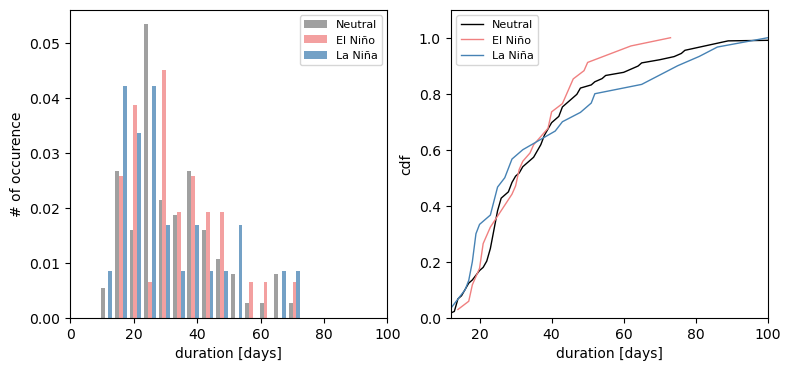

PyObject <matplotlib.legend.Legend object at 0x7f9439428610>

In [13]:
bins = LinRange(0,maximum(duration_EN),17)

# histogram of total angle
fig, axs = subplots(1,2, figsize = (9,4))
n, bins, patches = axs[1].hist([duration_N, duration_EN, duration_LN] ,  bins=bins, color=["grey", "lightcoral", "steelblue"], alpha=0.75, rwidth=0.8, label = ["Neutral", "El Niño", "La Niña"], density=true);

axs[1].legend(fontsize=8)


duration_sorted = sort(duration_N);
data = [];
for m in duration_sorted
    cdf = sum(duration_sorted .<= m)
    data = vcat(data, cdf/size(duration_N)[1])
end

axs[2].plot(duration_sorted, data, color="black", alpha=1, linewidth=1, label = "Neutral")

duration_sorted = sort(duration_EN);
data = [];
for m in duration_sorted
    cdf = sum(duration_sorted .<= m)
    data = vcat(data, cdf/size(duration_EN)[1])
end

axs[2].plot(duration_sorted, data, color="lightcoral", alpha=1, linewidth=1, label = "El Niño")

duration_sorted = sort(duration_LN);
data = [];
for m in duration_sorted
    cdf = sum(duration_sorted .<= m)
    data = vcat(data, cdf/size(duration_LN)[1])
end

axs[2].plot(duration_sorted, data, color="steelblue", alpha=1, linewidth=1, label = "La Niña")


axs[1].set_xlabel("duration [days]")
axs[2].set_xlabel("duration [days]")
axs[1].set_ylabel("# of occurence")
axs[2].set_ylabel("cdf")

axs[1].set_xlim([0, duration_sorted[end]])
axs[2].set_xlim([duration_sorted[1], duration_sorted[end]])
axs[2].set_ylim([0,1.1])
axs[2].legend(fontsize=8)

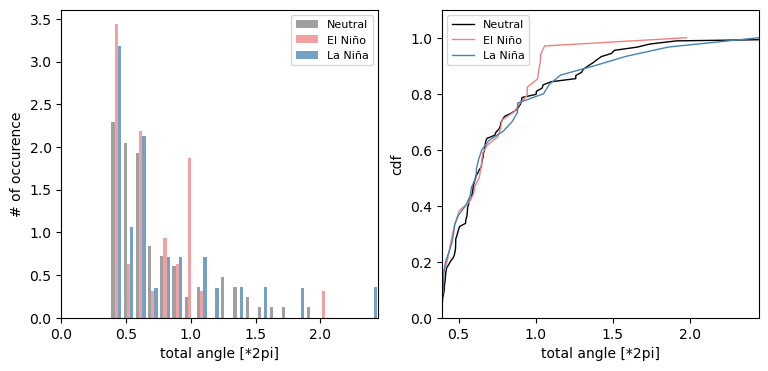

PyObject <matplotlib.legend.Legend object at 0x7f9438fa3990>

In [14]:
# plot statistics
bins = LinRange(0,maximum(total_angle_LN)/2/pi,27)

# histogram of total angle
fig, axs = subplots(1,2, figsize = (9,4))
n, bins, patches = axs[1].hist([total_angle_N./2/pi,total_angle_EN./2/pi,total_angle_LN./2/pi] ,  bins=bins, color=["grey", "lightcoral", "steelblue"], alpha=0.75, rwidth=0.8, label = ["Neutral", "El Niño", "La Niña"], density = true);

axs[1].legend(fontsize=8)


total_angle_sorted = sort(total_angle_N./2/pi);
data = [];
for m in total_angle_sorted
    cdf = sum(total_angle_sorted .<= m)
    data = vcat(data, cdf/size(total_angle_N)[1])
end
#percentile98 = percentile(total_angle_c./2/pi, 98)
#axs[2].axvline(x = percentile98, color = "black", linestyle = "--", linewidth = 0.5, label  = "98th percentile")
axs[2].plot(total_angle_sorted, data, color="black", alpha=1, linewidth=1, label = "Neutral")

total_angle_sorted = sort(total_angle_EN./2/pi);
data = [];
for m in total_angle_sorted
    cdf = sum(total_angle_sorted .<= m)
    data = vcat(data, cdf/size(total_angle_EN)[1])
end
#percentile98 = percentile(total_angle_c./2/pi, 98)
#axs[2].axvline(x = percentile98, color = "black", linestyle = "--", linewidth = 0.5, label  = "98th percentile")
axs[2].plot(total_angle_sorted, data, color="lightcoral", alpha=1, linewidth=1, label = "El Niño")

total_angle_sorted = sort(total_angle_LN./2/pi);
data = [];
for m in total_angle_sorted
    cdf = sum(total_angle_sorted .<= m)
    data = vcat(data, cdf/size(total_angle_LN)[1])
end
#percentile98 = percentile(total_angle_c./2/pi, 98)
#axs[2].axvline(x = percentile98, color = "black", linestyle = "--", linewidth = 0.5, label  = "98th percentile")
axs[2].plot(total_angle_sorted, data, color="steelblue", alpha=1, linewidth=1, label = "La Niña")


axs[1].set_xlabel("total angle [*2pi]")
axs[2].set_xlabel("total angle [*2pi]")
axs[1].set_ylabel("# of occurence")
axs[2].set_ylabel("cdf")

axs[1].set_xlim([0, total_angle_sorted[end]])
axs[2].set_xlim([total_angle_sorted[1], total_angle_sorted[end]])
axs[2].set_ylim([0,1.1])
axs[2].legend(fontsize=8)

#savefig("total_angle_comparison.png", dpi = 400, bbox_inches="tight")

In [1]:
duration_sim = [36.0, 21.0, 41.0, 103.0, 42.0, 50.0, 78.0, 55.0, 67.0, 36.0, 30.0, 37.0, 50.0, 140.0, 86.0, 34.0, 24.0, 81.0, 39.0, 40.0, 21.0, 43.0, 19.0, 43.0, 26.0, 57.0, 16.0, 47.0, 47.0, 44.0, 84.0, 39.0, 17.0, 23.0, 26.0, 25.0, 37.0, 38.0, 18.0, 41.0, 70.0, 28.0, 42.0, 44.0, 44.0, 70.0, 22.0, 48.0, 33.0, 44.0, 17.0, 47.0, 19.0, 20.0, 33.0, 80.0, 36.0, 37.0, 26.0, 58.0, 37.0, 22.0, 21.0, 122.0, 78.0, 141.0, 64.0, 33.0, 39.0, 47.0, 18.0, 54.0, 32.0, 34.0, 41.0, 41.0, 74.0, 18.0, 67.0, 15.0, 39.0, 25.0, 54.0, 25.0, 56.0, 22.0, 28.0, 18.0, 85.0, 26.0, 42.0, 42.0, 25.0, 34.0, 25.0, 39.0, 43.0, 40.0, 21.0, 17.0, 49.0, 96.0, 46.0, 22.0, 27.0, 18.0, 22.0, 18.0, 21.0, 111.0, 85.0, 44.0, 20.0, 55.0, 78.0, 81.0, 45.0, 50.0, 36.0, 42.0, 87.0, 48.0, 17.0, 45.0, 100.0, 43.0, 22.0, 17.0, 19.0, 20.0, 43.0, 60.0, 37.0, 36.0, 43.0, 39.0, 37.0, 94.0, 39.0, 42.0, 40.0, 64.0, 15.0, 59.0, 35.0, 61.0, 101.0, 22.0, 50.0, 42.0, 38.0, 41.0, 34.0, 79.0, 36.0, 16.0, 50.0, 57.0, 31.0, 19.0, 18.0, 22.0, 35.0, 39.0, 49.0, 46.0, 46.0, 37.0, 42.0, 47.0, 49.0, 48.0, 20.0, 29.0, 72.0, 40.0, 36.0, 27.0, 43.0, 59.0, 18.0, 25.0, 26.0, 87.0, 25.0, 70.0, 73.0, 22.0, 48.0, 38.0, 66.0, 39.0, 78.0, 37.0, 20.0, 25.0, 41.0, 43.0, 20.0, 23.0, 39.0, 51.0, 75.0, 16.0, 23.0, 17.0, 43.0, 22.0, 31.0, 23.0, 50.0, 68.0, 62.0, 40.0, 23.0, 17.0, 17.0, 122.0, 21.0, 49.0, 54.0, 54.0, 54.0, 39.0, 20.0, 19.0, 78.0, 43.0, 24.0, 54.0, 26.0, 37.0, 42.0, 29.0, 25.0, 38.0, 83.0, 26.0, 34.0, 39.0, 74.0, 19.0, 59.0, 22.0, 21.0, 34.0, 48.0, 30.0, 57.0, 18.0, 21.0, 44.0, 38.0, 20.0, 23.0, 65.0, 35.0, 53.0, 44.0, 91.0, 84.0, 28.0, 68.0, 19.0, 26.0, 17.0, 19.0, 32.0, 75.0, 56.0, 21.0, 41.0, 60.0, 72.0, 51.0, 55.0, 23.0, 54.0, 42.0, 20.0, 21.0, 136.0, 28.0, 46.0, 24.0, 20.0, 18.0, 34.0, 22.0, 84.0, 44.0, 25.0, 26.0, 43.0, 27.0, 34.0, 34.0, 46.0, 15.0, 18.0, 123.0, 88.0, 44.0, 16.0, 57.0, 37.0, 79.0, 21.0, 21.0, 46.0, 25.0, 104.0, 23.0, 123.0, 20.0, 24.0, 82.0, 115.0, 29.0, 44.0, 22.0, 27.0, 47.0, 44.0, 18.0, 30.0, 38.0, 57.0, 46.0, 38.0, 41.0, 19.0, 55.0, 84.0, 23.0, 53.0, 29.0, 40.0, 23.0, 64.0, 19.0, 45.0, 35.0, 25.0, 76.0, 61.0, 19.0, 21.0, 32.0, 73.0, 78.0, 39.0, 42.0, 155.0, 49.0, 38.0, 14.0, 84.0, 34.0, 53.0, 22.0, 39.0, 71.0, 15.0, 18.0, 45.0, 45.0, 39.0, 61.0, 36.0, 62.0, 23.0, 25.0, 98.0, 41.0, 38.0, 87.0, 41.0, 31.0, 26.0, 25.0, 29.0, 20.0, 35.0, 115.0, 16.0, 38.0, 39.0, 41.0, 92.0, 40.0, 39.0, 39.0, 49.0, 86.0, 43.0, 40.0, 41.0, 34.0, 50.0, 73.0, 60.0, 29.0, 35.0, 37.0, 46.0, 55.0, 23.0, 114.0, 55.0, 22.0, 35.0, 44.0, 59.0, 22.0, 16.0, 22.0, 78.0, 16.0, 49.0, 41.0, 34.0, 22.0, 70.0, 22.0, 19.0, 38.0, 36.0, 17.0, 49.0, 22.0, 35.0, 21.0, 77.0, 49.0, 27.0, 18.0, 58.0, 31.0, 18.0, 22.0, 66.0, 109.0, 13.0, 69.0, 26.0, 22.0, 42.0, 23.0, 21.0, 20.0, 21.0, 47.0, 19.0, 44.0, 19.0, 45.0, 31.0, 39.0, 26.0, 42.0, 28.0, 37.0, 133.0, 40.0, 33.0, 23.0, 21.0, 67.0, 38.0, 40.0, 65.0, 35.0, 34.0, 21.0, 26.0, 22.0, 24.0, 25.0, 43.0, 18.0, 24.0, 44.0, 21.0, 21.0, 58.0, 21.0, 21.0, 23.0, 37.0, 40.0, 23.0, 21.0, 19.0, 24.0, 24.0, 23.0, 124.0, 33.0, 78.0, 29.0, 50.0, 22.0, 32.0, 25.0, 48.0, 21.0, 26.0, 43.0, 47.0, 40.0, 92.0, 21.0, 65.0, 51.0, 40.0, 21.0, 25.0, 17.0, 45.0, 25.0, 22.0, 19.0, 42.0, 37.0, 19.0, 24.0, 19.0, 25.0, 40.0, 42.0, 90.0, 53.0, 45.0, 20.0, 77.0, 37.0, 38.0, 44.0, 54.0, 23.0, 32.0, 35.0, 53.0, 23.0, 18.0, 18.0, 38.0, 86.0, 32.0, 20.0, 26.0, 48.0, 42.0, 47.0, 89.0, 33.0, 23.0, 17.0, 28.0, 25.0, 37.0, 19.0, 30.0, 71.0, 20.0, 37.0, 46.0, 69.0, 47.0, 78.0, 40.0, 20.0, 46.0, 19.0, 59.0, 24.0, 87.0, 57.0, 20.0, 33.0, 40.0, 28.0, 22.0, 55.0, 19.0, 22.0, 27.0, 20.0, 23.0, 28.0, 47.0, 30.0, 24.0, 24.0, 23.0, 24.0, 36.0, 23.0, 35.0, 42.0, 51.0, 33.0, 98.0, 21.0, 43.0, 47.0, 91.0, 19.0, 22.0, 24.0, 71.0, 42.0, 22.0, 53.0, 17.0, 40.0, 98.0, 101.0, 38.0, 36.0, 32.0, 67.0, 19.0, 69.0, 41.0, 43.0, 46.0, 49.0, 21.0, 48.0, 54.0, 18.0, 24.0, 20.0, 17.0, 12.0, 23.0, 21.0, 23.0, 34.0, 38.0, 22.0, 21.0, 47.0, 38.0, 75.0, 20.0, 37.0, 22.0, 38.0, 17.0, 21.0, 39.0, 119.0, 21.0, 24.0, 39.0, 17.0, 17.0, 39.0, 80.0, 60.0, 36.0, 24.0, 20.0, 50.0, 102.0, 17.0, 35.0, 38.0, 33.0, 35.0, 35.0, 69.0, 16.0, 18.0, 44.0, 19.0, 19.0, 60.0, 40.0, 44.0, 22.0, 40.0, 79.0, 24.0, 39.0, 24.0, 68.0, 63.0, 23.0, 114.0, 19.0, 109.0, 23.0, 71.0, 99.0, 109.0, 53.0, 41.0, 20.0, 46.0, 42.0, 70.0, 35.0, 74.0, 40.0, 108.0, 81.0, 22.0, 25.0, 39.0, 24.0, 18.0, 55.0, 27.0, 17.0, 31.0, 39.0, 20.0, 55.0, 33.0, 39.0, 22.0, 70.0, 22.0, 45.0, 19.0, 44.0, 55.0, 35.0, 55.0, 36.0, 43.0, 22.0, 21.0, 47.0, 22.0, 46.0, 43.0, 68.0, 82.0, 31.0, 77.0, 31.0, 71.0, 73.0, 21.0, 120.0, 32.0, 49.0, 48.0, 19.0, 50.0, 98.0, 22.0, 64.0, 22.0, 19.0, 60.0, 40.0, 54.0, 50.0, 23.0, 52.0, 41.0, 37.0, 28.0, 37.0, 33.0, 25.0, 16.0, 47.0, 21.0, 47.0, 22.0, 49.0, 107.0, 24.0, 20.0, 48.0, 44.0, 54.0, 39.0, 78.0, 23.0, 52.0, 106.0, 80.0, 19.0, 41.0, 45.0, 22.0, 46.0, 42.0, 36.0, 22.0, 42.0, 27.0, 94.0, 20.0, 39.0, 18.0, 23.0, 47.0, 77.0, 22.0, 37.0, 41.0, 38.0, 41.0, 18.0, 52.0, 21.0, 24.0, 47.0, 22.0, 25.0, 17.0, 43.0, 20.0, 74.0, 34.0, 41.0, 25.0, 19.0, 54.0, 44.0, 47.0, 28.0, 95.0, 26.0, 18.0, 70.0, 43.0, 33.0, 41.0, 26.0, 80.0, 26.0, 34.0, 42.0, 36.0, 37.0, 43.0, 42.0, 42.0, 35.0, 21.0, 29.0, 28.0, 21.0, 25.0, 40.0, 42.0, 21.0, 23.0, 39.0, 67.0, 47.0, 39.0, 30.0, 27.0, 200.0, 33.0, 21.0, 35.0, 37.0, 51.0, 31.0, 34.0, 38.0, 27.0, 19.0, 18.0, 38.0, 54.0, 26.0, 22.0, 63.0, 19.0, 32.0, 37.0, 111.0, 79.0, 33.0, 58.0, 22.0, 20.0, 110.0, 87.0, 40.0, 42.0, 29.0, 34.0, 38.0, 45.0, 39.0, 76.0, 46.0, 34.0, 73.0, 36.0, 48.0, 36.0, 16.0, 42.0, 24.0, 43.0, 23.0, 53.0, 82.0, 21.0, 44.0, 33.0, 33.0, 71.0, 36.0, 19.0, 42.0, 51.0, 42.0, 64.0, 51.0, 22.0, 50.0, 39.0, 26.0, 23.0, 63.0, 36.0, 21.0, 85.0, 84.0, 52.0, 67.0, 55.0, 65.0, 55.0, 55.0, 44.0, 25.0, 42.0, 46.0, 34.0, 18.0, 80.0, 50.0, 46.0, 64.0, 16.0, 24.0, 37.0, 36.0, 26.0, 50.0, 27.0, 28.0, 89.0, 38.0, 26.0, 39.0, 48.0, 69.0, 22.0, 51.0, 65.0, 26.0, 20.0, 19.0, 26.0, 20.0, 18.0, 35.0, 30.0, 67.0, 43.0, 67.0, 20.0, 34.0, 19.0, 37.0, 44.0, 44.0, 48.0, 18.0, 62.0, 19.0, 35.0, 48.0, 83.0, 35.0, 19.0, 17.0, 17.0, 82.0, 72.0, 44.0, 49.0, 49.0, 21.0, 28.0, 37.0, 22.0, 79.0, 40.0, 48.0, 69.0, 43.0, 43.0, 60.0, 42.0, 37.0, 73.0, 56.0, 41.0, 26.0, 66.0, 24.0, 44.0, 18.0, 43.0, 56.0, 26.0, 65.0, 49.0, 49.0, 25.0, 50.0, 40.0, 22.0, 19.0, 80.0, 37.0, 22.0, 35.0, 60.0, 46.0, 21.0, 133.0, 26.0, 45.0, 77.0, 32.0, 45.0, 22.0, 36.0, 32.0, 89.0, 30.0, 38.0, 69.0, 37.0, 37.0, 68.0, 51.0, 72.0, 45.0, 42.0, 73.0, 20.0, 59.0, 24.0, 24.0, 49.0, 24.0, 45.0, 19.0, 72.0, 23.0, 56.0, 36.0, 19.0, 60.0, 152.0, 55.0, 21.0, 44.0, 34.0, 23.0, 28.0, 40.0, 15.0, 171.0, 22.0, 17.0, 25.0, 68.0, 60.0, 32.0, 46.0, 48.0, 34.0, 24.0, 14.0, 51.0, 38.0, 47.0, 20.0, 23.0, 40.0, 32.0, 63.0, 39.0, 36.0, 19.0, 19.0, 20.0, 20.0, 52.0, 52.0, 36.0, 22.0, 24.0, 73.0, 26.0, 40.0, 28.0, 17.0, 18.0, 62.0, 23.0, 44.0, 54.0, 19.0, 36.0, 23.0, 21.0, 53.0, 58.0, 23.0, 18.0, 61.0, 32.0, 25.0, 23.0, 21.0, 20.0, 19.0, 44.0, 49.0, 37.0, 71.0, 44.0, 48.0, 23.0, 25.0, 22.0, 34.0, 22.0, 23.0, 19.0, 36.0, 39.0, 18.0, 48.0, 17.0, 22.0, 54.0, 24.0, 51.0, 49.0, 19.0, 29.0, 45.0, 104.0, 86.0, 19.0, 32.0, 41.0, 41.0, 46.0, 67.0, 103.0, 36.0, 80.0, 61.0, 34.0, 35.0, 37.0, 62.0, 76.0, 20.0, 58.0, 17.0, 55.0, 33.0, 30.0, 38.0, 19.0, 39.0, 17.0, 30.0, 63.0, 38.0, 59.0, 61.0, 73.0, 60.0, 93.0, 47.0, 19.0, 34.0, 21.0, 47.0, 36.0, 28.0, 169.0, 22.0, 15.0, 66.0, 38.0, 20.0, 38.0, 57.0, 23.0, 41.0, 42.0, 19.0, 24.0, 78.0, 52.0, 50.0, 70.0, 45.0, 35.0, 59.0, 32.0, 41.0, 71.0, 51.0, 45.0, 47.0, 20.0, 76.0, 130.0, 25.0, 60.0, 19.0, 54.0, 24.0, 37.0, 52.0, 40.0, 96.0, 89.0, 21.0, 46.0, 44.0, 72.0, 85.0, 51.0, 42.0, 20.0, 44.0, 17.0, 16.0, 22.0, 45.0, 40.0, 47.0, 30.0, 39.0, 23.0, 42.0, 30.0, 18.0, 51.0, 22.0, 33.0, 24.0, 99.0, 18.0, 33.0, 53.0, 20.0, 36.0, 38.0, 26.0, 22.0, 93.0, 34.0, 36.0, 35.0, 37.0, 41.0, 23.0, 19.0, 59.0, 64.0, 70.0, 16.0, 55.0, 37.0, 18.0, 44.0, 50.0, 57.0, 19.0, 74.0, 23.0, 101.0, 50.0, 20.0, 72.0, 38.0, 22.0, 33.0, 73.0, 67.0, 19.0, 95.0, 40.0, 17.0, 67.0, 34.0, 79.0, 39.0, 42.0, 24.0, 25.0, 17.0, 20.0, 19.0, 36.0, 61.0, 23.0, 74.0, 38.0, 40.0, 33.0, 25.0, 33.0, 43.0, 96.0, 42.0, 58.0, 62.0, 39.0, 43.0, 26.0, 34.0, 37.0, 25.0, 42.0, 29.0, 31.0, 22.0, 54.0, 69.0, 77.0, 43.0, 16.0, 22.0, 23.0, 25.0, 33.0, 54.0, 22.0, 54.0, 17.0, 18.0, 22.0, 25.0, 23.0, 23.0, 48.0, 19.0, 107.0, 22.0, 20.0, 28.0, 41.0, 22.0, 28.0, 18.0, 32.0, 92.0, 47.0, 41.0, 37.0, 21.0, 37.0, 23.0, 96.0, 69.0, 24.0, 27.0, 78.0, 21.0, 25.0, 82.0, 69.0, 19.0, 19.0, 47.0, 38.0, 44.0, 50.0, 28.0, 23.0, 28.0, 35.0, 28.0, 36.0, 35.0, 75.0, 39.0, 22.0, 35.0, 20.0, 19.0, 37.0, 44.0, 26.0, 39.0, 50.0, 29.0, 27.0, 21.0, 24.0, 49.0, 62.0, 31.0, 48.0, 58.0, 33.0, 142.0, 34.0, 40.0, 65.0, 42.0, 40.0, 67.0, 28.0, 89.0, 15.0, 34.0, 57.0, 41.0, 46.0];
total_angle_sim = [6.135083062721986, 2.373474417235105, 7.739356647550062, 16.04792105534144, 6.193885386946449, 8.426648517616586, 13.065393931874295, 9.068617859437628, 11.944778773536724, 5.242703762745598, 4.34312352783911, 5.957029085776702, 7.753777036303427, 23.26427266614538, 15.065297459586837, 7.113014315862365, 4.003322072570247, 14.897424618580713, 5.091870753733319, 6.633156235712961, 3.0281608022209143, 7.47765505086459, 3.161504957955443, 6.351088000147779, 4.303102938861728, 8.195477225205842, 2.551349514482653, 9.800206950174037, 7.2613051378115685, 4.332391523856483, 13.684088347297587, 5.119301396986247, 2.6071195789993356, 3.6967699710080377, 3.912292751625328, 2.935214920570991, 6.99583232179048, 5.9568265422671445, 2.681062740819421, 5.297976069976761, 12.192828176957137, 4.059482763349181, 7.241888036880968, 6.604755092319151, 8.426514164680846, 11.030085417694137, 4.054951260135879, 8.014412811747373, 4.437234135740943, 7.693717378110678, 2.8138922058937976, 8.870077004283448, 2.9832416087835876, 2.3852461297106737, 5.771624084128105, 12.758334789731409, 6.117698079287091, 7.00731543846405, 4.608582989849127, 9.619530351638945, 6.007950946934725, 2.6972168662063294, 3.776105021005942, 19.008254582200355, 12.735140742472908, 23.394019606187758, 12.17695677855685, 5.709061312392507, 6.917294548302067, 8.860937468850135, 3.0259628697468317, 11.376265309930837, 6.127204756723454, 4.810382523723786, 6.796997511861749, 7.542740592417887, 13.046111670939926, 2.38763548627604, 11.721406361180813, 2.69895470137236, 6.716189459857273, 4.460616101646242, 9.358132250275826, 4.0522048317218875, 9.393768454793697, 3.9125139198090753, 4.625189766660561, 2.5564136755711173, 13.810262251982026, 3.9816732658483116, 6.056703142058552, 6.9674173611124335, 4.525325163294633, 5.780255073637738, 3.569530973364557, 5.778553370009174, 6.350404007469044, 6.406897899989495, 3.7525115049423703, 2.6238026047131235, 7.103922735708212, 17.566380146956263, 6.858667215338145, 3.34509911412542, 4.092480993439068, 2.4665036403644116, 3.1592721001843502, 2.5450109399156418, 2.501394048257037, 16.14157526245241, 15.322908731599997, 6.176628627819518, 2.821787901121479, 8.362240337577541, 13.710871779141959, 16.408523891812433, 9.090785019122958, 7.731096026616446, 5.588855690548207, 6.395506536953791, 16.338341587000052, 10.848978409880297, 3.2372234448026105, 6.612129946009848, 15.623527145171597, 7.047259164758108, 2.855442837023923, 2.3735885559388596, 2.8094145057277125, 3.5130621402093443, 6.196145331815821, 10.00354473221445, 7.540194028862733, 5.984181483002251, 6.816737552020786, 6.36704214467188, 5.1589757330046035, 16.580621013739023, 6.098710227750241, 6.8488729985867, 6.358994130741952, 11.847557051978512, 2.6923948292691597, 10.404694896313439, 5.690263131825344, 10.448851555719704, 16.420708473020195, 2.8992762172913173, 8.671376564798074, 7.340112419304284, 6.804960150401165, 6.045316170882925, 4.104614544038245, 13.514453883224968, 5.243168003552768, 3.0268463921848934, 9.428994839811757, 8.314776896695605, 4.836127636855071, 2.7795181093427224, 3.1965738060285096, 4.86903928503574, 7.091136654807663, 4.94003903394704, 6.447397989358321, 7.391727304306754, 7.06520984327058, 6.889568515631216, 5.628829829539622, 8.510537618424467, 8.526687988581584, 7.0515580011578605, 2.389330711463914, 2.7502613445119977, 9.166736177530264, 6.2046264272429585, 6.214803753782287, 4.401013915503326, 8.141245738855352, 8.582585162898841, 2.367361047358881, 3.415135126424005, 3.610431072062134, 16.394810911753908, 4.559744249105977, 11.766801650598058, 13.844286092820198, 2.39761481118671, 7.944509241109928, 4.454912986405338, 10.642461083504067, 5.919070086675562, 13.59068784724733, 6.138789581015555, 3.8571140615088826, 3.783525316782984, 6.082499016614987, 5.520491357634758, 2.732503750051142, 3.8808020470571805, 7.069526030008559, 7.861113989706276, 12.214122575171585, 2.549724165261159, 2.705505378204651, 2.8682487560172536, 8.305716738693055, 2.4474766365438345, 4.666630066502151, 3.2556243272620424, 7.540215774223536, 12.264932875693262, 11.892611824178058, 5.825700839568013, 3.093541536503029, 2.403576347380578, 2.9243946219204133, 22.397909620253706, 2.742581986913613, 8.33278019292641, 8.41153904113334, 8.530999341221852, 8.727083205390414, 7.263841386062437, 3.2304469153972533, 3.0103367691401264, 12.519346881522782, 6.9142068422114935, 3.464459728438246, 9.325382373304354, 2.805087635030039, 6.32616766553701, 7.607090140522423, 5.38386659876534, 3.5559376252009285, 6.2789059735424235, 15.13421653349016, 3.6280863113540476, 5.099352939738597, 5.596999964691489, 11.114790673814877, 3.1820831527081985, 10.037980137267494, 4.297748702927853, 2.796014885658432, 6.321259419112463, 7.502517481961016, 4.611506042412403, 8.764137706634298, 2.5130605740192875, 2.6484199083765834, 7.1452754147347814, 6.197755364639128, 2.3747269544182448, 2.969571206649868, 9.599236329606647, 5.271131007298192, 10.163751954730385, 6.851157175222821, 17.981061577900896, 14.151393121861116, 5.1871697530131655, 10.247897005179741, 2.373861839345091, 4.12816667627027, 2.807359147902035, 2.3722049779904317, 4.1549105062220795, 12.53787624377548, 7.510599891054438, 2.4295138861116308, 7.3595871885450155, 10.25764120092759, 9.686795496908063, 9.128212999573135, 10.73544298373602, 3.1688872488539763, 8.577264012363601, 6.822169850492989, 3.0435881982129818, 3.079131597305283, 24.59578164168673, 3.854504326554915, 8.111747930505901, 3.113760353082868, 2.8742322319099776, 2.5393384066075044, 5.658682569906976, 2.55143241243294, 13.477433369583414, 6.982935481859483, 3.6563530885134345, 3.7067042601978226, 7.652094551628098, 3.858904497834991, 5.36228478541342, 5.240994798147529, 3.94166073269695, 2.462912587580191, 2.797977285021555, 21.404565655721054, 14.501679949505274, 6.1408922370579235, 2.645117482087117, 7.994997002104813, 7.294691982779428, 14.542283906513777, 3.4972614657625494, 2.8729992105469853, 7.388729374959121, 3.8480782532968467, 18.49854591151674, 4.016364023053516, 22.434417245082376, 2.3780471581764506, 3.7221410703765816, 14.703903362079418, 20.545896541163195, 4.849745524831533, 7.035986705095505, 2.9190033078190494, 3.549552911196974, 6.739313220066959, 8.107649456353354, 2.506245110962249, 6.149546459921851, 6.16761584960204, 9.524395059894834, 8.300041265834349, 5.164632201303354, 6.297796273415018, 2.506567596519946, 9.103013882154526, 12.482474253813196, 3.055918329584996, 6.291777115691268, 3.959415362819538, 6.651373128070495, 3.297217713623776, 10.682852698012706, 2.575855270396434, 6.615110110208273, 6.435517500566389, 2.7371864867713094, 11.107357861528556, 13.510855886284917, 2.6520885540830808, 3.6447826766642577, 4.731209076162576, 12.323068372328672, 13.285048459856675, 7.432713207878541, 5.728039135044296, 19.64793336133374, 7.495411036931475, 6.0759122081096315, 2.6189409398941947, 15.177498454841247, 4.515800619486874, 9.63775124669657, 3.5825082895412472, 6.718930758380888, 12.117768965116728, 2.4476003395668844, 2.563256229026974, 7.0118451221564335, 6.681870334946781, 6.2354426711595, 10.86279966517889, 4.744527887290618, 9.774200071110966, 4.050759202457504, 4.017045392899037, 16.10981544063463, 7.477193357786913, 5.539264664062433, 16.00661767629468, 7.327854020212712, 5.194354337202817, 3.427853644183467, 3.195874431655461, 4.938699950986792, 2.7058063735308413, 6.3688513282260555, 21.29018516754433, 2.4532593156636877, 4.04594941551964, 4.80509716518042, 6.236909266855362, 15.215275282744457, 5.759986279885601, 7.52230850220214, 6.274087622492237, 7.209958150446221, 13.695489666312522, 7.562437719867895, 6.296030796163192, 6.282052261465977, 6.25189340263281, 8.541604417969872, 11.980453639799524, 11.672304175468039, 4.770543790041376, 5.90220877084352, 6.374793142379518, 6.983033466929882, 9.106099504369912, 2.393003790525449, 19.080835387003695, 10.266964595384815, 2.8457491676375932, 5.982857176608506, 6.326387465549057, 10.001897135229285, 3.3461079750110008, 2.5277192505749384, 2.9860988115012055, 13.029361920623753, 2.6153717914606682, 7.210836344359338, 5.7812434068724485, 6.224625822032616, 3.0457213823083786, 11.887187605428487, 3.5465469475268527, 3.3394147600970805, 6.781844735193738, 6.190773993155986, 2.6584906517387026, 7.917164226434795, 2.8482256387604568, 6.381966658261965, 2.846523531353548, 11.010070333067814, 7.312598456466182, 4.443244654784162, 2.502692571434026, 11.754745068839032, 5.182535188683747, 3.0914490995797093, 3.376168363565436, 11.197682898231585, 18.856130834868445, 2.383053225131442, 3.884915016308451, 3.7376205107557596, 2.393424118000464, 6.372068665360622, 2.968399856516247, 2.5521067294945468, 3.067318195150709, 2.963722453229967, 4.921115821056713, 2.5076882850615236, 6.8119941934907775, 3.004677043448818, 7.171764165429931, 5.079041548509162, 5.720451074588276, 3.683509894741398, 7.467688056985206, 5.5480699810572025, 6.126432570679625, 21.773567390213127, 6.089492331949575, 4.0259119912495045, 2.9668391076164107, 3.038003276697733, 13.137736422696957, 6.57708720053451, 5.482987666640543, 10.86240674509788, 5.571235686623631, 5.980517534168474, 3.0598107944885116, 3.065316713994276, 2.919694194470585, 3.0737468841775977, 3.290250128977249, 8.19232433312778, 2.4393127610799357, 4.085628437969078, 7.447319763263836, 3.7420621574490736, 3.0989387123877385, 9.745466595072738, 3.7074188083472563, 3.269134147160698, 3.9451644779400996, 6.1521798063097615, 7.0630915673236405, 3.8579101468102177, 2.6859657340564898, 2.4231001596594686, 3.396782087254827, 2.802761308569161, 2.65096367927062, 18.991732731566813, 4.576460063856858, 13.95935967065131, 4.307945387640855, 8.651528352580737, 2.8813057219138964, 4.897021871787961, 3.1779902242648, 6.939559806545336, 3.92023335983988, 3.551529825983964, 7.514920284187094, 6.848504636847579, 6.535684641400227, 13.955882628363092, 3.2286320696551236, 12.76217214380124, 6.631838099245341, 6.5289589869634685, 2.601503390766733, 3.4425033243889778, 2.4115715956190007, 8.098725216358776, 3.2037417493015163, 2.416047433493766, 2.7805376899122285, 5.348013623935503, 6.122151724778543, 2.8772496848038793, 3.4244521941594734, 2.690263640979403, 3.7199680017952215, 6.5701550198848455, 5.890308005813864, 14.987087841209526, 7.7254967918966795, 8.01000797881289, 2.7538695237490876, 15.965877681251706, 5.740586077973412, 6.23694049088073, 6.929877317777066, 9.736378457459445, 3.565601610463474, 6.076692807750293, 5.581911889077521, 11.10693411146116, 2.4865960693149636, 2.79976686849321, 3.2292499047692886, 6.098684908528159, 13.01985486206268, 4.227475146862239, 2.7360877578495146, 4.245005605775802, 8.95668334433665, 6.330545687400971, 7.339118919451209, 15.012557178602119, 4.6121938577169015, 3.3058929698020614, 2.4101043529634127, 4.0456527537112095, 3.7374885072218675, 6.286396886496652, 2.5285948452579436, 4.418699690509398, 11.039590056023926, 2.712071205275709, 5.992010368982217, 7.582231090364395, 10.901166481374112, 10.429097684196982, 11.315230293341532, 6.0706631400772775, 3.003537475523787, 8.674474923469486, 2.9096986734949812, 8.557531197421524, 3.960725866885605, 15.040714410757001, 10.313628305142643, 2.4713643296498167, 5.477965604061527, 6.369188389923558, 5.541365283580968, 2.4992238786161947, 7.914916040460621, 3.334708686776285, 3.4988238399758282, 4.1297539318980965, 2.8462250639681503, 3.6345148553375988, 4.571850677356097, 7.764259505518273, 4.798364544613253, 2.86350041664829, 2.9346005732870823, 3.725134427795412, 3.5546493604525735, 6.436975300697892, 3.162099094763116, 5.948352790210321, 7.779359747424516, 9.08010905937186, 5.07367619466372, 16.3796185157198, 3.682414280960378, 6.92557179535035, 7.201454411916611, 14.683340745178523, 2.4156365405706772, 2.503178273239295, 3.8067293768776898, 11.871669531849628, 7.484681919399111, 3.4161950586547345, 8.084062100142138, 2.6392625625794413, 5.4197379438842255, 16.37080359811976, 15.92917669561288, 5.522379715254503, 5.3819118751160016, 5.680474574535646, 14.49396212101406, 2.601669928850707, 11.213490230512779, 7.239492422616421, 6.083549568827009, 6.1714765961479365, 8.42515662875212, 3.899102428358488, 8.537160554303323, 9.717302666344109, 2.8221781046060403, 2.6027348306969187, 3.634412401210425, 3.1142760345046945, 2.4670275741179504, 3.477970435424494, 3.4460301037527556, 3.6591173272559647, 6.12493921044028, 6.415871557052243, 2.876638339831061, 3.561267057722107, 5.846601916912964, 5.666970585635944, 13.239780742435773, 3.1179886686564573, 6.0814664648475585, 2.6279583164836327, 7.310368176979715, 2.823891842953756, 2.7352222882090884, 7.499335582727051, 22.11172521336219, 2.664462442838925, 2.771665917907526, 5.712405056442467, 2.6593312998775644, 2.5247556755426253, 6.576880069581247, 14.291418418924046, 11.582636908083423, 5.981455052056047, 4.132960894244288, 3.1842132209151366, 9.449453303177798, 16.547086662190004, 2.779794806745585, 6.082718794323451, 6.496643652474264, 5.111839379761163, 6.769332756129363, 5.712984134510782, 11.242506424137423, 2.9819154019953036, 3.3284756509857782, 5.315484511443452, 2.468169657687932, 2.6151156360394827, 9.703489098448433, 4.787830598039459, 7.623594647915691, 3.311563365787382, 5.816488498510196, 13.17465781174128, 2.5971345277411637, 5.253362872705656, 4.499011712679659, 9.526786754099945, 12.793929735502648, 3.4940775760205596, 18.684904070022768, 2.4316189574620424, 18.286038122165063, 3.394309819078008, 10.689579942646379, 17.222918875254344, 20.290399099728706, 9.191799821952877, 6.828129230471376, 2.5752392453780235, 7.769897512762193, 6.264831407895263, 11.511697271000068, 5.742911671577264, 11.81781348891766, 7.588255706055174, 16.056202805132397, 13.392015386047486, 3.5546692728827414, 4.76578192102132, 6.553529792291927, 3.6004965554002064, 2.4706517153910608, 9.88288479057178, 4.56998700712931, 2.6486035196877076, 5.219318489358437, 6.6518200873732285, 2.483885969769179, 8.686937411166618, 6.0535922065464, 7.272563488123696, 3.8102828842379783, 12.713978768231973, 3.4196095620902893, 7.204590109465387, 2.794075450934088, 6.1734995788853615, 8.64552657515214, 5.1420232236446735, 8.083987859364536, 5.7042454992705505, 7.42383910811459, 3.138032018459494, 2.7698505933696165, 8.767174752855027, 3.1577440398034584, 6.982352062856405, 6.408012188817544, 11.099723026980897, 11.394451216700173, 4.454118253520557, 13.75179066225359, 4.632639993685792, 10.65304325245779, 10.733022913681868, 3.1513552290658993, 22.65847929470644, 5.716275618010301, 8.642677471644877, 7.939264133964093, 2.4057086535289036, 10.210517482731955, 17.475784247069083, 2.9759126516374894, 9.67754952681088, 3.4888458239635582, 2.9436320701485323, 10.13207700182833, 5.395499408511161, 9.147902773463448, 8.353392741070788, 2.9268966379836643, 9.521697494923592, 7.547037969052323, 7.0742601284677535, 5.526241466458, 6.778131051488507, 5.641778433599364, 5.280481200105495, 2.6161358527913623, 5.072790402017504, 2.621478925718491, 9.807211825531649, 2.9427671146213767, 7.645382656887158, 20.210330228458037, 2.3752928003748894, 3.241213858730711, 6.917381324619469, 7.127943266304714, 10.76597146860082, 6.24191439160461, 11.494492632248216, 2.5028478884141987, 7.728219139595957, 21.972231148234933, 12.656185965170351, 2.423735582775077, 7.288531421010057, 7.23476369700134, 2.687241818204619, 6.6501297105557455, 4.826665235099523, 5.537251121242843, 4.271949818821972, 6.066992432650046, 3.114162264394071, 15.40797058033123, 2.4757071125044052, 6.471416718043699, 2.464778267107053, 3.6504404769668244, 8.029965688853652, 12.61512832826892, 3.910838321614776, 6.663449100312358, 6.171372613012194, 6.778174220561751, 5.585874119597525, 2.7211340198439697, 9.239924452561244, 3.3208227418691605, 3.3191947682153047, 7.214324060203844, 3.14193274459611, 2.5235760167410892, 2.9056069655317165, 6.097845886461486, 3.046889766458644, 12.306713347863857, 6.501628236527904, 7.195729048501528, 3.286577647831912, 3.296266628193196, 10.04283381759339, 6.394211941110724, 7.364279120071991, 3.5247451150251132, 14.993735787890495, 4.876282899885128, 2.993444933899175, 12.0079554597917, 8.669049820922776, 6.679224694836814, 6.1967721764217, 4.379636673911634, 13.696247351000084, 2.502011551834932, 6.163538295815554, 7.101041194019272, 4.923470518822932, 5.886681718638631, 6.80150640590843, 6.883099989484453, 8.414660858856832, 4.585371722082495, 2.5769376026310664, 5.297715945668633, 4.786436551096701, 3.3615157292314923, 3.5571317278909245, 6.050342841946489, 5.1427128447958435, 2.7701772860975877, 3.9765250503186804, 6.124543421542357, 11.630316591693575, 6.14845051162706, 5.089979796112068, 2.471367928979977, 4.074334908765559, 33.606019537133335, 4.652760395179533, 2.4914717563363404, 5.20894795318161, 5.1502107939560595, 7.16393079628826, 4.118998300380801, 6.257443251187416, 6.19340614210009, 4.869442890269719, 2.9748153159731205, 2.5199815900001954, 6.487321719994364, 10.617492437295049, 4.818694516806906, 2.8061817752648905, 9.58604058891809, 3.2099682214509375, 5.099806296503884, 5.6806610405713265, 19.29776506490094, 11.342674502639914, 5.150023910274472, 8.938340535478773, 3.053536284006978, 3.40672853099284, 19.6540069526377, 14.34727556189394, 6.1276026248521145, 7.114563333106403, 4.483820853582673, 6.234681560908412, 4.8059617701275, 7.44581853396358, 4.964819876793363, 12.840710902956978, 7.256713198994112, 6.983657232145722, 11.502316384036472, 6.679619241123914, 8.482582982040325, 5.909558453339116, 2.6607711217401357, 7.42023742003794, 2.740264317993831, 6.304155283584647, 3.8161973920767682, 9.091129298674067, 15.38457059467358, 4.088969213789889, 7.360732792727568, 5.954554889037135, 6.115612338333609, 13.083830506659108, 4.471345147824524, 2.9354976265678836, 7.59350117806888, 8.432538034269552, 6.455622543493602, 10.754897822444894, 7.831207807454504, 2.3947711553432196, 7.415303480886162, 7.12821915758339, 4.28698687285622, 2.809303780722385, 10.574697341892247, 5.537020924141698, 3.026512688204586, 14.868143645789164, 15.188288425033178, 8.699678364885989, 11.873377146041317, 9.235411067183533, 11.079965597486696, 8.791411165685572, 8.88859069334579, 5.8592235830379735, 4.5778243147795, 7.561207169650662, 6.705760932786012, 5.586800863988897, 2.460022692387429, 12.059161271173714, 7.316817927987946, 7.680791077615057, 11.353084989378495, 2.8801025740840376, 3.7752648598442375, 6.0026485069813855, 7.026092726952514, 3.509127504370926, 7.1108806052796405, 3.1424781146989966, 3.669969765855533, 16.731928466882398, 7.183024267838194, 5.097173694304124, 5.112467942261414, 6.999017422112425, 12.788895058540168, 2.9005145428482084, 7.538680469904464, 11.109749660473653, 3.9712854552544403, 3.1401068487349555, 2.49523856777217, 3.1033366217848446, 2.403868495657756, 3.041618210752455, 6.149984849558717, 6.218686525011609, 11.261426625601832, 9.008046150089253, 10.545231435657685, 2.7282553970183816, 5.586107671029593, 2.4202260191059155, 5.527634018047166, 7.144621551414433, 7.789888915107926, 7.062717123169652, 2.502669055131558, 9.575407731467468, 2.387691153444681, 5.3313040015608735, 8.362196981207106, 14.941221215031248, 6.176410027982117, 2.774917331069618, 2.5612536042775775, 3.0950683323084283, 14.050984562497648, 11.967678964542301, 6.0491514647963545, 7.7876809406523275, 8.854463385444546, 3.2386739229084176, 3.9955509690558113, 6.381645228057077, 2.913603050667388, 14.556194227733185, 6.614069910915216, 8.519567104292259, 10.7170832222282, 7.294793643593026, 7.101142558270844, 8.66610871273884, 7.457976091150816, 6.542263510632402, 12.336796371595193, 8.585099860901014, 8.044933517629447, 3.8998781872887966, 9.4705303449689, 2.6545333326277456, 5.438897915655748, 2.6192578747300463, 5.919127803168466, 10.64839996161691, 3.417666530155179, 11.254278690666307, 8.190489191630158, 9.509433872232274, 3.7276076838621206, 7.626198102984365, 6.649487097209243, 3.4286288249644783, 3.2136681278226593, 12.154834057163866, 4.939536937823666, 3.2414060924964736, 6.192565163938463, 12.02540378183814, 5.359163900927999, 3.496571623728902, 19.319395012753105, 3.371914267029571, 8.235059825897498, 13.053762679097524, 5.407337775392563, 7.600220527045523, 2.490063271388236, 6.081839120662665, 5.074497894336148, 15.114056135318398, 5.603993444658337, 5.919682573286306, 12.412854459709113, 4.742633957998417, 6.112981175700484, 11.323408518802479, 9.305959722115617, 11.670061634097657, 7.9226337955738675, 5.6033629362406865, 10.928697473294562, 3.117488602861642, 10.594223534131439, 3.1063866886922096, 3.15699969784171, 7.732189354813482, 3.1965373078277306, 6.448228714582876, 3.1013188023279734, 10.031326557681203, 3.3451289262097923, 8.59420464310256, 5.746936852024926, 2.8843015387634727, 9.27866156433538, 24.930412051538386, 8.491046658394907, 3.2711262939326824, 8.839167720299892, 5.395854180813342, 2.951632725375898, 4.742770623089962, 6.685052018655892, 2.411292383775355, 32.600888551465665, 3.7196210223066237, 2.446415543896892, 3.260081223107074, 12.645098943669884, 10.00384606866346, 5.426699008101716, 8.936452604181031, 7.834076680876248, 6.727129100293506, 4.773425347751955, 2.4378393701905803, 10.248914121476393, 6.19661233521833, 8.432229444876604, 2.7710903512969876, 3.2808770950728756, 7.746757885067227, 4.914054045908983, 10.417384244259386, 5.92836196167559, 5.243789722735425, 3.445866291559855, 3.3018322213601876, 2.736633855451603, 2.5457606271934186, 9.895365916775281, 7.436244803912182, 5.641551513248925, 2.4187229397285006, 2.872039060976194, 11.372534346969221, 5.084500812638129, 6.178252709277867, 5.444166163265676, 2.764534635830065, 2.7895808488779164, 10.167912878091048, 3.049864323304355, 7.779180791712307, 7.9186193418794595, 2.627349960545243, 6.2921993886135095, 2.3842549735225314, 2.4847655627742493, 8.551269862148791, 12.388688424201813, 2.703221051470739, 2.5407800565797882, 11.005213763623484, 5.364403511031291, 5.136547041840586, 2.512003823641428, 2.4746990171815693, 2.4908952591369076, 3.1674572189187087, 8.09633213015589, 9.253193009951417, 6.102679696032348, 12.015753412930268, 6.950409844900155, 7.028678567595789, 2.694586998062154, 3.9296927864089843, 4.045696231870028, 5.785361003277406, 3.8495437137021224, 2.7265679516094647, 2.5215401291945296, 6.0054062868240825, 6.338300460525266, 2.4271564221347597, 7.3222095767791195, 2.792991891445019, 3.216957823368344, 8.016428603349762, 3.236314571944532, 8.20110521334891, 7.150461890906403, 2.6712256102791203, 4.586564954125826, 7.509547857369816, 15.466791534186035, 13.627729353097234, 2.686359651235356, 5.058431916061723, 6.606101277927774, 6.486536404868704, 7.189943009664272, 11.502134341058921, 15.99633138104344, 6.644280644528192, 14.17367805071999, 11.653268697453752, 5.56416522801957, 4.9424767968404435, 5.189868258524313, 10.865879013852918, 11.940021000235475, 2.7352334276624655, 9.060851771200873, 3.098549425177775, 10.726040364902733, 5.077456427457444, 5.5718022290578695, 5.613218440147978, 2.584365037656421, 7.199195570923066, 2.672589490591001, 5.593028806975266, 8.982644244888201, 6.572456891799627, 10.794478572187366, 8.79446772173472, 14.098475903597969, 10.973939906045025, 16.781024232385423, 7.507296436399263, 3.760065394611714, 5.850496365125354, 2.969757650410929, 8.341761814340533, 6.127469842708939, 4.281489075510795, 26.703373483727955, 3.2282286811834697, 2.421042650921741, 11.986530277375177, 5.6978047291568075, 3.4064106806125576, 5.977463547648246, 10.807156298472288, 3.1884122283881386, 6.503181329392703, 6.078529401691261, 2.565097877247942, 5.044866210928464, 12.124540036655555, 8.145594141593493, 8.47037480578338, 11.76629303508983, 8.788310749612842, 6.012076403795161, 11.193708709343893, 4.300609393899729, 6.876939859029877, 13.407183930501713, 7.702932592878989, 8.86545554681315, 6.33088145134852, 2.47831819071264, 10.35232517698176, 23.539547580836558, 3.4748826197091125, 10.05626944048138, 2.4469550326553016, 8.745797313994515, 3.6007245719814387, 5.101533121595953, 10.508615403554668, 8.244144313243027, 19.288737004018046, 14.733109322785495, 3.7968655126590116, 7.935649668186276, 7.488924666328338, 10.674887354899571, 16.43956032122682, 9.127353346673672, 7.342017107489183, 2.9327492353181097, 7.01722594156675, 3.2120593455647874, 2.4723376736565545, 3.047783511602494, 8.07485877619143, 5.417914433912077, 8.050171037204894, 3.622183027125426, 6.058247266815312, 3.231496904365318, 6.823687280035427, 5.250411081701021, 2.520045295681321, 7.792409444489621, 2.4759337181921164, 4.869791666799252, 3.0216553358172336, 15.983770675120045, 3.271760875912691, 4.663980431837333, 8.842614527970195, 3.2891930149986774, 6.442107922718049, 5.443683263816885, 3.9684667003578165, 2.973037575273357, 15.397429659240016, 6.420956409901904, 5.050537842598658, 5.436640108302663, 5.404231356223128, 4.765556588845024, 2.4672222397443964, 2.4881358854582487, 9.923097292539167, 10.043982645492353, 12.467506405378648, 2.386618572865978, 10.277063918371539, 7.468454776945495, 2.57847930036287, 6.70212283199306, 6.365636711447172, 10.06689972311094, 2.834589782170348, 13.258822906271602, 3.876081740337422, 16.64367495585037, 8.281428211526654, 3.2090026415953936, 11.643997363963413, 6.123303184815194, 3.486144247871551, 4.707467476976307, 14.000989511252177, 12.462818587071485, 3.058231645250089, 17.83957783133468, 7.011951369583451, 2.477234794137879, 11.695906893737616, 5.514019420366646, 11.810347412889275, 6.412547103075265, 5.254239826537539, 3.766091709397694, 4.002756696381218, 2.3642976142527914, 3.3958525827761554, 2.425451384880005, 5.553257262819767, 10.48597919306282, 4.022587546493158, 11.245508509933693, 5.790319092572548, 6.794584293463149, 5.334403258774959, 2.8600628655754616, 5.2938149339710066, 7.9331274564830006, 14.801624274432045, 5.978222636920764, 10.109035798362722, 9.580769497942274, 5.290571701509544, 8.3366898891743, 3.779044600199998, 6.058677129816896, 5.120778351517657, 3.5310872101064543, 5.826081937420028, 4.785526561951755, 5.631535743349201, 2.6860271396382425, 6.489437746583054, 11.703767280973333, 12.330618850219022, 6.869672097418742, 2.7459930235223804, 3.2371039261199632, 3.950110581305789, 3.7441643453060376, 5.034927842566434, 9.132959349897833, 3.4667759303284438, 7.961872639647206, 2.4028385608463854, 2.972509867148997, 3.5778643464274706, 3.2968282348242752, 2.830259998586934, 2.5602916371590156, 6.2435083944548335, 3.1315717104237644, 18.721946580433027, 2.534142927825271, 3.2492189446622066, 4.863888513259382, 6.819984580630391, 2.9879634349195547, 3.333207381330076, 2.5812958183968147, 5.939256722939543, 14.896389802043828, 7.840367710231835, 6.505305484992589, 5.338285313307982, 2.982138918680209, 6.479853390155936, 2.826340963165867, 15.05552350755939, 12.128019064561327, 2.702882160284849, 3.1820128422973344, 16.30720865633575, 2.5762295753373636, 3.3422249572810645, 12.335528575446109, 9.7134411605199, 2.6793387720799826, 2.981745141201841, 8.567441379419797, 5.9571389499545955, 9.027671524013599, 7.786882460439536, 3.286401647121165, 2.5688818132981455, 2.993022706927344, 4.9629407389015, 4.686260146603235, 7.277703191123836, 6.344148937306228, 14.274562313455306, 7.04452693106456, 3.1835019610065896, 5.241481844002539, 2.792876308276429, 2.7168284298966827, 6.296280150031668, 4.601513485985812, 3.870919760334174, 5.148549470740504, 8.902166388967975, 4.518875034723319, 4.7919027664185, 2.9542481052771548, 2.6634067848439775, 7.607888465145388, 11.393067863766444, 5.443268868458078, 5.027449681612057, 9.748202320286754, 5.968371335399206, 23.73481237894546, 6.321318779381022, 5.943978758319028, 10.515131865242267, 6.288066080874879, 6.282093440290216, 11.59108812928511, 4.601695027489445, 14.835097440504862, 3.0437222867142, 5.93177248144089, 10.24695799704333, 5.755980078900072, 7.214632369013508];


In [47]:
mean(duration_sim)

41.95977808599168

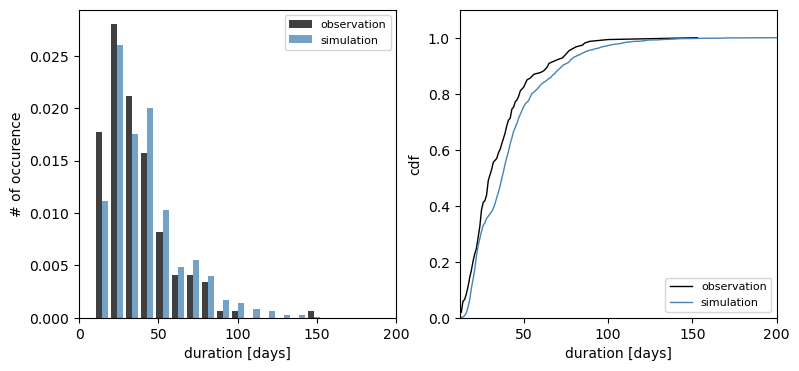

PyObject <matplotlib.legend.Legend object at 0x7f9438fa3910>

In [15]:
bins = LinRange(0,maximum(duration_all),17)

# histogram of total angle
fig, axs = subplots(1,2, figsize = (9,4))
n, bins, patches = axs[1].hist([duration_all, duration_sim] ,  bins=bins, color=["black", "steelblue"], alpha=0.75, rwidth=0.8, label = ["observation", "simulation"], density=true);

axs[1].legend(fontsize=8)


duration_sorted = sort(duration_all);
data = [];
for m in duration_sorted
    cdf = sum(duration_sorted .<= m)
    data = vcat(data, cdf/size(duration_all)[1])
end

axs[2].plot(duration_sorted, data, color="black", alpha=1, linewidth=1, label = "observation")

duration_sorted = sort(duration_sim);
data = [];
for m in duration_sorted
    cdf = sum(duration_sorted .<= m)
    data = vcat(data, cdf/size(duration_sim)[1])
end

axs[2].plot(duration_sorted, data, color="steelblue", alpha=1, linewidth=1, label = "simulation")

axs[1].set_xlabel("duration [days]")
axs[2].set_xlabel("duration [days]")
axs[1].set_ylabel("# of occurence")
axs[2].set_ylabel("cdf")

axs[1].set_xlim([0, duration_sorted[end]])
axs[2].set_xlim([duration_sorted[1], duration_sorted[end]])
axs[2].set_ylim([0,1.1])
axs[2].legend(fontsize=8)

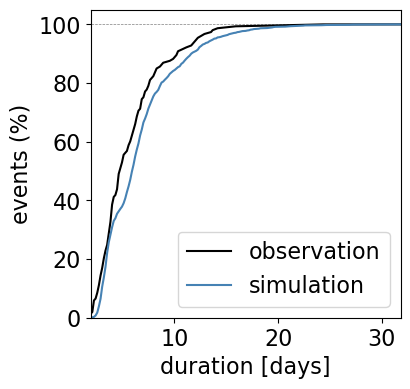

In [51]:
# plot statistics
bins = LinRange(0,maximum(duration_all)/2/pi,27)

fig, ax = subplots(1,1, figsize = (4,4))

ax.axhline(y = 100, linestyle = "--", color = "grey", linewidth = 0.5)


duration_sorted = sort(duration_all./2/pi);
data = [];
for m in duration_sorted
    cdf = sum(duration_sorted .<= m)
    data = vcat(data, cdf/size(duration_all)[1])
end
data = [data; 1.0]

ax.plot([duration_sorted;maximum(duration_sim)], data*100, color="black", alpha=1, linewidth=1.5, label = "observation")

duration_sorted = sort(duration_sim./2/pi);
data = [];
for m in duration_sorted
    cdf = sum(duration_sorted .<= m)
    data = vcat(data, cdf/size(duration_sim)[1])
end

ax.plot(duration_sorted, data*100, color="steelblue", alpha=1, linewidth=1.5, label = "simulation")


ax.set_xlabel("duration [days]", fontsize = 16)
ax.set_ylabel("events (%)", fontsize = 16)
ax.tick_params(axis="both", labelsize=16)

ax.set_xlim([duration_sorted[1], duration_sorted[end]])
ax.set_ylim([0,105])
ax.legend(fontsize=16, loc = "lower right")


savefig("duration_comparison_obs_sim.png", dpi = 600, bbox_inches="tight", transparent = true)

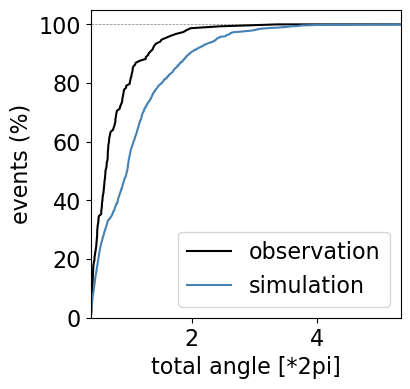

In [52]:
# plot statistics
bins = LinRange(0,maximum(total_angle_all)/2/pi,27)

# histogram of total angle
fig, ax = subplots(1,1, figsize = (4,4))
#n, bins, patches = axs[1].hist([total_angle_all./2/pi,total_angle_sim./2/pi] ,  bins=bins, color=["black", "steelblue"], alpha=0.75, rwidth=0.8, label = ["observation", "Simulation"], density = true);
#axs[1].legend(fontsize=8)
ax.axhline(y = 100, linestyle = "--", color = "grey", linewidth = 0.5)


total_angle_sorted = sort(total_angle_all./2/pi);
data = [];
for m in total_angle_sorted
    cdf = sum(total_angle_sorted .<= m)
    data = vcat(data, cdf/size(total_angle_all)[1])
end
data = [data; 1.0]
#percentile98 = percentile(total_angle_c./2/pi, 98)
#axs[2].axvline(x = percentile98, color = "black", linestyle = "--", linewidth = 0.5, label  = "98th percentile")
ax.plot([total_angle_sorted;maximum(total_angle_sim)], data*100, color="black", alpha=1, linewidth=1.5, label = "observation")

total_angle_sorted = sort(total_angle_sim./2/pi);
data = [];
for m in total_angle_sorted
    cdf = sum(total_angle_sorted .<= m)
    data = vcat(data, cdf/size(total_angle_sim)[1])
end
#percentile98 = percentile(total_angle_c./2/pi, 98)
#axs[2].axvline(x = percentile98, color = "black", linestyle = "--", linewidth = 0.5, label  = "98th percentile")
ax.plot(total_angle_sorted, data*100, color="steelblue", alpha=1, linewidth=1.5, label = "simulation")


ax.set_xlabel("total angle [*2pi]", fontsize = 16)
ax.set_ylabel("events (%)", fontsize = 16)
ax.tick_params(axis="both", labelsize=16)

ax.set_xlim([total_angle_sorted[1], total_angle_sorted[end]])
ax.set_ylim([0,105])
ax.legend(fontsize=16, loc = "lower right")


savefig("total_angle_comparison_obs_sim.png", dpi = 600, bbox_inches="tight", transparent = true)

In [ ]:
duration_LN = [21.0, 41.0, 103.0, 42.0, 50.0, 24.0, 21.0, 43.0, 26.0, 47.0, 44.0, 84.0, 17.0, 23.0, 28.0, 42.0, 44.0, 44.0, 70.0, 22.0, 122.0, 33.0, 39.0, 34.0, 41.0, 41.0, 74.0, 67.0, 18.0, 85.0, 26.0, 42.0, 27.0, 22.0, 18.0, 21.0, 111.0, 55.0, 78.0, 81.0, 45.0, 50.0, 43.0, 22.0, 17.0, 19.0, 20.0, 43.0, 38.0, 41.0, 34.0, 79.0, 57.0, 35.0, 39.0, 49.0, 46.0, 46.0, 27.0, 43.0, 59.0, 18.0, 41.0, 43.0, 20.0, 75.0, 23.0, 62.0, 40.0, 23.0, 17.0, 17.0, 122.0, 21.0, 29.0, 83.0, 26.0, 34.0, 22.0, 34.0, 38.0, 17.0, 32.0, 56.0, 72.0, 51.0, 55.0, 24.0, 20.0, 18.0, 34.0, 22.0, 84.0, 44.0, 25.0, 26.0, 46.0, 23.0, 123.0, 24.0, 18.0, 30.0, 38.0, 76.0, 39.0, 42.0, 49.0, 14.0, 84.0, 45.0, 39.0, 61.0, 36.0, 62.0, 49.0, 86.0, 41.0, 50.0, 73.0, 60.0, 35.0, 37.0, 114.0, 55.0, 22.0, 22.0, 49.0, 22.0, 77.0, 49.0, 18.0, 58.0, 31.0, 18.0, 21.0, 20.0, 21.0, 47.0, 19.0, 40.0, 21.0, 67.0, 38.0, 34.0, 21.0, 22.0, 24.0, 25.0, 43.0, 21.0, 23.0, 37.0, 40.0, 23.0, 19.0, 22.0, 43.0, 47.0, 21.0, 65.0, 51.0, 40.0, 17.0, 45.0, 25.0, 22.0, 40.0, 42.0, 90.0, 53.0, 45.0, 20.0, 86.0, 32.0, 20.0, 26.0, 48.0, 17.0, 28.0, 25.0, 46.0, 69.0, 47.0, 78.0, 40.0, 46.0, 27.0, 20.0, 23.0, 47.0, 30.0, 24.0, 36.0, 23.0, 35.0, 43.0, 47.0, 91.0, 19.0, 67.0, 19.0, 49.0, 21.0, 48.0, 12.0, 21.0, 75.0, 20.0, 37.0, 22.0, 38.0, 17.0, 21.0, 39.0, 35.0, 35.0, 18.0, 44.0, 39.0, 24.0, 68.0, 35.0, 74.0, 40.0, 108.0, 25.0, 39.0, 24.0, 18.0, 55.0, 27.0, 31.0, 55.0, 35.0, 55.0, 43.0, 120.0, 32.0, 49.0, 64.0, 22.0, 52.0, 41.0, 37.0, 28.0, 37.0, 33.0, 25.0, 54.0, 78.0, 23.0, 52.0, 106.0, 19.0, 42.0, 36.0, 22.0, 23.0, 47.0, 77.0, 22.0, 37.0, 38.0, 34.0, 47.0, 95.0, 18.0, 70.0, 43.0, 33.0, 41.0, 26.0, 80.0, 26.0, 21.0, 29.0, 28.0, 25.0, 35.0, 38.0, 27.0, 19.0, 26.0, 58.0, 22.0, 20.0, 110.0, 87.0, 40.0, 36.0, 16.0, 42.0, 24.0, 21.0, 44.0, 33.0, 71.0, 36.0, 63.0, 36.0, 21.0, 85.0, 84.0, 67.0, 46.0, 36.0, 26.0, 26.0, 48.0, 69.0, 20.0, 18.0, 35.0, 30.0, 67.0, 43.0, 35.0, 48.0, 82.0, 72.0, 79.0, 40.0, 69.0, 41.0, 26.0, 24.0, 50.0, 80.0, 37.0, 35.0, 46.0, 21.0, 133.0, 26.0, 45.0, 36.0, 32.0, 38.0, 49.0, 24.0, 72.0, 55.0, 21.0, 44.0, 23.0, 40.0, 32.0, 19.0, 19.0, 20.0, 24.0, 73.0, 26.0, 40.0, 32.0, 25.0, 23.0, 44.0, 49.0, 71.0, 44.0, 19.0, 36.0, 39.0, 18.0, 48.0, 17.0, 22.0, 54.0, 24.0, 49.0, 37.0, 76.0, 17.0, 55.0, 33.0, 30.0, 61.0, 73.0, 60.0, 42.0, 78.0, 52.0, 50.0, 45.0, 35.0, 32.0, 47.0, 20.0, 76.0, 130.0, 89.0, 51.0, 42.0, 40.0, 47.0, 30.0, 39.0, 23.0, 33.0, 53.0, 20.0, 36.0, 38.0, 26.0, 93.0, 19.0, 50.0, 20.0, 72.0, 73.0, 19.0, 95.0, 20.0, 19.0, 36.0, 61.0, 23.0, 42.0, 29.0, 69.0, 33.0, 54.0, 54.0, 17.0, 18.0, 20.0, 28.0, 41.0, 22.0, 28.0, 18.0, 32.0, 47.0, 50.0, 28.0, 23.0, 28.0, 36.0, 20.0, 19.0, 37.0, 44.0, 39.0, 50.0, 33.0, 142.0];
duration_EN = [30.0, 47.0, 18.0, 41.0, 19.0, 20.0, 58.0, 18.0, 54.0, 22.0, 28.0, 25.0, 49.0, 44.0, 45.0, 100.0, 37.0, 94.0, 39.0, 15.0, 59.0, 31.0, 19.0, 72.0, 40.0, 36.0, 70.0, 73.0, 78.0, 39.0, 68.0, 54.0, 39.0, 20.0, 54.0, 26.0, 74.0, 19.0, 59.0, 21.0, 44.0, 91.0, 41.0, 46.0, 46.0, 15.0, 25.0, 27.0, 47.0, 44.0, 19.0, 29.0, 40.0, 32.0, 155.0, 18.0, 45.0, 87.0, 41.0, 40.0, 34.0, 22.0, 19.0, 38.0, 35.0, 26.0, 22.0, 42.0, 45.0, 31.0, 65.0, 35.0, 21.0, 23.0, 32.0, 25.0, 24.0, 19.0, 44.0, 54.0, 53.0, 47.0, 89.0, 20.0, 24.0, 22.0, 24.0, 23.0, 98.0, 21.0, 53.0, 101.0, 41.0, 24.0, 20.0, 47.0, 17.0, 24.0, 20.0, 17.0, 35.0, 69.0, 40.0, 79.0, 24.0, 19.0, 109.0, 109.0, 81.0, 22.0, 45.0, 19.0, 21.0, 47.0, 22.0, 68.0, 73.0, 50.0, 98.0, 23.0, 49.0, 45.0, 22.0, 39.0, 24.0, 43.0, 19.0, 42.0, 42.0, 67.0, 38.0, 54.0, 79.0, 45.0, 39.0, 46.0, 82.0, 50.0, 39.0, 26.0, 44.0, 25.0, 42.0, 80.0, 16.0, 24.0, 89.0, 38.0, 26.0, 20.0, 19.0, 26.0, 37.0, 48.0, 21.0, 28.0, 37.0, 22.0, 73.0, 56.0, 26.0, 65.0, 40.0, 22.0, 45.0, 22.0, 68.0, 20.0, 19.0, 152.0, 22.0, 17.0, 25.0, 48.0, 22.0, 19.0, 36.0, 34.0, 22.0, 23.0, 86.0, 19.0, 41.0, 61.0, 58.0, 63.0, 38.0, 34.0, 21.0, 66.0, 51.0, 54.0, 24.0, 72.0, 22.0, 45.0, 99.0, 19.0, 37.0, 18.0, 23.0, 101.0, 22.0, 33.0, 42.0, 24.0, 40.0, 33.0, 58.0, 26.0, 43.0, 16.0, 22.0, 19.0, 96.0, 69.0, 25.0, 38.0, 75.0, 39.0, 22.0, 31.0, 48.0, 58.0, 40.0, 57.0];
duration_N = [36.0, 78.0, 55.0, 67.0, 36.0, 37.0, 50.0, 140.0, 86.0, 34.0, 81.0, 39.0, 40.0, 19.0, 43.0, 57.0, 16.0, 39.0, 26.0, 25.0, 37.0, 38.0, 70.0, 48.0, 33.0, 44.0, 17.0, 47.0, 33.0, 80.0, 36.0, 37.0, 26.0, 37.0, 22.0, 21.0, 78.0, 141.0, 64.0, 47.0, 32.0, 18.0, 15.0, 39.0, 25.0, 54.0, 25.0, 56.0, 42.0, 25.0, 34.0, 39.0, 43.0, 40.0, 21.0, 17.0, 96.0, 46.0, 22.0, 18.0, 85.0, 20.0, 36.0, 42.0, 87.0, 48.0, 17.0, 60.0, 37.0, 36.0, 43.0, 39.0, 42.0, 40.0, 64.0, 35.0, 61.0, 101.0, 22.0, 50.0, 42.0, 36.0, 16.0, 50.0, 18.0, 22.0, 37.0, 42.0, 47.0, 49.0, 48.0, 20.0, 29.0, 25.0, 26.0, 87.0, 25.0, 22.0, 48.0, 38.0, 66.0, 39.0, 37.0, 20.0, 25.0, 23.0, 51.0, 16.0, 17.0, 43.0, 22.0, 31.0, 23.0, 50.0, 49.0, 54.0, 54.0, 19.0, 78.0, 43.0, 24.0, 37.0, 42.0, 25.0, 38.0, 39.0, 21.0, 48.0, 30.0, 57.0, 18.0, 44.0, 20.0, 23.0, 65.0, 35.0, 53.0, 84.0, 28.0, 68.0, 19.0, 26.0, 19.0, 75.0, 21.0, 60.0, 23.0, 54.0, 42.0, 20.0, 21.0, 136.0, 28.0, 43.0, 27.0, 34.0, 34.0, 18.0, 123.0, 88.0, 44.0, 16.0, 57.0, 37.0, 79.0, 21.0, 21.0, 104.0, 20.0, 82.0, 115.0, 29.0, 44.0, 22.0, 57.0, 46.0, 38.0, 41.0, 55.0, 84.0, 23.0, 53.0, 23.0, 64.0, 19.0, 45.0, 35.0, 25.0, 61.0, 19.0, 21.0, 73.0, 78.0, 38.0, 34.0, 53.0, 22.0, 39.0, 71.0, 15.0, 23.0, 25.0, 98.0, 41.0, 38.0, 31.0, 26.0, 25.0, 29.0, 20.0, 35.0, 115.0, 16.0, 38.0, 39.0, 41.0, 92.0, 39.0, 39.0, 43.0, 40.0, 29.0, 46.0, 55.0, 23.0, 35.0, 44.0, 59.0, 22.0, 16.0, 78.0, 16.0, 49.0, 41.0, 34.0, 70.0, 22.0, 36.0, 17.0, 21.0, 27.0, 22.0, 66.0, 109.0, 13.0, 69.0, 23.0, 44.0, 19.0, 39.0, 26.0, 42.0, 28.0, 37.0, 133.0, 33.0, 23.0, 40.0, 26.0, 18.0, 24.0, 44.0, 21.0, 21.0, 58.0, 21.0, 24.0, 24.0, 124.0, 33.0, 78.0, 29.0, 50.0, 48.0, 21.0, 26.0, 40.0, 92.0, 21.0, 25.0, 19.0, 42.0, 37.0, 19.0, 25.0, 77.0, 37.0, 38.0, 23.0, 32.0, 35.0, 23.0, 18.0, 18.0, 38.0, 42.0, 33.0, 23.0, 37.0, 19.0, 30.0, 71.0, 37.0, 20.0, 19.0, 59.0, 87.0, 57.0, 20.0, 33.0, 40.0, 28.0, 55.0, 19.0, 22.0, 28.0, 24.0, 42.0, 51.0, 33.0, 22.0, 24.0, 71.0, 42.0, 22.0, 17.0, 40.0, 98.0, 38.0, 36.0, 32.0, 69.0, 43.0, 46.0, 54.0, 18.0, 17.0, 23.0, 23.0, 34.0, 38.0, 22.0, 21.0, 38.0, 119.0, 21.0, 24.0, 39.0, 17.0, 39.0, 80.0, 60.0, 36.0, 50.0, 102.0, 38.0, 33.0, 16.0, 19.0, 19.0, 60.0, 40.0, 44.0, 22.0, 63.0, 23.0, 114.0, 23.0, 71.0, 99.0, 53.0, 41.0, 20.0, 46.0, 42.0, 70.0, 17.0, 39.0, 20.0, 55.0, 33.0, 39.0, 22.0, 70.0, 22.0, 44.0, 36.0, 22.0, 46.0, 43.0, 82.0, 31.0, 77.0, 31.0, 71.0, 21.0, 48.0, 19.0, 22.0, 19.0, 60.0, 40.0, 54.0, 50.0, 16.0, 47.0, 21.0, 47.0, 22.0, 107.0, 24.0, 20.0, 48.0, 44.0, 39.0, 80.0, 41.0, 46.0, 42.0, 27.0, 94.0, 20.0, 18.0, 41.0, 41.0, 18.0, 52.0, 21.0, 47.0, 22.0, 25.0, 17.0, 20.0, 74.0, 41.0, 25.0, 54.0, 44.0, 28.0, 26.0, 34.0, 42.0, 36.0, 37.0, 43.0, 35.0, 21.0, 40.0, 42.0, 21.0, 23.0, 39.0, 47.0, 39.0, 30.0, 27.0, 200.0, 33.0, 21.0, 37.0, 51.0, 31.0, 34.0, 18.0, 22.0, 63.0, 19.0, 32.0, 37.0, 111.0, 33.0, 42.0, 29.0, 34.0, 38.0, 76.0, 34.0, 73.0, 48.0, 36.0, 43.0, 23.0, 53.0, 33.0, 19.0, 42.0, 51.0, 42.0, 64.0, 51.0, 22.0, 23.0, 52.0, 55.0, 65.0, 55.0, 55.0, 46.0, 34.0, 18.0, 50.0, 64.0, 37.0, 50.0, 27.0, 28.0, 39.0, 22.0, 51.0, 65.0, 67.0, 20.0, 34.0, 19.0, 44.0, 44.0, 18.0, 62.0, 19.0, 83.0, 35.0, 19.0, 17.0, 17.0, 44.0, 49.0, 49.0, 48.0, 43.0, 43.0, 60.0, 42.0, 37.0, 66.0, 44.0, 18.0, 43.0, 56.0, 49.0, 49.0, 25.0, 19.0, 22.0, 60.0, 77.0, 32.0, 89.0, 30.0, 69.0, 37.0, 37.0, 51.0, 72.0, 45.0, 42.0, 73.0, 59.0, 24.0, 24.0, 45.0, 23.0, 56.0, 36.0, 19.0, 60.0, 34.0, 23.0, 28.0, 40.0, 15.0, 171.0, 68.0, 60.0, 32.0, 46.0, 34.0, 24.0, 14.0, 51.0, 38.0, 47.0, 20.0, 63.0, 39.0, 36.0, 20.0, 52.0, 52.0, 36.0, 28.0, 17.0, 18.0, 62.0, 23.0, 44.0, 54.0, 23.0, 21.0, 53.0, 58.0, 23.0, 18.0, 61.0, 21.0, 20.0, 19.0, 37.0, 48.0, 23.0, 25.0, 22.0, 51.0, 19.0, 29.0, 45.0, 104.0, 32.0, 41.0, 46.0, 67.0, 103.0, 36.0, 80.0, 34.0, 35.0, 62.0, 20.0, 38.0, 19.0, 39.0, 17.0, 30.0, 59.0, 93.0, 47.0, 19.0, 47.0, 36.0, 28.0, 169.0, 22.0, 15.0, 38.0, 20.0, 38.0, 57.0, 23.0, 41.0, 19.0, 24.0, 70.0, 59.0, 41.0, 71.0, 45.0, 25.0, 60.0, 19.0, 37.0, 52.0, 40.0, 96.0, 21.0, 46.0, 44.0, 85.0, 20.0, 44.0, 17.0, 16.0, 42.0, 30.0, 18.0, 51.0, 22.0, 33.0, 24.0, 18.0, 22.0, 34.0, 36.0, 35.0, 37.0, 41.0, 23.0, 59.0, 64.0, 70.0, 16.0, 55.0, 44.0, 50.0, 57.0, 74.0, 38.0, 67.0, 40.0, 17.0, 67.0, 34.0, 79.0, 39.0, 25.0, 17.0, 74.0, 38.0, 25.0, 33.0, 43.0, 96.0, 42.0, 62.0, 39.0, 43.0, 34.0, 37.0, 25.0, 31.0, 22.0, 54.0, 77.0, 23.0, 25.0, 22.0, 22.0, 25.0, 23.0, 23.0, 48.0, 107.0, 22.0, 92.0, 41.0, 37.0, 21.0, 37.0, 23.0, 24.0, 27.0, 78.0, 21.0, 82.0, 69.0, 19.0, 19.0, 47.0, 44.0, 35.0, 28.0, 35.0, 35.0, 26.0, 29.0, 27.0, 21.0, 24.0, 49.0, 62.0, 34.0, 40.0, 65.0, 42.0, 67.0, 28.0, 89.0, 15.0, 34.0, 41.0, 46.0];


In [ ]:
total_angle_EN = [4.34312352783911, 9.800206950174037, 2.681062740819421, 5.297976069976761, 2.9832416087835876, 2.3852461297106737, 9.619530351638945, 3.0259628697468317, 11.376265309930837, 3.9125139198090753, 4.625189766660561, 3.569530973364557, 7.103922735708212, 6.176628627819518, 6.612129946009848, 15.623527145171597, 5.1589757330046035, 16.580621013739023, 6.098710227750241, 2.6923948292691597, 10.404694896313439, 4.836127636855071, 2.7795181093427224, 9.166736177530264, 6.2046264272429585, 6.214803753782287, 11.766801650598058, 13.844286092820198, 13.59068784724733, 7.069526030008559, 12.264932875693262, 8.727083205390414, 7.263841386062437, 3.2304469153972533, 9.325382373304354, 2.805087635030039, 11.114790673814877, 3.1820831527081985, 10.037980137267494, 2.6484199083765834, 6.851157175222821, 17.981061577900896, 7.3595871885450155, 8.111747930505901, 3.94166073269695, 2.462912587580191, 3.8480782532968467, 3.549552911196974, 6.739313220066959, 8.107649456353354, 2.506567596519946, 3.959415362819538, 6.651373128070495, 4.731209076162576, 19.64793336133374, 2.563256229026974, 7.0118451221564335, 16.00661767629468, 7.327854020212712, 5.759986279885601, 6.25189340263281, 2.9860988115012055, 3.3394147600970805, 6.781844735193738, 6.381966658261965, 3.7376205107557596, 2.393424118000464, 6.372068665360622, 7.171764165429931, 5.079041548509162, 10.86240674509788, 5.571235686623631, 3.7074188083472563, 2.65096367927062, 4.897021871787961, 3.1779902242648, 3.4244521941594734, 2.690263640979403, 6.929877317777066, 9.736378457459445, 11.10693411146116, 7.339118919451209, 15.012557178602119, 2.712071205275709, 3.960725866885605, 2.4992238786161947, 2.9346005732870823, 3.725134427795412, 16.3796185157198, 3.682414280960378, 8.084062100142138, 15.92917669561288, 7.239492422616421, 2.6027348306969187, 3.634412401210425, 5.846601916912964, 2.6593312998775644, 4.132960894244288, 3.1842132209151366, 2.779794806745585, 5.712984134510782, 11.242506424137423, 5.816488498510196, 13.17465781174128, 2.5971345277411637, 2.4316189574620424, 18.286038122165063, 20.290399099728706, 13.392015386047486, 3.5546692728827414, 7.204590109465387, 2.794075450934088, 2.7698505933696165, 8.767174752855027, 3.1577440398034584, 11.099723026980897, 10.733022913681868, 10.210517482731955, 17.475784247069083, 2.9268966379836643, 7.645382656887158, 7.23476369700134, 2.687241818204619, 6.471416718043699, 3.3191947682153047, 6.097845886461486, 3.296266628193196, 6.883099989484453, 8.414660858856832, 11.630316591693575, 6.487321719994364, 10.617492437295049, 11.342674502639914, 7.44581853396358, 4.964819876793363, 7.256713198994112, 15.38457059467358, 7.415303480886162, 7.12821915758339, 4.28698687285622, 5.8592235830379735, 4.5778243147795, 7.561207169650662, 12.059161271173714, 2.8801025740840376, 3.7752648598442375, 16.731928466882398, 7.183024267838194, 3.9712854552544403, 3.1401068487349555, 2.49523856777217, 3.1033366217848446, 5.527634018047166, 7.062717123169652, 3.2386739229084176, 3.9955509690558113, 6.381645228057077, 2.913603050667388, 12.336796371595193, 8.585099860901014, 3.417666530155179, 11.254278690666307, 6.649487097209243, 3.4286288249644783, 7.600220527045523, 2.490063271388236, 11.323408518802479, 3.117488602861642, 3.1013188023279734, 24.930412051538386, 3.7196210223066237, 2.446415543896892, 3.260081223107074, 7.834076680876248, 2.4187229397285006, 2.627349960545243, 6.2921993886135095, 5.785361003277406, 3.8495437137021224, 2.7265679516094647, 13.627729353097234, 2.686359651235356, 6.486536404868704, 11.653268697453752, 9.060851771200873, 8.982644244888201, 6.572456891799627, 5.850496365125354, 2.969757650410929, 11.986530277375177, 7.702932592878989, 8.745797313994515, 3.6007245719814387, 10.674887354899571, 3.047783511602494, 8.07485877619143, 15.983770675120045, 2.4881358854582487, 7.468454776945495, 2.57847930036287, 3.876081740337422, 16.64367495585037, 3.486144247871551, 4.707467476976307, 5.254239826537539, 3.766091709397694, 6.794584293463149, 5.334403258774959, 10.109035798362722, 3.779044600199998, 6.869672097418742, 2.7459930235223804, 3.2371039261199632, 3.1315717104237644, 15.05552350755939, 12.128019064561327, 3.3422249572810645, 5.9571389499545955, 14.274562313455306, 7.04452693106456, 3.1835019610065896, 5.443268868458078, 5.027449681612057, 9.748202320286754, 6.282093440290216, 10.24695799704333];
total_angle_LN = [2.373474417235105, 7.739356647550062, 16.04792105534144, 6.193885386946449, 8.426648517616586, 4.003322072570247, 3.0281608022209143, 7.47765505086459, 4.303102938861728, 7.2613051378115685, 4.332391523856483, 13.684088347297587, 2.6071195789993356, 3.6967699710080377, 4.059482763349181, 7.241888036880968, 6.604755092319151, 8.426514164680846, 11.030085417694137, 4.054951260135879, 19.008254582200355, 5.709061312392507, 6.917294548302067, 4.810382523723786, 6.796997511861749, 7.542740592417887, 13.046111670939926, 11.721406361180813, 2.5564136755711173, 13.810262251982026, 3.9816732658483116, 6.056703142058552, 4.092480993439068, 3.1592721001843502, 2.5450109399156418, 2.501394048257037, 16.14157526245241, 8.362240337577541, 13.710871779141959, 16.408523891812433, 9.090785019122958, 7.731096026616446, 7.047259164758108, 2.855442837023923, 2.3735885559388596, 2.8094145057277125, 3.5130621402093443, 6.196145331815821, 6.804960150401165, 6.045316170882925, 4.104614544038245, 13.514453883224968, 8.314776896695605, 7.091136654807663, 4.94003903394704, 6.447397989358321, 7.391727304306754, 7.06520984327058, 4.401013915503326, 8.141245738855352, 8.582585162898841, 2.367361047358881, 6.082499016614987, 5.520491357634758, 2.732503750051142, 12.214122575171585, 2.705505378204651, 11.892611824178058, 5.825700839568013, 3.093541536503029, 2.403576347380578, 2.9243946219204133, 22.397909620253706, 2.742581986913613, 5.38386659876534, 15.13421653349016, 3.6280863113540476, 5.099352939738597, 4.297748702927853, 6.321259419112463, 6.197755364639128, 2.807359147902035, 4.1549105062220795, 7.510599891054438, 9.686795496908063, 9.128212999573135, 10.73544298373602, 3.113760353082868, 2.8742322319099776, 2.5393384066075044, 5.658682569906976, 2.55143241243294, 13.477433369583414, 6.982935481859483, 3.6563530885134345, 3.7067042601978226, 7.388729374959121, 4.016364023053516, 22.434417245082376, 3.7221410703765816, 2.506245110962249, 6.149546459921851, 6.16761584960204, 11.107357861528556, 7.432713207878541, 5.728039135044296, 7.495411036931475, 2.6189409398941947, 15.177498454841247, 6.681870334946781, 6.2354426711595, 10.86279966517889, 4.744527887290618, 9.774200071110966, 7.209958150446221, 13.695489666312522, 6.282052261465977, 8.541604417969872, 11.980453639799524, 11.672304175468039, 5.90220877084352, 6.374793142379518, 19.080835387003695, 10.266964595384815, 2.8457491676375932, 3.0457213823083786, 7.917164226434795, 2.8482256387604568, 11.010070333067814, 7.312598456466182, 2.502692571434026, 11.754745068839032, 5.182535188683747, 3.0914490995797093, 2.5521067294945468, 3.067318195150709, 2.963722453229967, 4.921115821056713, 2.5076882850615236, 6.089492331949575, 3.038003276697733, 13.137736422696957, 6.57708720053451, 5.980517534168474, 3.0598107944885116, 2.919694194470585, 3.0737468841775977, 3.290250128977249, 8.19232433312778, 3.269134147160698, 3.9451644779400996, 6.1521798063097615, 7.0630915673236405, 3.8579101468102177, 2.4231001596594686, 2.8813057219138964, 7.514920284187094, 6.848504636847579, 3.2286320696551236, 12.76217214380124, 6.631838099245341, 6.5289589869634685, 2.4115715956190007, 8.098725216358776, 3.2037417493015163, 2.416047433493766, 6.5701550198848455, 5.890308005813864, 14.987087841209526, 7.7254967918966795, 8.01000797881289, 2.7538695237490876, 13.01985486206268, 4.227475146862239, 2.7360877578495146, 4.245005605775802, 8.95668334433665, 2.4101043529634127, 4.0456527537112095, 3.7374885072218675, 7.582231090364395, 10.901166481374112, 10.429097684196982, 11.315230293341532, 6.0706631400772775, 8.674474923469486, 4.1297539318980965, 2.8462250639681503, 3.6345148553375988, 7.764259505518273, 4.798364544613253, 3.5546493604525735, 6.436975300697892, 3.162099094763116, 5.948352790210321, 6.92557179535035, 7.201454411916611, 14.683340745178523, 2.4156365405706772, 14.49396212101406, 2.601669928850707, 8.42515662875212, 3.899102428358488, 8.537160554303323, 2.4670275741179504, 3.4460301037527556, 13.239780742435773, 3.1179886686564573, 6.0814664648475585, 2.6279583164836327, 7.310368176979715, 2.823891842953756, 2.7352222882090884, 7.499335582727051, 6.082718794323451, 6.769332756129363, 3.3284756509857782, 5.315484511443452, 5.253362872705656, 4.499011712679659, 9.526786754099945, 5.742911671577264, 11.81781348891766, 7.588255706055174, 16.056202805132397, 4.76578192102132, 6.553529792291927, 3.6004965554002064, 2.4706517153910608, 9.88288479057178, 4.56998700712931, 5.219318489358437, 8.64552657515214, 5.1420232236446735, 8.083987859364536, 7.42383910811459, 22.65847929470644, 5.716275618010301, 8.642677471644877, 9.67754952681088, 3.4888458239635582, 9.521697494923592, 7.547037969052323, 7.0742601284677535, 5.526241466458, 6.778131051488507, 5.641778433599364, 5.280481200105495, 10.76597146860082, 11.494492632248216, 2.5028478884141987, 7.728219139595957, 21.972231148234933, 2.423735582775077, 4.826665235099523, 5.537251121242843, 4.271949818821972, 3.6504404769668244, 8.029965688853652, 12.61512832826892, 3.910838321614776, 6.663449100312358, 6.778174220561751, 6.501628236527904, 7.364279120071991, 14.993735787890495, 2.993444933899175, 12.0079554597917, 8.669049820922776, 6.679224694836814, 6.1967721764217, 4.379636673911634, 13.696247351000084, 2.502011551834932, 2.5769376026310664, 5.297715945668633, 4.786436551096701, 3.5571317278909245, 5.20894795318161, 6.19340614210009, 4.869442890269719, 2.9748153159731205, 4.818694516806906, 8.938340535478773, 3.053536284006978, 3.40672853099284, 19.6540069526377, 14.34727556189394, 6.1276026248521145, 6.679619241123914, 2.6607711217401357, 7.42023742003794, 2.740264317993831, 4.088969213789889, 7.360732792727568, 5.954554889037135, 13.083830506659108, 4.471345147824524, 10.574697341892247, 5.537020924141698, 3.026512688204586, 14.868143645789164, 15.188288425033178, 11.873377146041317, 7.680791077615057, 7.026092726952514, 3.509127504370926, 5.097173694304124, 6.999017422112425, 12.788895058540168, 2.403868495657756, 3.041618210752455, 6.149984849558717, 6.218686525011609, 11.261426625601832, 9.008046150089253, 5.3313040015608735, 8.362196981207106, 14.050984562497648, 11.967678964542301, 14.556194227733185, 6.614069910915216, 10.7170832222282, 8.044933517629447, 3.8998781872887966, 2.6545333326277456, 7.626198102984365, 12.154834057163866, 4.939536937823666, 6.192565163938463, 5.359163900927999, 3.496571623728902, 19.319395012753105, 3.371914267029571, 8.235059825897498, 6.081839120662665, 5.074497894336148, 5.919682573286306, 7.732189354813482, 3.1965373078277306, 10.031326557681203, 8.491046658394907, 3.2711262939326824, 8.839167720299892, 3.2808770950728756, 7.746757885067227, 4.914054045908983, 3.445866291559855, 3.3018322213601876, 2.736633855451603, 2.872039060976194, 11.372534346969221, 5.084500812638129, 6.178252709277867, 5.364403511031291, 5.136547041840586, 2.512003823641428, 8.09633213015589, 9.253193009951417, 12.015753412930268, 6.950409844900155, 2.5215401291945296, 6.0054062868240825, 6.338300460525266, 2.4271564221347597, 7.3222095767791195, 2.792991891445019, 3.216957823368344, 8.016428603349762, 3.236314571944532, 7.150461890906403, 5.189868258524313, 11.940021000235475, 3.098549425177775, 10.726040364902733, 5.077456427457444, 5.5718022290578695, 8.79446772173472, 14.098475903597969, 10.973939906045025, 6.078529401691261, 12.124540036655555, 8.145594141593493, 8.47037480578338, 8.788310749612842, 6.012076403795161, 4.300609393899729, 6.33088145134852, 2.47831819071264, 10.35232517698176, 23.539547580836558, 14.733109322785495, 9.127353346673672, 7.342017107489183, 5.417914433912077, 8.050171037204894, 3.622183027125426, 6.058247266815312, 3.231496904365318, 4.663980431837333, 8.842614527970195, 3.2891930149986774, 6.442107922718049, 5.443683263816885, 3.9684667003578165, 15.397429659240016, 2.834589782170348, 8.281428211526654, 3.2090026415953936, 11.643997363963413, 14.000989511252177, 3.058231645250089, 17.83957783133468, 3.3958525827761554, 2.425451384880005, 5.553257262819767, 10.48597919306282, 4.022587546493158, 5.826081937420028, 4.785526561951755, 11.703767280973333, 5.034927842566434, 9.132959349897833, 7.961872639647206, 2.4028385608463854, 2.972509867148997, 3.2492189446622066, 4.863888513259382, 6.819984580630391, 2.9879634349195547, 3.333207381330076, 2.5812958183968147, 5.939256722939543, 7.840367710231835, 7.786882460439536, 3.286401647121165, 2.5688818132981455, 2.993022706927344, 7.277703191123836, 2.792876308276429, 2.7168284298966827, 6.296280150031668, 4.601513485985812, 5.148549470740504, 8.902166388967975, 5.968371335399206, 23.73481237894546];
total_angle_N = [6.135083062721986, 13.065393931874295, 9.068617859437628, 11.944778773536724, 5.242703762745598, 5.957029085776702, 7.753777036303427, 23.26427266614538, 15.065297459586837, 7.113014315862365, 14.897424618580713, 5.091870753733319, 6.633156235712961, 3.161504957955443, 6.351088000147779, 8.195477225205842, 2.551349514482653, 5.119301396986247, 3.912292751625328, 2.935214920570991, 6.99583232179048, 5.9568265422671445, 12.192828176957137, 8.014412811747373, 4.437234135740943, 7.693717378110678, 2.8138922058937976, 8.870077004283448, 5.771624084128105, 12.758334789731409, 6.117698079287091, 7.00731543846405, 4.608582989849127, 6.007950946934725, 2.6972168662063294, 3.776105021005942, 12.735140742472908, 23.394019606187758, 12.17695677855685, 8.860937468850135, 6.127204756723454, 2.38763548627604, 2.69895470137236, 6.716189459857273, 4.460616101646242, 9.358132250275826, 4.0522048317218875, 9.393768454793697, 6.9674173611124335, 4.525325163294633, 5.780255073637738, 5.778553370009174, 6.350404007469044, 6.406897899989495, 3.7525115049423703, 2.6238026047131235, 17.566380146956263, 6.858667215338145, 3.34509911412542, 2.4665036403644116, 15.322908731599997, 2.821787901121479, 5.588855690548207, 6.395506536953791, 16.338341587000052, 10.848978409880297, 3.2372234448026105, 10.00354473221445, 7.540194028862733, 5.984181483002251, 6.816737552020786, 6.36704214467188, 6.8488729985867, 6.358994130741952, 11.847557051978512, 5.690263131825344, 10.448851555719704, 16.420708473020195, 2.8992762172913173, 8.671376564798074, 7.340112419304284, 5.243168003552768, 3.0268463921848934, 9.428994839811757, 3.1965738060285096, 4.86903928503574, 6.889568515631216, 5.628829829539622, 8.510537618424467, 8.526687988581584, 7.0515580011578605, 2.389330711463914, 2.7502613445119977, 3.415135126424005, 3.610431072062134, 16.394810911753908, 4.559744249105977, 2.39761481118671, 7.944509241109928, 4.454912986405338, 10.642461083504067, 5.919070086675562, 6.138789581015555, 3.8571140615088826, 3.783525316782984, 3.8808020470571805, 7.861113989706276, 2.549724165261159, 2.8682487560172536, 8.305716738693055, 2.4474766365438345, 4.666630066502151, 3.2556243272620424, 7.540215774223536, 8.33278019292641, 8.41153904113334, 8.530999341221852, 3.0103367691401264, 12.519346881522782, 6.9142068422114935, 3.464459728438246, 6.32616766553701, 7.607090140522423, 3.5559376252009285, 6.2789059735424235, 5.596999964691489, 2.796014885658432, 7.502517481961016, 4.611506042412403, 8.764137706634298, 2.5130605740192875, 7.1452754147347814, 2.3747269544182448, 2.969571206649868, 9.599236329606647, 5.271131007298192, 10.163751954730385, 14.151393121861116, 5.1871697530131655, 10.247897005179741, 2.373861839345091, 4.12816667627027, 2.3722049779904317, 12.53787624377548, 2.4295138861116308, 10.25764120092759, 3.1688872488539763, 8.577264012363601, 6.822169850492989, 3.0435881982129818, 3.079131597305283, 24.59578164168673, 3.854504326554915, 7.652094551628098, 3.858904497834991, 5.36228478541342, 5.240994798147529, 2.797977285021555, 21.404565655721054, 14.501679949505274, 6.1408922370579235, 2.645117482087117, 7.994997002104813, 7.294691982779428, 14.542283906513777, 3.4972614657625494, 2.8729992105469853, 18.49854591151674, 2.3780471581764506, 14.703903362079418, 20.545896541163195, 4.849745524831533, 7.035986705095505, 2.9190033078190494, 9.524395059894834, 8.300041265834349, 5.164632201303354, 6.297796273415018, 9.103013882154526, 12.482474253813196, 3.055918329584996, 6.291777115691268, 3.297217713623776, 10.682852698012706, 2.575855270396434, 6.615110110208273, 6.435517500566389, 2.7371864867713094, 13.510855886284917, 2.6520885540830808, 3.6447826766642577, 12.323068372328672, 13.285048459856675, 6.0759122081096315, 4.515800619486874, 9.63775124669657, 3.5825082895412472, 6.718930758380888, 12.117768965116728, 2.4476003395668844, 4.050759202457504, 4.017045392899037, 16.10981544063463, 7.477193357786913, 5.539264664062433, 5.194354337202817, 3.427853644183467, 3.195874431655461, 4.938699950986792, 2.7058063735308413, 6.3688513282260555, 21.29018516754433, 2.4532593156636877, 4.04594941551964, 4.80509716518042, 6.236909266855362, 15.215275282744457, 7.52230850220214, 6.274087622492237, 7.562437719867895, 6.296030796163192, 4.770543790041376, 6.983033466929882, 9.106099504369912, 2.393003790525449, 5.982857176608506, 6.326387465549057, 10.001897135229285, 3.3461079750110008, 2.5277192505749384, 13.029361920623753, 2.6153717914606682, 7.210836344359338, 5.7812434068724485, 6.224625822032616, 11.887187605428487, 3.5465469475268527, 6.190773993155986, 2.6584906517387026, 2.846523531353548, 4.443244654784162, 3.376168363565436, 11.197682898231585, 18.856130834868445, 2.383053225131442, 3.884915016308451, 2.968399856516247, 6.8119941934907775, 3.004677043448818, 5.720451074588276, 3.683509894741398, 7.467688056985206, 5.5480699810572025, 6.126432570679625, 21.773567390213127, 4.0259119912495045, 2.9668391076164107, 5.482987666640543, 3.065316713994276, 2.4393127610799357, 4.085628437969078, 7.447319763263836, 3.7420621574490736, 3.0989387123877385, 9.745466595072738, 2.6859657340564898, 3.396782087254827, 2.802761308569161, 18.991732731566813, 4.576460063856858, 13.95935967065131, 4.307945387640855, 8.651528352580737, 6.939559806545336, 3.92023335983988, 3.551529825983964, 6.535684641400227, 13.955882628363092, 2.601503390766733, 3.4425033243889778, 2.7805376899122285, 5.348013623935503, 6.122151724778543, 2.8772496848038793, 3.7199680017952215, 15.965877681251706, 5.740586077973412, 6.23694049088073, 3.565601610463474, 6.076692807750293, 5.581911889077521, 2.4865960693149636, 2.79976686849321, 3.2292499047692886, 6.098684908528159, 6.330545687400971, 4.6121938577169015, 3.3058929698020614, 6.286396886496652, 2.5285948452579436, 4.418699690509398, 11.039590056023926, 5.992010368982217, 3.003537475523787, 2.9096986734949812, 8.557531197421524, 15.040714410757001, 10.313628305142643, 2.4713643296498167, 5.477965604061527, 6.369188389923558, 5.541365283580968, 7.914916040460621, 3.334708686776285, 3.4988238399758282, 4.571850677356097, 2.86350041664829, 7.779359747424516, 9.08010905937186, 5.07367619466372, 2.503178273239295, 3.8067293768776898, 11.871669531849628, 7.484681919399111, 3.4161950586547345, 2.6392625625794413, 5.4197379438842255, 16.37080359811976, 5.522379715254503, 5.3819118751160016, 5.680474574535646, 11.213490230512779, 6.083549568827009, 6.1714765961479365, 9.717302666344109, 2.8221781046060403, 3.1142760345046945, 3.477970435424494, 3.6591173272559647, 6.12493921044028, 6.415871557052243, 2.876638339831061, 3.561267057722107, 5.666970585635944, 22.11172521336219, 2.664462442838925, 2.771665917907526, 5.712405056442467, 2.5247556755426253, 6.576880069581247, 14.291418418924046, 11.582636908083423, 5.981455052056047, 9.449453303177798, 16.547086662190004, 6.496643652474264, 5.111839379761163, 2.9819154019953036, 2.468169657687932, 2.6151156360394827, 9.703489098448433, 4.787830598039459, 7.623594647915691, 3.311563365787382, 12.793929735502648, 3.4940775760205596, 18.684904070022768, 3.394309819078008, 10.689579942646379, 17.222918875254344, 9.191799821952877, 6.828129230471376, 2.5752392453780235, 7.769897512762193, 6.264831407895263, 11.511697271000068, 2.6486035196877076, 6.6518200873732285, 2.483885969769179, 8.686937411166618, 6.0535922065464, 7.272563488123696, 3.8102828842379783, 12.713978768231973, 3.4196095620902893, 6.1734995788853615, 5.7042454992705505, 3.138032018459494, 6.982352062856405, 6.408012188817544, 11.394451216700173, 4.454118253520557, 13.75179066225359, 4.632639993685792, 10.65304325245779, 3.1513552290658993, 7.939264133964093, 2.4057086535289036, 2.9759126516374894, 2.9436320701485323, 10.13207700182833, 5.395499408511161, 9.147902773463448, 8.353392741070788, 2.6161358527913623, 5.072790402017504, 2.621478925718491, 9.807211825531649, 2.9427671146213767, 20.210330228458037, 2.3752928003748894, 3.241213858730711, 6.917381324619469, 7.127943266304714, 6.24191439160461, 12.656185965170351, 7.288531421010057, 6.6501297105557455, 6.066992432650046, 3.114162264394071, 15.40797058033123, 2.4757071125044052, 2.464778267107053, 6.171372613012194, 5.585874119597525, 2.7211340198439697, 9.239924452561244, 3.3208227418691605, 7.214324060203844, 3.14193274459611, 2.5235760167410892, 2.9056069655317165, 3.046889766458644, 12.306713347863857, 7.195729048501528, 3.286577647831912, 10.04283381759339, 6.394211941110724, 3.5247451150251132, 4.876282899885128, 6.163538295815554, 7.101041194019272, 4.923470518822932, 5.886681718638631, 6.80150640590843, 4.585371722082495, 3.3615157292314923, 6.050342841946489, 5.1427128447958435, 2.7701772860975877, 3.9765250503186804, 6.124543421542357, 6.14845051162706, 5.089979796112068, 2.471367928979977, 4.074334908765559, 33.606019537133335, 4.652760395179533, 2.4914717563363404, 5.1502107939560595, 7.16393079628826, 4.118998300380801, 6.257443251187416, 2.5199815900001954, 2.8061817752648905, 9.58604058891809, 3.2099682214509375, 5.099806296503884, 5.6806610405713265, 19.29776506490094, 5.150023910274472, 7.114563333106403, 4.483820853582673, 6.234681560908412, 4.8059617701275, 12.840710902956978, 6.983657232145722, 11.502316384036472, 8.482582982040325, 5.909558453339116, 6.304155283584647, 3.8161973920767682, 9.091129298674067, 6.115612338333609, 2.9354976265678836, 7.59350117806888, 8.432538034269552, 6.455622543493602, 10.754897822444894, 7.831207807454504, 2.3947711553432196, 2.809303780722385, 8.699678364885989, 9.235411067183533, 11.079965597486696, 8.791411165685572, 8.88859069334579, 6.705760932786012, 5.586800863988897, 2.460022692387429, 7.316817927987946, 11.353084989378495, 6.0026485069813855, 7.1108806052796405, 3.1424781146989966, 3.669969765855533, 5.112467942261414, 2.9005145428482084, 7.538680469904464, 11.109749660473653, 10.545231435657685, 2.7282553970183816, 5.586107671029593, 2.4202260191059155, 7.144621551414433, 7.789888915107926, 2.502669055131558, 9.575407731467468, 2.387691153444681, 14.941221215031248, 6.176410027982117, 2.774917331069618, 2.5612536042775775, 3.0950683323084283, 6.0491514647963545, 7.7876809406523275, 8.854463385444546, 8.519567104292259, 7.294793643593026, 7.101142558270844, 8.66610871273884, 7.457976091150816, 6.542263510632402, 9.4705303449689, 5.438897915655748, 2.6192578747300463, 5.919127803168466, 10.64839996161691, 8.190489191630158, 9.509433872232274, 3.7276076838621206, 3.2136681278226593, 3.2414060924964736, 12.02540378183814, 13.053762679097524, 5.407337775392563, 15.114056135318398, 5.603993444658337, 12.412854459709113, 4.742633957998417, 6.112981175700484, 9.305959722115617, 11.670061634097657, 7.9226337955738675, 5.6033629362406865, 10.928697473294562, 10.594223534131439, 3.1063866886922096, 3.15699969784171, 6.448228714582876, 3.3451289262097923, 8.59420464310256, 5.746936852024926, 2.8843015387634727, 9.27866156433538, 5.395854180813342, 2.951632725375898, 4.742770623089962, 6.685052018655892, 2.411292383775355, 32.600888551465665, 12.645098943669884, 10.00384606866346, 5.426699008101716, 8.936452604181031, 6.727129100293506, 4.773425347751955, 2.4378393701905803, 10.248914121476393, 6.19661233521833, 8.432229444876604, 2.7710903512969876, 10.417384244259386, 5.92836196167559, 5.243789722735425, 2.5457606271934186, 9.895365916775281, 7.436244803912182, 5.641551513248925, 5.444166163265676, 2.764534635830065, 2.7895808488779164, 10.167912878091048, 3.049864323304355, 7.779180791712307, 7.9186193418794595, 2.3842549735225314, 2.4847655627742493, 8.551269862148791, 12.388688424201813, 2.703221051470739, 2.5407800565797882, 11.005213763623484, 2.4746990171815693, 2.4908952591369076, 3.1674572189187087, 6.102679696032348, 7.028678567595789, 2.694586998062154, 3.9296927864089843, 4.045696231870028, 8.20110521334891, 2.6712256102791203, 4.586564954125826, 7.509547857369816, 15.466791534186035, 5.058431916061723, 6.606101277927774, 7.189943009664272, 11.502134341058921, 15.99633138104344, 6.644280644528192, 14.17367805071999, 5.56416522801957, 4.9424767968404435, 10.865879013852918, 2.7352334276624655, 5.613218440147978, 2.584365037656421, 7.199195570923066, 2.672589490591001, 5.593028806975266, 10.794478572187366, 16.781024232385423, 7.507296436399263, 3.760065394611714, 8.341761814340533, 6.127469842708939, 4.281489075510795, 26.703373483727955, 3.2282286811834697, 2.421042650921741, 5.6978047291568075, 3.4064106806125576, 5.977463547648246, 10.807156298472288, 3.1884122283881386, 6.503181329392703, 2.565097877247942, 5.044866210928464, 11.76629303508983, 11.193708709343893, 6.876939859029877, 13.407183930501713, 8.86545554681315, 3.4748826197091125, 10.05626944048138, 2.4469550326553016, 5.101533121595953, 10.508615403554668, 8.244144313243027, 19.288737004018046, 3.7968655126590116, 7.935649668186276, 7.488924666328338, 16.43956032122682, 2.9327492353181097, 7.01722594156675, 3.2120593455647874, 2.4723376736565545, 6.823687280035427, 5.250411081701021, 2.520045295681321, 7.792409444489621, 2.4759337181921164, 4.869791666799252, 3.0216553358172336, 3.271760875912691, 2.973037575273357, 6.420956409901904, 5.050537842598658, 5.436640108302663, 5.404231356223128, 4.765556588845024, 2.4672222397443964, 9.923097292539167, 10.043982645492353, 12.467506405378648, 2.386618572865978, 10.277063918371539, 6.70212283199306, 6.365636711447172, 10.06689972311094, 13.258822906271602, 6.123303184815194, 12.462818587071485, 7.011951369583451, 2.477234794137879, 11.695906893737616, 5.514019420366646, 11.810347412889275, 6.412547103075265, 4.002756696381218, 2.3642976142527914, 11.245508509933693, 5.790319092572548, 2.8600628655754616, 5.2938149339710066, 7.9331274564830006, 14.801624274432045, 5.978222636920764, 9.580769497942274, 5.290571701509544, 8.3366898891743, 6.058677129816896, 5.120778351517657, 3.5310872101064543, 5.631535743349201, 2.6860271396382425, 6.489437746583054, 12.330618850219022, 3.950110581305789, 3.7441643453060376, 3.4667759303284438, 3.5778643464274706, 3.2968282348242752, 2.830259998586934, 2.5602916371590156, 6.2435083944548335, 18.721946580433027, 2.534142927825271, 14.896389802043828, 6.505305484992589, 5.338285313307982, 2.982138918680209, 6.479853390155936, 2.826340963165867, 2.702882160284849, 3.1820128422973344, 16.30720865633575, 2.5762295753373636, 12.335528575446109, 9.7134411605199, 2.6793387720799826, 2.981745141201841, 8.567441379419797, 9.027671524013599, 4.9629407389015, 4.686260146603235, 6.344148937306228, 5.241481844002539, 3.870919760334174, 4.518875034723319, 4.7919027664185, 2.9542481052771548, 2.6634067848439775, 7.607888465145388, 11.393067863766444, 6.321318779381022, 5.943978758319028, 10.515131865242267, 6.288066080874879, 11.59108812928511, 4.601695027489445, 14.835097440504862, 3.0437222867142, 5.93177248144089, 5.755980078900072, 7.214632369013508];


In [ ]:
speeds = Any[5.807059151785714, 7.952761182598037, 10.07026176948052, 9.009740259740258, 10.956401209677418, 7.576772836538466, 4.861505681818188, 4.143902972027979, 9.164799195369845, 9.127462635869566, 21.47321428571429, 5.543907015931372, 9.553886217948724, 11.3656153250774, 9.482238247863252, 8.83211616847826, 11.853847579051386, 7.563439849624062, 9.234983766233771, 5.230414117132863, 4.284319196428571, 8.240566329051385, 6.74833409926471, 10.91591282894737, 10.1005108173077, 8.555621603260873, 10.41736778846154, 8.165397970085472, 8.227163461538465, 4.664417613636377, 11.701214202786375, 5.058593750000013, 8.599609374999996, 13.771314538043482, 7.926367959486169, 6.865234375, 8.438900434455391, 9.154597949604746, 1.3897235576923292, 8.949819711538465, 4.576822916666667, 12.260545665634666, 7.711102131226051, 4.876666302447558, 9.865828804347824, 6.022135416666667, 5.24786086309524, 10.17349837662338, 6.553500306372547, 10.201653814935069, 3.8230846774193545, 7.775639552696076, 9.042102832512313, 5.494312959558825, 8.719735649288447, 7.576465229743086, 7.394564636752137, 6.58173076923077, 10.218612938596486, 9.714476495726496, 13.620975378787884, 10.79291801948052, 7.605977127363735, 10.71198918269231, 8.517020089285714, 10.87875600961539, 10.350131639194133, 11.65798366036137, 9.666700487012989, 8.91646634615385, 8.413987507058158, 7.707146705665023, 2.7592329545454475, 10.497532894736837, 11.13446514423077, 7.102577359068626, 5.255681818181829, 8.988829495614029, 4.576822916666659, 12.153764204545455, 8.660404265873012, 9.007879273504278, 9.333119750494072, 8.992357336956525, 4.65829886642158, 8.60502830801861, 9.003318843984967, 0.25809151785714296, 3.7165178571428568, 6.710379464285718, 9.968657361660082, 6.765241163937163, 8.558932387057382, 10.83984375, 10.239836118742362, 8.668315116995071, 7.924299568965515, 9.048644497863249, 7.427921826625383, 9.708729619565219, 9.895208392151327, 11.346641639610391, 4.113581730769244, 8.076746323529411, 7.958603896103893, 1.2482244318181892, 8.219222184065956, 9.242328663184637, 7.226562500000004, 10.26932565789474, 10.617070018796989, 9.60818614130435, 11.86200857566347, 11.317908653846155, 9.404528470849804, 9.410413804945067, 8.288928952991457, 6.238223805147056, 9.037173763736272, 8.873793658088237, 7.002829914860673, 10.556957799145303, 2.0806146978022046, 8.43840144230769, 9.353766025641034, 7.449643342391302, 15.946085164835168, 8.51163383152174, 11.149340492776055, 8.749808517156861, 7.899681829637097, 11.448396381578942, 7.954931447628461, 8.215291295884315, 9.222205528846155, 8.233425457015812, 10.379971590909095, 10.29237689393939, 10.830417798913047, 8.14857219827586, 9.627038043478263, 3.2342657342657395, 8.405633223684214, 11.425395256917, 11.26829607213439, 9.243716032608692, 7.817826704545453, 7.87139423076924, 9.5751953125, 8.48834325396825, 14.934895833333334, 7.970473345588247, 8.526108440170944, 7.077047413793104, 2.185106842885376, 14.630619517543856, 10.47055865330322, 7.258327609890119, 9.554797757056452, 5.5184659090909225, 9.282471001220996, 8.352780032467534, 10.16165865384616, 15.100700081168831, 6.015050551470588, 9.774876644736844, 10.107802353896107, 6.142578125, 12.209087171052627, 8.845700740231987, 9.605585655314757, 7.639508928571429, 10.066915760869566, 9.721447172619053, 5.179036458333333, 8.75470911561265, 9.590191143774705, 9.568296891124863, 9.193362683512138, 12.380801930147054, 8.194293478260873, 7.669366574754914, 6.1686633104946536, 11.64588341346154, 8.205645161290322, 8.156916113777529, 7.970473345588239, 6.482007575757581, 7.523219417077171, 8.575758158866993, 9.229714912280695, 8.380935470779225, 9.11658653846154, 10.213365193833942, 9.25457015810277, 2.6497395833333335, 7.742745535714284, 2.756376605731226, 11.747877038043478, 8.408930479242981, 9.147457077569172, 5.757426167582424, 8.11917150444664, 7.010287667698655, 3.478279532967038, 8.026340167984191, 10.648182744565219, 7.149135044642857, 11.640324519230772, 7.226562500000013, 9.601004464285714, 8.186735139860136, 8.32625679347826, 5.419921875000002, 7.683146204115685, 6.965504412972084, 13.496828007518793, 2.509443681318683, 9.126034461462453, 9.45084212662338, 6.067135989011, 8.409090909090914, 9.30558894230769, 9.934952445652172, 11.104056015316207, 3.589457417582432, 8.561518626847288, 10.220424107142852, 9.526494565217389, 9.216213474025976, 7.751569177350427, 9.635416666666671, 8.39948918269231, 10.14254385964912, 16.362309726522184, 11.225622650375938, 9.807477678571429, 6.882440476190481, 7.481036324786328, 6.5614412761151915, 7.629281153250768, 8.94981971153846, 11.374797077922082, 7.300953584558825, 9.46335565476191, 9.70342497176736, 8.500209530651341, 7.011033442982448, 9.829211701127816, 8.842347756410264, 10.267349837662342, 9.601004464285714, 9.5511909965035, 3.300011545566501, 7.975160256410264, 7.244274662990194, 7.797080592105268, 4.010345123626374, 6.797733516483527, 2.668269230769237, 15.691242351398603, 11.524465460526311, 14.431870404411761, 9.30558894230769, 6.90414663461539, 7.876953124999998, 7.845982142857152, 6.865234375, 7.74630541871921, 8.67921989695087, 7.2265625, 6.8394252232142865, 5.463598901098913, 8.21922218406593, 9.20323988970589, 5.912642045454546, 9.133746603260867, 8.219143712944666, 7.367339691558441, 14.041766826923082, 8.305854301948058, 8.765758547008547, 7.52915255541872, 10.27839543269231, 5.508358828671343, 7.566729098248493, 8.37169471153846, 8.303046779609273, 12.001255580357142, 7.89362980769231, 14.028033088235293, 1.3284122242647063, 9.347401494565219, 10.57705965909091, 8.304834177371543, 10.006009615384631, 13.957184436274506, 7.972337783797725, 8.85876182241671, 6.383463541666667, 7.4250944368131835, 9.383413461538465, 0, 7.7427455357142865, 16.295189950980387, 9.478997564935066, 10.079646915584416, 7.978960998331475, 10.418532299901187, 8.185512509164221, 10.327700407608699, 13.217754137845855, 8.577207439299826, 9.438192581874647, 7.2770979020979105, 8.034052309782613, 8.383383769762847, 11.890980113636365, 10.31958021597967, 5.937884852216747, 9.821841032608695, 10.822131587009801, 10.304890422077927, 9.887419871794878, 9.862686820652176, 3.61328125, 9.514776187055276, 9.015490962009801, 6.057559742647064, 8.227285166940336, 6.898082386363665, 9.140316205533592, 6.142578125, 5.179036458333333, 9.897248641304348, 9.69016335227273, 0.11911916208792005, 7.093149038461547, 6.234681372549032, 9.576766304347828, 7.447929533102768, 7.633942248774523, 10.38401442307693, 7.332835477941175, 9.956100038699686, 8.977096273291924, 3.533868475274733, 10.530133928571429, 19.61495535714287, 7.038462875417132, 8.796866447728513, 9.263139204545466, 13.420758928571427, 10.56816846804511, 6.620137674825183, 7.721011513157899, 6.048076923076926, 9.31423611111111, 6.3232421875, 8.390644242610836, 8.000837053571429, 9.323781687062958, 8.069661458333334, 15.530770285087726, 6.868047830923247, 8.912760416666666, 4.54848345588235, 13.696192564229253, 6.366257440476193, 4.795809659090914, 7.8887007389162545, 10.661525974025976, 1.290457589285715, 6.6909970973320165, 8.338341346153854, 3.8435393688725483, 14.34445488721804, 4.817708333333336, 9.144589990601501, 4.472383085664342, 8.058712121212114, 4.834321120689654, 9.235121783088237, 10.33284183547431, 8.911808300395254, 6.1754261363636385, 5.464295504385968, 10.972198374542128, 7.217177353896107, 9.311697134387352, 17.22964638157895, 11.585546588618032, 9.318462171052625, 12.678179824561397, 9.576458697552455, 8.659196820175433, 4.7330013736263865, 1.707374656593412, 7.945689293345544, 5.260979884530793, 9.189822764041512, 6.022135416666667, 4.8779296875, 9.93374399038462, 8.413987507058158, 8.191290794334973, 12.224867908787543, 6.4959649725274735, 7.226562500000028, 8.554764698616603, 8.146306818181845, 8.918949172430832, 7.708333333333333, 6.877146291208802, 9.177378386699505, 8.005897671568626, 8.16623935758513, 8.14630681818182, 7.049688592657342, 11.62920673076923, 9.004526289682532, 10.694986060135513, 9.90353260869565, 7.52056623931624, 9.74014945652174, 7.2265625, 1.0720724587912132, 3.61328125, 0.505354020979023, 11.403972640810279, 8.581287937605872, 4.0915096507352935, 7.823919480846773, 8.427861201298702, 8.697010869565219, 8.378047733516485, 8.443960336538465, 9.43223505434783, 2.639112285539215, 7.686434659090914, 8.910113324175832, 10.807242716165412, 8.551432291666666, 13.8937935371517, 17.584635416666668, 0.6981326115216209, 9.514973958333334, 10.673076923076929, 8.26607572115385, 6.439799647177417, 9.450120192307692, 4.7655040634674855, 9.088792067307695, 11.74180568609022, 3.3796405075188005, 12.983015471813722, 7.3456816620879275, 0.8517020089285714, 6.975371824866306, 19.932606456043953, 11.898018973214285, 9.022173572954818, 10.704167181324113, 8.34339488636364, 4.215494791666669, 4.102136948529413, 7.798403532608692, 8.04927884615385, 8.287805944055957, 7.490489130434784, 10.028068719474968, 7.29176456766917, 11.650094696969695, 9.752390951439866, 8.369102025691697, 8.447651618083006, 7.496773097826084, 9.094206574675322, 9.452590811965816, 8.919969297007334, 10.668462821146248, 11.900365259740264, 11.104056015316207, 11.844054383116882, 8.109485257056452, 7.66317581874647, 8.240816885964911, 6.65904824805339, 9.59161931818182, 7.4330357142857135, 9.070947734330884, 8.486922729618161, 5.430871212121219, 5.471540178571428, 10.61748798076923, 9.140030570652176, 14.824450345849806, 6.472141140109899, 8.86775984432234, 8.316639651301319, 8.82752403846154, 9.521313048245608, 8.342753166971912, 12.078683035714285, 9.119233630952381, 8.305207050492609, 8.277698863636367, 8.673366550567586, 6.900440705128212, 8.23457532051283, 6.592653508771933, 0, 2.18385130494507, 8.09978913749294, 9.267294337606842, 9.229714912280707, 8.788611778846155, 9.86147836538462, 5.850074404761907, 6.956559065934076, 8.558226495726496, 11.070101868872547, 11.196479301948056, 9.597382127192986, 10.581752232142856, 4.817708333333336, 8.838369332107842, 7.4330357142857135, 8.078043917887666, 9.829135708041967, 8.277698863636362, 8.728430706521742, 8.27277256089217, 8.861142113095243, 9.418810214920951, 7.597155448717949, 9.878155048076932, 7.669582201086962, 10.102363782051288, 7.6836271367521425, 6.194196428571429, 6.94305889423077, 4.812414148351661, 4.7958096590909225, 8.078043917887662, 7.8835227272727275, 4.3359375, 7.002829914860678, 8.693129595588237, 6.927532327586205, 8.21844362745098, 6.670673076923078, 6.022135416666667, 6.3053743131868245, 9.604472887845851, 6.579975328947372, 6.5436126373626475, 6.248263031126484, 7.639508928571426, 14.077590811965813, 8.32166466346154, 7.857452876984124, 12.221092426595144, 8.569046442687748, 9.151175213675215, 14.77077609890111, 7.464800824175836, 2.9382726648351887, 9.010967548076932, 11.956034416971912, 8.00304296398046, 8.842347756410264, 7.703980801806887, 8.444225045787542, 9.915610883681534, 9.691183476849234, 11.264935661764698, 8.511284722222227, 8.594447544642858, 8.695739809081523, 3.855658217234263, 9.744123931623932, 7.970473345588232, 10.095152809147375, 8.98873197115385, 10.539519074675331, 3.967029064685319, 11.782438858695654, 10.866366988989272, 8.81764155982906, 7.19840706168831, 9.423801399151612, 10.211447010869568, 10.9055397727273, 8.948983787593987, 10.212833180147063, 8.7356387867647, 8.283411561264824, 2.322823660714287, 10.295072115384622, 10.28395432692308, 8.063135006157633, 4.693723192401967, 13.052283653846162, 8.737571022727284, 8.043070211038964, 4.4868217719780255, 2.7794471153846314, 4.272546600877195, 12.175186820652176, 7.21173878205129, 3.0110677083333335, 7.940516813765734, 11.431107954545464, 11.77802905701754, 8.634334415584416, 21.22271369485294, 12.320207688338487, 1.4891098484848477, 8.50510817307693, 8.161467438811208, 8.113338484432234, 9.094350961538465, 10.054347826086957, 8.34053853754941, 9.176587301587297, 8.041866987179496, 9.068907485177867, 8.027768342391305, 9.06605113636364, 10.368546195652169, 2.4307528409091215, 8.36014093137255, 11.690627646809713, 12.5133634868421, 11.062230907679275, 9.394531250000028, 10.861098345588239, 1.9979319852941118, 7.954845661846492, 9.43003158526256, 10.14906939338235, 10.211688701923082, 7.265474759615385, 6.19419642857144, 5.05859375, 8.720024880011294, 7.434094551282061, 8.653104707792211, 8.618012422360245, 9.263139204545482, 8.578023538961036, 10.725589797430832, 9.119233630952387, 8.524160961321282, 9.610389610389607, 7.580310314685319, 11.152001870412194, 0.45987215909094065, 9.116586538461545, 6.7321134868421035, 9.385146103896107, 12.274138904573688, 4.5111268939394, 9.383413461538465, 10.2053262634105, 9.511641551383402, 11.58375459558823, 10.64131181318682, 8.461933362154152, 11.09555288461539, 7.528331043956054, 5.818790584415584, 8.412534652217742, 7.023711622807011, 8.100103021978024, 7.492804276315783, 8.876103940217392, 11.676603618421057, 9.084821428571429, 10.459498355263154, 8.39052464179842, 8.221387987012996, 8.861142113095243, 7.207792207792212, 15.053774350649356, 0.6569602272727237, 8.882183630030957, 10.254410152218778, 4.456380208333333, 11.140024038461545, 10.16721754807693, 13.45083220108696, 10.98862591911765, 7.854099893162394, 5.936104910714287, 5.936104910714287, 6.670673076923084, 9.686129385964907, 0.4817708333333333, 6.271623883928571, 6.264963457661291, 10.07518696581197, 9.40395720108696, 4.654756433823532, 7.390633062435496, 8.119255514705873, 9.45012019230771, 7.987253289473689, 12.335868969298241, 10.601605425824186, 2.890625, 4.810250580495356, 8.140691773504278, 9.814402734778117, 9.297129755434783, 13.01270909796724, 12.350852272727273, 7.582331730769234, 7.9977766798418966, 9.815418956043953, 9.119233630952387, 6.1941964285714315, 5.387073863636393, 8.512327516233771, 3.7006353021978176, 7.528192934782613, 12.341711956521742, 0.22740930944056964, 5.649857954545468, 0.9291294642857142, 10.764354531338231, 9.763359470390716, 12.031035370879128, 10.03272118506494, 13.751723345588239, 5.255681818181829, 8.836691337719293, 8.62862003353973, 9.56456801470589, 9.799536401098909, 7.25471793831169, 5.827301623774509, 8.244565217391305, 8.67501698369565, 9.07604835721344, 9.67029560346408, 11.245159646739133, 8.825053418803419, 7.931419334975367, 10.804419424019605, 7.625269396551724, 9.72397748161765, 9.331691576086955, 12.828506813909776, 8.549868100649356, 13.248697916666666, 0, 4.73567305211558, 7.293682275541793, 4.26530192669174, 8.709415584415584, 11.725451899509801, 8.370459401709406, 8.470695970695965, 7.718921703296712, 8.41060697115385, 11.191745923913041, 8.188251201923082, 9.067022013546795, 10.614600243506496, 9.112976866883118, 8.497637722332016, 7.25148168103448, 5.649857954545468, 4.774693080357143, 7.308065084586466, 6.306818181818186, 6.988324175824179, 11.796300551470594, 8.009861232517505, 8.93870192307693, 13.162667410714294, 6.306818181818186, 8.748588368153584, 8.164747807017537, 1.7470810439560611, 5.867756564088083, 10.811280261857709, 10.89055646929824, 7.788977581521741, 8.576229319852937, 12.044270833333334, 9.818699048913047, 9.518782423418976, 10.32286658653846, 14.35927353896104, 9.472179296398044, 8.657051282051285, 4.116950757575756, 11.574432404540763, 9.678941981931114, 8.389332706766918, 9.034223249576504, 8.48843149038462, 8.316885964912274, 13.627232142857142, 9.762198464912275, 8.288928952991457, 7.226562500000004, 1.8926711309523818, 7.563093596813724, 5.660807291666667, 10.090052186264824, 9.679214015151524, 8.47946497678018, 2.1460700757575815, 5.606541895604408, 8.321496212121218, 11.989809782608695, 3.4864994517543777, 9.344692887931034, 7.446447649572651, 11.166166358784897, 10.098417207792211, 6.956559065934076, 11.940504807692314, 8.493990384615392, 8.681757478632484, 6.567670036764706, 7.083745059288541, 10.16117527173913, 7.482271634615391, 7.984185987903227, 4.730113636363642, 9.918811274509801, 7.66880341880342, 7.4119395380434785, 10.947976955110107, 1.434685202205882, 7.2265625, 7.892747443528687, 8.538461538461545, 6.968470982142861, 9.730723505434787, 8.59775641025642, 6.400669642857146, 6.438704182330831, 10.018362713675215, 9.836775993292044, 5.05859375, 8.628165952620968, 7.564751385467978, 8.398522418478263, 12.942116477272753, 9.017761752136751, 7.289953399122812, 8.113338484432234, 9.797276432806328, 6.3506155303030285, 10.606043198529411, 8.942760798229541, 9.788595085470085, 9.774711277173918, 8.583127741228063, 8.912760416666666, 9.51126802884616, 6.819182751225502, 8.203528121775024, 4.288289835164853, 0.9635416666666666, 3.459990530303048, 8.82897418478261, 6.1941964285714315, 7.949218749999993, 18.7017084478022, 19.277918198529413, 7.862282659774442, 8.604750802865615, 7.386803668478259, 6.197392608359126, 9.584703947368416, 6.098901098901101, 0.27794471153846334, 8.28708400974026, 6.452287946428571, 7.007575757575753, 10.135957792207796, 4.8354204963235405, 9.39738759881423, 10.469089673913047, 9.20799946581197, 10.095932904411763, 12.754248903508767, 7.871394230769236, 9.390971366995071, 8.794170673076932, 13.627232142857142, 10.72574013157895, 10.326191023284311, 10.082911314229248, 5.497349330357142, 11.343513257575772, 8.797554347826086, 8.891405808865045, 4.0731534090909145, 2.5320136278195537, 9.01749320652174, 8.543053668478263, 8.979789402173916, 8.071225649350653, 7.226562500000013, 6.68793672360248, 9.672475961538469, 13.9111328125, 7.8287760416666705, 4.766022021456804, 6.353021978021978, 7.401751893939391, 9.563463879870133, 8.679286858974361, 2.6750959429824523, 3.6770450367646994, 8.413342300061046, 12.11097756410257, 8.186735139860136, 8.684553179824565, 15.392801857585132, 5.78125, 5.765367445054948, 9.052220394736837, 15.38534410474716, 5.936104910714287, 5.691275012351779, 9.667060071154902, 4.206891741071429, 13.142424938725485, 0.34725040584415506, 6.3232421875, 9.845018262987011, 9.671025815217394, 6.022135416666667, 16.53607536764706, 10.990658967391308, 10.343903186274506, 9.529532967032974, 9.85036057692308, 7.467447916666667, 10.839843749999996, 9.898200757575772, 13.113936844405602, 9.454514575098816, 16.29261363636364, 9.418810214920951, 9.719417735042738, 9.111752717391303, 6.241122159090922, 8.13619973776225, 5.562263257575761, 7.637427545362903, 8.53846153846154, 6.710379464285718, 7.589670566502461, 7.270030545112781, 7.3406661184210575, 13.360571578557316, 6.569602272727277, 9.932448308270674, 16.029829545454554, 10.818589154411761, 9.926596840659345, 9.67707354323308, 7.0042067307692415, 7.590746973814231, 8.784496753246751, 7.849542025862068, 6.44831730769232, 8.82897418478261, 9.635416666666664, 5.807059151785714, 5.333891369047621, 9.233323317307697, 9.522385817307695, 10.418817934782615, 8.397429695562431, 9.361177884615392, 7.574919871794881, 9.033203124999996, 9.78574365601504, 8.978456439393941, 9.1403162055336, 10.48530982905983, 8.942760798229541, 10.48407451923077, 10.151599702380956, 8.671875, 6.635298295454575, 7.061746162280694, 11.052389705882355, 8.440510746047433, 6.8394252232142865, 8.894230769230775, 10.60105298913043, 5.855641084558825, 6.316716653766767, 8.031999806501547, 9.176020565711463, 8.978456439393941, 9.450120192307706, 9.967025162337665, 10.654466711956529, 7.304091967814789, 4.802792827657378, 5.649857954545468, 9.510784646739134, 7.582331730769236, 6.271623883928571, 8.676816239316242, 7.682976973684215, 8.711863883399213, 7.98551050449047, 9.433091958992097, 10.1171875, 10.290766697303933, 12.625061758893283, 11.2630742850301, 9.515567272167486, 8.212002840909118, 2.9210817768199226, 7.364823762513902, 9.01652644230769, 10.1171875, 8.389332706766918, 7.181547205228028, 10.282855731225297, 8.226889624384235, 8.087466032608697, 5.3567526223776385, 9.36066311405985, 7.96029394157088, 9.111645299145303, 8.466284149877895, 6.130272832817333, 6.833733974358977, 8.802279135338344, 9.460512907608695, 5.479481456043959, 9.081657088122608, 7.244046118951613, 0.2627840909091067, 12.314943887634104, 7.650097298534797, 11.646966314935069, 14.15971569548872, 7.999848197181173, 9.551592071123322, 8.831284466911763, 12.190896739130435, 12.112347146739133, 5.850074404761907, 8.850600825804628, 14.029311560150374, 7.741847826086952, 7.435379579463362, 8.257133152173916, 6.702438186813189, 6.6845703125, 8.02360983455882, 12.416548295454572, 7.504507211538469, 8.695698832417591, 12.398514093137251, 7.395001174812029, 9.491239059853191, 11.782438858695654, 10.333045860389609, 9.66261998870695, 9.876302083333334, 0.9854403409091064, 9.49531955815923, 8.14378004807693, 7.563439849624062, 10.304890422077927, 0.3970638736263814, 9.446149553571429, 9.835633116883118, 2.493561126373633, 7.941277472527472, 6.232841147822763, 1.111778846153868, 1.682655484068627, 10.911252470355732, 8.89548630717109, 4.729147518382365, 10.14254385964912, 10.960218450028226, 7.301643668831168, 9.630180027173914, 5.71555397727274, 6.349255364201015, 9.061766613142295, 9.440582873774508, 8.779523427960925, 8.70375689338235, 6.15514605978261, 4.4868217719780485, 9.746594551282058, 7.94921875, 13.136858258928573, 8.926090044466406, 7.752804487179496, 11.158662683823525, 15.327919407894733, 11.153083028083023, 7.599008413461539, 8.39736846606459, 7.927320075757581, 5.394112723214286, 9.361177884615385, 9.047484869071148, 9.485648777173916, 3.613281250000014, 8.000837053571429, 9.08726972755505, 9.764009633458643, 9.189822764041509, 6.8909636222910144, 10.022927989130434, 7.973042582417584, 7.8335366230237184, 7.520769605116792, 11.853847579051381, 6.458413957688336, 9.256000076312574, 7.798403532608699, 3.613281250000002, 6.782826206140344, 11.976890297202795, 10.030715811965814, 9.366375811688311, 11.361127408596841, 8.840399580039527, 10.456280048076932, 5.109306469298243, 14.096489448051951, 10.845964497459065, 9.216646634615385, 9.385105298913047, 8.764910361377748, 10.07026176948052, 10.084586466165412, 10.952465503246751, 13.783605238970589, 7.464800824175836, 6.7474711484983345, 11.626030219780215, 5.080492424242439, 10.15522203947368, 9.525923295454547, 8.219769858374383, 5.910295758928572, 8.977096273291924, 8.157456692612937, 8.71186388339921, 12.526041666666666, 9.524935385338344, 12.39655385375493, 5.9496886748120295, 8.362165178571429, 8.47478693181818, 9.85440340909091, 11.18546195652174, 6.761997767857143, 9.115611293859654, 4.552025888480391, 11.110054347826093, 9.17135799632353, 5.901692708333333, 3.5778569240196196, 7.182091346153851, 3.4326171875, 10.530133928571429, 11.030016447368418, 9.790135560770754, 7.176724137931032, 7.318200778642937, 11.105526194852937, 9.598127902476772, 12.782160943675892, 0.9197443181818288, 8.069043803418804, 5.184273097826088, 9.111752717391303, 6.829498626373648, 8.408443657635466, 6.8014705882352855, 5.71555397727274, 9.573624320652177, 9.130604619565222, 7.663332760989008, 11.312349759615385, 11.781486742424248, 5.058593750000013, 8.14422123015873, 7.923277243589746, 8.34053853754941, 7.7933517156862715, 13.308137175324678, 8.063064652738566, 7.425094436813192, 8.411090353260873, 6.624348958333333, 7.757027279785431, 10.903234649122803, 8.829446663533833, 8.310546875, 6.569602272727275, 4.095052083333333, 8.6780515491453, 1.5767045454545603, 4.017564466783229, 5.274452110389607, 3.7018420649509864, 8.854524381868142, 8.287805944055957, 9.079527243589745, 10.39972979323308, 9.547821969696972, 8.448701746323525, 11.945822010869568, 9.91150841346154, 21.559244791666668, 8.67743389423077, 9.307616636081308, 12.790397970085468, 6.950252757352937, 8.031999806501547, 0.3970638736263814, 7.808441558441559, 7.422700570077863, 12.805893841911775, 11.149340492776055, 6.331632159442722, 7.0657935901001085, 4.8615056818181905, 9.019125405844155, 12.359547334558824, 8.090489896616539, 9.264823717948719, 11.304408482142856, 10.175742650691701, 8.674345619658123, 5.4635989010989, 9.972737859966115, 8.521784855769235, 8.35492050438597, 1.2646484375, 8.165307138480392, 14.170582706766915, 9.29129464285715, 8.72818587662338, 8.038581662902313, 9.635416666666666, 8.204273897058826, 6.075077266483518, 9.863623903508767, 9.918811274509805, 16.11806832107843, 6.771743881118889, 9.483078063241102, 9.06099759615385, 5.337513706140342, 8.765726461038964, 8.405633223684214, 11.04182841614906, 11.779561584249082, 13.641105837097685, 7.663332760989033, 5.9450046182266, 11.79041466346154, 5.940075549450563, 5.9841008771929864, 6.628876879699252, 9.212186131636564, 10.651169950738913, 10.170601222826091, 9.873654990842489, 7.295930971202708, 7.8287760416666705, 9.352022058823529, 9.119233630952387, 12.594866071428568, 9.161738821640318, 11.28455528846154, 6.928998161764706, 10.880861390608876, 3.8979640151515142, 12.42461622807017, 13.543279153766768, 6.7964099702380985, 9.000355113636376, 10.25021174477696, 3.916493662587422, 11.67660361842105, 8.791270380434785, 7.703039148351653, 8.310546875, 9.12214543269231, 0.23864809081527166, 7.987253289473679, 9.801356931112364, 9.804417304841898, 10.098657852564102, 9.322265624999998, 10.461838942307688, 9.413709592038396, 4.794128893214684, 13.527617872807015, 7.920247212027099, 9.895714094932842, 12.688717532467535, 7.587890625, 8.253495065789478, 7.460389003357746, 8.234575320512823, 6.365751378676468, 8.519736842105258, 8.599609375000004, 7.5784646739130475, 7.491271749084247, 9.314733294633637, 14.888844209558824, 10.114045516304342, 6.35333586250706, 7.580310314685319, 4.325310202205881, 5.419921875, 7.926367959486169, 7.827211850649355, 10.261718749999998, 8.951511548913038, 10.560923793859644, 7.8604714912280675, 10.814487390350873, 9.677417200854702, 7.704144021739134, 9.111752717391306, 11.295431385869565, 14.66567095588235, 3.533868475274733, 2.9331341911764683, 7.620738636363659, 5.505952380952385, 8.73858173076923, 9.60453392094017, 2.6935369318181963, 7.638692828910217, 6.985677083333333, 10.139423076923082, 10.379971590909106, 7.163722826086955, 11.560051701016372, 8.136408346233221, 7.826570131257628, 4.095052083333333, 3.4928385416666665, 7.049440870098038, 8.554974724264703, 5.78125, 9.05205502717391, 10.107802353896107, 13.261376096491224, 8.576579670329682, 11.39017427884616, 11.6281960227273, 7.3589171245421205, 7.832481971153849, 10.02578433794466, 8.511919466403164, 14.706115894974593, 9.06686723602484, 8.451162253694578, 8.990693933823525, 9.204358552631573, 8.638521634615392, 9.76400963345865, 9.799536401098909, 8.188339438339435, 8.861142113095243, 5.122123969780236, 10.591873468137251, 1.751893939393943, 8.476215106225297, 9.749065170940176, 9.12399421230943, 11.896692811264824, 9.818699048913047, 8.988829495614029, 11.30910105519481, 7.333675580533599, 3.378362035603708, 11.150900135869566, 11.334292763157896, 11.458733974358982, 8.795405982905983, 9.863788555194809, 8.861822196146248, 8.036572802197812, 9.328835227272727, 7.686434659090938, 8.258928571428575, 10.71844892539526, 14.611950549450558, 4.467193949948392, 6.659773284313726, 10.048063858695654, 2.064732142857161, 8.50849184782609, 7.169435523715416, 8.98317307692308, 6.443263767482525, 15.35327576754386, 8.147594975490193, 8.38837139423077, 10.489941020256918, 14.60190716911765, 6.13001019021739, 3.7853422619047636, 8.724105378317333, 6.142578125, 9.079108730942968, 8.763001741202347, 2.1145550271739153, 16.879185267857142, 7.905509702620968, 8.41194725790514, 9.112976866883118, 14.256036931818189, 7.5121973814229275, 5.797132554945068, 10.774641682330829, 13.460258152173914, 13.65439967105263, 7.395001174812029, 4.050051510989012, 16.905776515151526, 8.549868100649356, 9.816862824675322, 9.976362179487188, 7.8858278508771855, 8.102509469696992, 6.245814732142857, 1.2044270833333333, 9.054821047008547, 8.345225425696594, 19.391276041666668, 10.883831521739133, 8.777151856295875, 8.060396634615385, 9.328019127611515, 7.8287760416666705, 9.153645833333329, 11.946678915513838, 9.187951496388022, 9.6095735107284, 7.55619517543859, 10.992862436476567, 6.263020833333333, 10.504545367826614, 9.300030048076925, 7.708333333333333, 8.75731219211823, 3.481889204545469, 7.278766769865838, 4.7291475183823515, 10.98654840225564, 6.1683872767857135, 9.660773026315793, 9.507561053077355, 9.79670516304348, 11.356026785714285, 9.91153038537549, 0, 6.890031403186273, 7.308092948717952, 7.31479891636141, 7.472668343653243, 7.997870484400654, 4.043433779761907, 9.7391826923077, 11.581270292207797, 12.132831648284311, 9.425951086956523, 9.405158547794116, 7.8464882046568745, 9.798092532467534, 6.592653508771922, 7.389567669172936, 8.480213994565219, 13.428919925183509, 10.346552309782611, 10.598958333333334, 9.275135869565222, 10.650841346153852, 7.7083333333333375, 6.406316773504279, 6.075077266483529, 4.590560594297009, 8.305207050492609, 4.85574287280702, 12.335868969298241, 10.485600490196083, 9.544285537831728, 8.6030505952381, 8.227285166940336, 8.55925324675324, 5.5184659090909225, 9.364743612365888, 10.39972979323308, 8.929966517857142, 3.459990530303029, 10.949337121212125, 6.700994318181846, 7.87139423076923, 7.425094436813192, 7.5978878458498045, 2.144144917582419, 10.248579545454572, 11.536911439255183, 13.046373208992097, 13.301639766483513, 9.23332331730769, 6.241122159090922, 9.2623530982906, 4.00649126838235, 7.315309758771923, 9.16661658653846, 9.891943993506498, 9.318462171052625, 8.347679409584982, 8.06922027625152, 8.181501116071429, 0.8430989583333334, 9.478997564935069, 9.000355113636376, 8.069661458333334, 9.188234508547016, 8.02558398220245, 6.11911525974026, 1.6861979166666667, 7.108228049124785, 10.37799577067669, 6.985677083333333, 9.985795454545453, 8.214901194852937, 7.875361730660645, 1.6153492647058811, 7.226562500000004, 14.28174407114624, 7.051324388209121, 8.080934421182263, 5.134662828947361, 10.998669299450569, 9.589334239130439, 6.826322115384619, 9.845419337606842, 10.385025131118887, 10.591627038043475, 9.283353365384622, 3.7165178571428568, 10.801809210526311, 11.080729166666666, 18.33115647574819, 11.515370244565219, 8.771551724137929, 12.678179824561399, 8.02069024725276, 9.525923295454547, 9.457370923913045, 7.10702537593985, 5.910295758928572, 1.8569804566563475, 7.6019683441558445, 3.7721067994505506, 7.570407006048387, 10.37845552884616, 9.893508184523814, 10.33284183547431, 9.434112083568603, 10.373103533798576, 8.332540760869568, 8.841288919413921, 9.92009943181818, 8.408930479242978, 8.57181490384616, 8.761849987648224, 6.624348958333333, 8.576187314723322, 7.993430200222473, 9.71335018382353, 7.606742527173911, 8.718153479064037, 9.469288793103447, 10.389356737012989, 13.592819940476197, 4.994829963235286, 7.759018168071843, 10.018643465909093, 9.118221507352937, 0, 9.232705662393162, 11.528087797619055, 12.526041666666666, 8.24112915640394, 6.060430021367523, 8.850264692802405, 9.143763354700855, 9.23789639778325, 9.741781655844155, 8.722146739130434, 8.284737723214286, 11.968201754385962, 7.26940773221344, 3.6907087053571432, 3.613281250000002, 7.934058129370638, 8.043719951923082, 5.995664491758264, 8.277193509615385, 9.405649038461545, 8.0048076923077, 8.288552989130439, 9.31577763269339, 4.456380208333333, 9.67707354323308, 7.917336856617646, 6.520636293054774, 9.618754631917, 9.650240384615392, 10.255342371323525, 9.475937191205535, 8.380276864035082, 9.798092532467534, 8.681260146103902, 9.217036732456144, 9.72301136363639, 8.97913441692466, 12.404693374060146, 10.205934758771924, 8.470788043478267, 10.051491477272753, 8.177318605307738, 8.01442081766918, 9.00974025974026, 8.537262561274508, 7.6207386363636385, 12.562265037593983, 6.87604811661506, 13.388157894736844, 6.9874882518797055, 5.110212053571429, 8.158781604747158, 13.467684659090917, 12.006236293859644, 8.367598684210519, 11.839608787593985, 9.879671110139864, 13.12191611842105, 8.688092244800222, 18.219696969696976, 8.976151315789474, 7.467447916666667, 7.4686832264957275, 9.534121260683765, 11.403090533088239, 8.875974958949099, 14.721604102167184, 5.540364583333333, 8.49716689560439, 9.432071834415584, 5.161830357142858, 8.956693781761716, 16.001674107142858, 8.239151443623426, 10.404124540441176, 5.9877232142857135, 6.019488324175836, 10.142323369565219, 9.713626217532472, 12.363089767156861, 7.212280755928856, 8.798656798245608, 10.032353940217394, 13.040413533834586, 16.676682692307693, 8.127536525974024, 10.551867951127814, 10.83984375, 10.446820175438592, 9.131747159090914, 12.94442160087719, 9.724358974358982, 10.17277644230769, 8.212002840909093, 8.61628605769231, 10.589913228754943, 7.874827665441175, 5.419921875000002, 9.734604779411763, 17.391397664835182, 7.100223994755251, 10.299156669246644, 8.052455357142858, 5.998332509881425, 4.923592032967036, 7.56442775974026, 9.133175333498027, 9.793195934500282, 5.915862438725489, 11.220189144736844, 7.508116883116881, 8.819548233695658, 4.16312839673913, 8.382812500000002, 8.419802954076358, 2.236793154761906, 9.713657536151274, 0, 7.4330357142857135, 11.773012907608692, 5.212550951086952, 9.83394860347985, 8.819229815323558, 10.96955128205129, 8.26669337606838, 2.727673100490195, 4.018286401098916, 0.5955958104395666, 7.014016544117651, 8.457091718266252, 9.03876201923077, 11.806513798701296, 11.93799785539216, 13.046373208992097, 7.936569205251271, 8.625252016129028, 7.826833417338709, 8.09911958204334, 13.64600243506494, 7.901041666666676, 7.657014266304345, 8.393585015527949, 7.518160635964906, 9.65533952067669, 7.49791563735178, 7.0349014945652195, 10.403108016304346, 10.398813799945263, 8.377567414314516, 10.200129731379732, 7.226562500000028, 8.55513822115385, 9.475937191205535, 11.356026785714292, 8.413783482142858, 11.002848919172935, 4.1204084429824475, 0.6882440476190481, 9.76157207262846, 8.006291713014459, 8.202782346491222, 11.43110795454548, 9.572849025974024, 0.9211881868132049, 10.553923233695647, 9.148704594017097, 17.641314338235286, 9.633036375988144, 4.533025568181848, 7.8046875, 10.267277644230772, 10.10433393033597, 6.715144230769239, 7.703980801806887, 9.583212396800818, 9.878066811660556, 11.323382799265952, 10.586605235042738, 10.370751096491224, 11.158938717532466, 10.302564538043478, 9.546855851715685, 8.342242324561397, 5.660807291666667, 10.717836850649356, 10.48407451923077, 6.518881078709892, 9.727581521739136, 8.59760993083004, 5.71555397727274, 11.097935267857144, 8.521059782608692, 12.12177309782609, 10.339982707509884, 7.716936383928571, 10.617070018796989, 8.756341314935069, 8.532321957933373, 9.797276432806328, 9.11889358942688, 11.144120065789469, 14.009388706140347, 10.361237257115487, 8.376242897727273, 10.003083881578952, 9.566856971153852, 11.480997415413533, 8.362165178571429, 11.123347355769228, 9.233147541996049, 10.389356737012989, 11.356026785714285, 5.685954670329681, 7.067736950549454, 5.419921875, 10.66075067934783, 8.540482954545448, 4.774693080357143, 3.1315104166666665, 8.549579326923082, 9.210470085470087, 8.45479249011858, 7.201294798951046, 9.0165264423077, 5.936104910714287, 9.874805900621118, 2.6033579192546554, 12.444565716911761, 14.453125000000027, 7.815177671370968, 7.332835477941175, 9.52980680418719, 8.690726902173918, 9.611613759881426, 9.552102913533833, 3.8435782967033014, 2.833946078431372, 9.57241586538462, 9.698703475643127, 3.0335679945055, 7.8266813858695645, 7.416800213675216, 9.34760551948052, 8.65616508152174, 8.932210791925463, 2.890625, 8.775111607142858, 8.464549471104224, 10.089032061688311, 8.792690595975229, 7.710186298076927, 9.39453125, 11.464696898496237, 9.46516682330827, 9.620501160990711, 19.695925245098035, 9.481467340225565, 9.83025045955882, 10.55748721764346, 7.3908025568181825, 7.9412774725274815, 9.55163043478261, 9.73198845990965, 10.122621005639095, 8.382812500000002, 9.758576127819548, 8.26803768382353, 8.17742598684211, 11.329993206521738, 3.613281250000002, 8.565602022058826, 9.121640078671343, 14.678368506493511, 9.54938616071429, 9.466796875000004, 7.2265625, 8.528241459627328, 10.058428324392997, 7.226562500000004, 10.45337975543478, 9.37263257575758, 7.39332932692308, 9.6281719924812, 8.733028573271405, 11.146901247529646, 10.545262512899889, 2.4307528409090975, 9.265709918478263, 7.969213191699605, 10.46739783653846, 6.227411684782606, 11.433454241071429, 7.818814614661656, 8.785232843137255, 5.4946581196581255, 8.9055157424812, 2.236793154761906, 9.704241071428571, 8.712670110887098, 3.8760653409091046, 7.72030279503105, 9.327812152391546, 10.40425055583004, 8.418311403508767, 11.609425730519485, 8.675139398644832, 6.271970136738901, 2.1838513049450587, 7.3695054945054945, 7.077407443240448, 1.6861979166666667, 7.7427455357142865, 9.775853816699607, 7.5254053101503775, 9.235176282051288, 5.140183971774193, 8.660757211538465, 7.938591452205873, 15.987184758771928, 8.128524436090231, 9.263139204545453, 8.277698863636376, 1.1690027573529473, 5.036695075757601, 9.19864640567765, 8.736111111111112, 8.810122282608697, 8.258928571428577, 6.1754261363636385, 7.971117424242439, 7.711862789987789, 7.245332792207797, 4.335937500000014, 9.19996995192308, 7.479709735905859, 9.482506793478263, 7.94921875, 9.68394669566544, 9.083189229249012, 10.3453947368421, 9.731988459909656, 7.821691176470588, 7.327633304195808, 10.336174242424248, 10.739871541501975, 8.492781929347828, 8.883112980769235, 11.213209345002817, 9.495956688596486, 12.394649621212135, 9.06776494565218, 8.170339209401714, 5.759995404411763, 9.778600305944071, 9.915610883681534, 7.528331043956054, 8.394766212406012, 9.216293688949936, 10.345394736842106, 7.908790428321684, 8.2426220105673, 19.346902412280706, 6.865234375, 10.011568509615385, 10.77313701923077, 9.489826579670353, 9.657789925180595, 9.192612591911763, 0.9197443181818256, 8.74969951923077, 14.025815217391301, 9.515567272167486, 9.626994099650364, 9.898200757575752, 8.72658157814407, 9.258693609022552, 12.314943887634096, 10.905825407608702, 4.3359375, 4.7958096590909145, 9.938094429347828, 7.425094436813192, 4.8779296875, 10.878608483907398, 9.2138671875, 11.10296474358975, 10.200129731379732, 7.778344365763544, 8.378047733516485, 10.10433393033597, 7.124574722782257, 6.2350014116318455, 8.626173418972334, 5.8115712412587515, 8.257133152173916, 8.550814636752138, 12.233333921513264, 9.128057272588515, 7.305112092391306, 2.8249289772727417, 7.776409646739132, 11.954777799277602, 6.7103794642857135, 7.821691176470588, 7.1868561126373605, 3.5245339912280724, 8.633314291007906, 9.825839920948617, 9.425951086956522, 7.749865301724136, 9.054457720588237, 16.295189950980387, 5.78125, 11.528087797619055, 7.933508831521742, 3.537478146853148, 11.254014328063242, 8.173238107001692, 9.39738759881423, 7.107443337912099, 10.738371871184368, 6.065150669642858, 12.35662774725275, 8.752668866459624, 9.128074710615474, 4.1294642857143, 5.619866291996048, 9.539062500000004, 10.50075120192308, 11.11948029891304, 6.89377085650723, 8.201801595143984, 10.731173637218042, 20.303199404761912, 6.8294986263736375, 8.979789402173916, 2.7737247242646994, 7.29009271978022, 9.717451947884413, 10.454236660079053, 8.803838315217396, 8.97205528846154, 11.487418831168831, 6.241122159090922, 8.604750802865615, 11.440493100649356, 7.117892387218045, 12.040648496240602, 10.23763020833334, 7.854959239130437, 7.8046875, 9.917834051724135, 6.1158790024630525, 9.957479586385833, 10.268573987154152, 6.438210227272756, 3.7077824519230806, 10.560923793859644, 9.992216870300757, 13.720361669580422, 9.41642992424243, 6.698467548076925, 5.97060912433155, 8.944260817307702, 0.056310876623379656, 9.247176434676431, 6.50390625, 5.715553977272756, 8.811836091897236, 8.836691337719303, 5.6498579545454835, 9.323895676691729, 8.551432291666666, 10.035684915413533, 11.98250534188034, 1.844542176573433, 2.97003777472529, 1.2006982069143417, 11.473752741228077, 7.439108455882349, 10.447095788043482, 11.442057291666673, 10.31513247282609, 4.043433779761907, 9.731988459909656, 10.075770442193678, 9.683022480237156, 11.458039243365329, 9.516826923076932, 8.090489896616548, 9.686129385964907, 8.711863883399205, 2.382383241758258, 0, 9.529532967032974, 3.9749822626418934, 9.97772752192982, 9.97265625, 8.379964593596057, 7.987253289473689, 5.052309782608698, 8.318576388888893, 8.335682744565219, 9.604472887845851, 6.648437500000008, 8.012722469410452, 10.004361721837947, 3.2590379901960773, 3.941761363636377, 9.084821428571429, 9.595862411056373, 4.818244229699666, 8.132662259615392, 8.31610576923077, 14.281063988095244, 10.530133928571429, 9.79356317934783, 7.491794889892719, 9.11658653846154, 9.123998397435905, 4.76476648351651, 7.835115131578952, 7.038859577922079, 9.69471153846154, 7.002829914860673, 9.529180021367521, 7.720990695128629, 6.452287946428575, 7.9750279017857135, 3.2595334353146947, 9.393307100508185, 0.7147149725274754, 9.148351648351657, 8.684553179824555, 10.07026176948052];
speeds_EN = Any[9.234983766233771, 5.24786086309524, 10.17349837662338, 13.620975378787884, 10.79291801948052, 4.576822916666659, 8.60502830801861, 8.219222184065956, 9.242328663184637, 15.946085164835168, 8.51163383152174, 10.29237689393939, 8.405633223684214, 11.425395256917, 9.554797757056452, 8.194293478260873, 7.669366574754914, 6.1686633104946536, 11.64588341346154, 7.742745535714284, 2.756376605731226, 11.747877038043478, 8.408930479242981, 9.147457077569172, 7.149135044642857, 11.640324519230772, 7.226562500000013, 8.39948918269231, 10.14254385964912, 7.975160256410264, 7.244274662990194, 7.797080592105268, 4.010345123626374, 6.797733516483527, 2.668269230769237, 5.463598901098913, 8.21922218406593, 9.20323988970589, 5.912642045454546, 9.133746603260867, 8.219143712944666, 5.508358828671343, 7.566729098248493, 8.37169471153846, 10.006009615384631, 13.957184436274506, 10.327700407608699, 13.217754137845855, 6.057559742647064, 8.227285166940336, 6.898082386363665, 9.140316205533592, 6.142578125, 9.576766304347828, 7.447929533102768, 7.633942248774523, 6.048076923076926, 9.31423611111111, 6.3232421875, 8.390644242610836, 4.795809659090914, 8.058712121212114, 4.834321120689654, 9.235121783088237, 10.33284183547431, 8.911808300395254, 6.1754261363636385, 9.93374399038462, 9.74014945652174, 7.2265625, 17.584635416666668, 0.6981326115216209, 9.514973958333334, 8.04927884615385, 8.240816885964911, 6.65904824805339, 9.59161931818182, 7.4330357142857135, 9.070947734330884, 9.521313048245608, 8.23457532051283, 6.592653508771933, 0, 4.817708333333336, 8.838369332107842, 9.878155048076932, 7.669582201086962, 10.102363782051288, 6.5436126373626475, 6.248263031126484, 7.703980801806887, 8.444225045787542, 9.915610883681534, 9.691183476849234, 10.9055397727273, 8.948983787593987, 12.175186820652176, 1.9979319852941118, 9.263139204545482, 8.578023538961036, 11.152001870412194, 11.676603618421057, 9.084821428571429, 10.459498355263154, 11.140024038461545, 10.16721754807693, 9.814402734778117, 9.297129755434783, 13.01270909796724, 12.031035370879128, 9.07604835721344, 0, 4.73567305211558, 7.293682275541793, 7.788977581521741, 8.576229319852937, 8.316885964912274, 13.627232142857142, 9.762198464912275, 8.288928952991457, 9.679214015151524, 8.47946497678018, 2.1460700757575815, 8.681757478632484, 6.567670036764706, 7.083745059288541, 10.16117527173913, 7.482271634615391, 6.968470982142861, 6.3506155303030285, 3.459990530303048, 0.27794471153846334, 8.28708400974026, 7.871394230769236, 9.390971366995071, 8.794170673076932, 13.627232142857142, 9.672475961538469, 13.9111328125, 3.6770450367646994, 8.413342300061046, 12.11097756410257, 4.206891741071429, 13.142424938725485, 7.467447916666667, 10.839843749999996, 7.637427545362903, 9.635416666666664, 9.033203124999996, 9.78574365601504, 10.151599702380956, 6.8394252232142865, 8.894230769230775, 10.60105298913043, 4.802792827657378, 5.649857954545468, 9.510784646739134, 7.582331730769236, 6.271623883928571, 8.212002840909118, 2.9210817768199226, 7.364823762513902, 9.01652644230769, 5.3567526223776385, 9.36066311405985, 7.96029394157088, 9.111645299145303, 12.190896739130435, 12.112347146739133, 5.850074404761907, 10.304890422077927, 0.3970638736263814, 9.446149553571429, 7.301643668831168, 9.630180027173914, 5.71555397727274, 6.349255364201015, 8.70375689338235, 6.15514605978261, 7.599008413461539, 8.39736846606459, 10.022927989130434, 7.973042582417584, 7.8335366230237184, 7.520769605116792, 11.853847579051381, 5.109306469298243, 8.219769858374383, 5.910295758928572, 12.782160943675892, 11.312349759615385, 4.095052083333333, 5.274452110389607, 3.7018420649509864, 21.559244791666668, 9.29129464285715, 8.72818587662338, 8.038581662902313, 9.635416666666666, 11.779561584249082, 13.641105837097685, 10.25021174477696, 3.916493662587422, 11.67660361842105, 8.791270380434785, 9.413709592038396, 4.794128893214684, 5.419921875, 7.926367959486169, 7.827211850649355, 10.560923793859644, 7.8604714912280675, 10.379971590909106, 7.163722826086955, 11.560051701016372, 8.451162253694578, 8.990693933823525, 9.204358552631573, 8.638521634615392, 8.036572802197812, 9.328835227272727, 7.686434659090938, 8.258928571428575, 10.71844892539526, 14.611950549450558, 2.064732142857161, 8.50849184782609, 7.169435523715416, 14.60190716911765, 6.13001019021739, 7.905509702620968, 8.41194725790514, 9.112976866883118, 14.256036931818189, 8.102509469696992, 6.245814732142857, 1.2044270833333333, 9.054821047008547, 10.992862436476567, 8.75731219211823, 3.481889204545469, 7.8464882046568745, 9.798092532467534, 6.592653508771922, 8.227285166940336, 8.55925324675324, 5.5184659090909225, 9.364743612365888, 9.23332331730769, 6.241122159090922, 9.2623530982906, 4.00649126838235, 0.8430989583333334, 9.478997564935069, 9.000355113636376, 9.283353365384622, 3.7165178571428568, 7.570407006048387, 10.37845552884616, 12.526041666666666, 8.24112915640394, 6.060430021367523, 8.850264692802405, 9.143763354700855, 9.67707354323308, 7.917336856617646, 6.520636293054774, 8.681260146103902, 9.217036732456144, 5.9877232142857135, 6.019488324175836, 7.100223994755251, 10.299156669246644, 8.052455357142858, 5.998332509881425, 10.96955128205129, 8.26669337606838, 2.727673100490195, 9.03876201923077, 8.393585015527949, 7.518160635964906, 8.55513822115385, 9.475937191205535, 10.553923233695647, 9.148704594017097, 11.158938717532466, 8.521059782608692, 12.12177309782609, 7.201294798951046, 9.0165264423077, 9.698703475643127, 3.0335679945055, 7.8266813858695645, 10.55748721764346, 7.3908025568181825, 9.121640078671343, 14.678368506493511, 7.969213191699605, 10.46739783653846, 6.227411684782606, 9.263139204545453, 8.277698863636376, 1.1690027573529473, 4.335937500000014, 9.19996995192308, 7.479709735905859, 9.731988459909656, 7.821691176470588, 7.327633304195808, 10.77313701923077, 9.489826579670353, 10.905825407608702, 4.3359375, 4.7958096590909145, 8.378047733516485, 10.10433393033597, 8.550814636752138, 9.054457720588237, 16.295189950980387, 5.78125, 11.528087797619055, 7.8046875, 9.917834051724135, 6.1158790024630525, 9.957479586385833, 10.268573987154152, 6.698467548076925, 5.6498579545454835, 9.323895676691729, 4.043433779761907, 9.731988459909656, 10.075770442193678, 9.683022480237156, 11.458039243365329, 6.648437500000008, 8.012722469410452, 10.004361721837947, 3.2590379901960773, 4.76476648351651, 7.835115131578952, 9.393307100508185, 0.7147149725274754];
speeds_LN = Any[10.07026176948052, 9.009740259740258, 10.956401209677418, 7.576772836538466, 4.861505681818188, 4.143902972027979, 9.164799195369845, 9.127462635869566, 21.47321428571429, 8.599609374999996, 1.3897235576923292, 8.949819711538465, 4.576822916666667, 4.876666302447558, 6.553500306372547, 10.201653814935069, 3.8230846774193545, 7.775639552696076, 9.042102832512313, 5.494312959558825, 7.576465229743086, 8.517020089285714, 10.87875600961539, 10.350131639194133, 11.65798366036137, 9.666700487012989, 8.91646634615385, 8.413987507058158, 9.968657361660082, 6.765241163937163, 8.558932387057382, 11.346641639610391, 4.113581730769244, 8.076746323529411, 10.617070018796989, 9.60818614130435, 11.86200857566347, 11.317908653846155, 9.404528470849804, 9.410413804945067, 8.288928952991457, 6.238223805147056, 11.149340492776055, 8.749808517156861, 7.899681829637097, 11.448396381578942, 7.954931447628461, 8.215291295884315, 8.48834325396825, 14.934895833333334, 7.970473345588247, 8.526108440170944, 7.077047413793104, 2.185106842885376, 9.282471001220996, 8.352780032467534, 10.16165865384616, 15.100700081168831, 6.015050551470588, 9.774876644736844, 10.107802353896107, 6.142578125, 12.209087171052627, 8.845700740231987, 9.605585655314757, 8.205645161290322, 8.156916113777529, 7.970473345588239, 6.482007575757581, 7.523219417077171, 9.30558894230769, 9.934952445652172, 11.104056015316207, 3.589457417582432, 8.561518626847288, 10.220424107142852, 7.751569177350427, 9.635416666666671, 9.807477678571429, 6.882440476190481, 7.481036324786328, 6.5614412761151915, 7.629281153250768, 8.94981971153846, 11.374797077922082, 7.300953584558825, 15.691242351398603, 11.524465460526311, 14.431870404411761, 9.30558894230769, 6.90414663461539, 14.028033088235293, 1.3284122242647063, 9.347401494565219, 10.57705965909091, 6.383463541666667, 7.4250944368131835, 9.383413461538465, 7.7427455357142865, 8.577207439299826, 9.438192581874647, 7.2770979020979105, 8.034052309782613, 8.383383769762847, 11.890980113636365, 10.31958021597967, 5.937884852216747, 9.821841032608695, 10.822131587009801, 10.304890422077927, 8.977096273291924, 7.038462875417132, 8.796866447728513, 9.263139204545466, 13.420758928571427, 10.56816846804511, 8.000837053571429, 8.069661458333334, 15.530770285087726, 10.661525974025976, 9.576458697552455, 4.7330013736263865, 1.707374656593412, 9.189822764041512, 6.022135416666667, 12.224867908787543, 6.4959649725274735, 7.226562500000028, 8.554764698616603, 8.146306818181845, 8.918949172430832, 7.708333333333333, 1.0720724587912132, 3.61328125, 0.505354020979023, 11.403972640810279, 8.581287937605872, 4.0915096507352935, 7.823919480846773, 8.427861201298702, 8.697010869565219, 8.378047733516485, 8.443960336538465, 9.43223505434783, 4.102136948529413, 7.798403532608692, 11.650094696969695, 9.752390951439866, 8.369102025691697, 8.447651618083006, 7.496773097826084, 8.486922729618161, 5.430871212121219, 5.471540178571428, 10.61748798076923, 6.956559065934076, 8.558226495726496, 8.861142113095243, 9.418810214920951, 7.597155448717949, 7.6836271367521425, 6.194196428571429, 4.812414148351661, 4.7958096590909225, 8.078043917887662, 7.8835227272727275, 7.639508928571426, 14.077590811965813, 8.32166466346154, 7.857452876984124, 12.221092426595144, 8.569046442687748, 9.151175213675215, 2.322823660714287, 10.295072115384622, 10.28395432692308, 8.063135006157633, 4.693723192401967, 2.7794471153846314, 4.272546600877195, 7.21173878205129, 3.0110677083333335, 7.940516813765734, 11.431107954545464, 11.77802905701754, 8.634334415584416, 12.320207688338487, 1.4891098484848477, 8.50510817307693, 9.176587301587297, 8.041866987179496, 9.068907485177867, 8.027768342391305, 9.06605113636364, 10.368546195652169, 8.720024880011294, 8.524160961321282, 9.610389610389607, 7.580310314685319, 0.45987215909094065, 9.116586538461545, 6.7321134868421035, 9.385146103896107, 4.5111268939394, 9.383413461538465, 10.2053262634105, 9.511641551383402, 11.58375459558823, 8.221387987012996, 8.861142113095243, 7.207792207792212, 15.053774350649356, 0.6569602272727237, 4.654756433823532, 9.45012019230771, 7.987253289473689, 12.335868969298241, 10.601605425824186, 2.890625, 4.810250580495356, 12.350852272727273, 7.9977766798418966, 9.815418956043953, 9.119233630952387, 6.1941964285714315, 5.387073863636393, 8.512327516233771, 10.03272118506494, 13.751723345588239, 5.255681818181829, 8.836691337719293, 8.62862003353973, 9.56456801470589, 9.799536401098909, 5.827301623774509, 13.248697916666666, 8.470695970695965, 7.718921703296712, 8.41060697115385, 10.614600243506496, 9.112976866883118, 8.497637722332016, 7.25148168103448, 5.649857954545468, 4.774693080357143, 7.308065084586466, 11.796300551470594, 8.009861232517505, 8.93870192307693, 13.162667410714294, 6.306818181818186, 8.748588368153584, 9.818699048913047, 9.518782423418976, 10.32286658653846, 14.35927353896104, 9.472179296398044, 8.657051282051285, 4.116950757575756, 3.4864994517543777, 9.344692887931034, 7.446447649572651, 11.166166358784897, 10.098417207792211, 6.956559065934076, 11.940504807692314, 9.918811274509801, 7.66880341880342, 7.4119395380434785, 8.59775641025642, 6.400669642857146, 6.438704182330831, 10.018362713675215, 9.836775993292044, 5.05859375, 8.628165952620968, 7.564751385467978, 8.398522418478263, 12.942116477272753, 9.017761752136751, 19.277918198529413, 7.862282659774442, 8.604750802865615, 6.197392608359126, 9.584703947368416, 6.098901098901101, 6.452287946428571, 7.007575757575753, 10.135957792207796, 4.8354204963235405, 9.39738759881423, 10.72574013157895, 10.326191023284311, 10.082911314229248, 5.497349330357142, 11.343513257575772, 8.797554347826086, 8.891405808865045, 4.0731534090909145, 9.052220394736837, 15.38534410474716, 5.936104910714287, 9.671025815217394, 6.022135416666667, 16.53607536764706, 10.990658967391308, 10.343903186274506, 13.113936844405602, 16.29261363636364, 6.710379464285718, 7.589670566502461, 7.270030545112781, 7.3406661184210575, 13.360571578557316, 6.569602272727277, 9.932448308270674, 16.029829545454554, 10.818589154411761, 9.926596840659345, 9.67707354323308, 8.671875, 8.440510746047433, 6.316716653766767, 8.676816239316242, 7.682976973684215, 8.711863883399213, 7.98551050449047, 12.314943887634104, 7.650097298534797, 11.646966314935069, 14.15971569548872, 7.999848197181173, 9.551592071123322, 8.831284466911763, 8.850600825804628, 14.029311560150374, 7.741847826086952, 7.435379579463362, 8.257133152173916, 6.702438186813189, 6.6845703125, 12.416548295454572, 7.504507211538469, 7.941277472527472, 6.232841147822763, 1.111778846153868, 1.682655484068627, 10.911252470355732, 4.729147518382365, 10.14254385964912, 5.394112723214286, 9.361177884615385, 9.047484869071148, 9.485648777173916, 3.613281250000014, 8.000837053571429, 9.08726972755505, 9.764009633458643, 9.256000076312574, 7.798403532608699, 3.613281250000002, 14.096489448051951, 10.845964497459065, 9.216646634615385, 9.385105298913047, 8.764910361377748, 10.07026176948052, 10.084586466165412, 10.952465503246751, 9.85440340909091, 11.18546195652174, 4.552025888480391, 11.110054347826093, 9.17135799632353, 5.901692708333333, 3.5778569240196196, 7.182091346153851, 3.4326171875, 10.530133928571429, 11.030016447368418, 9.790135560770754, 5.184273097826088, 9.111752717391303, 6.829498626373648, 11.781486742424248, 5.058593750000013, 8.14422123015873, 7.923277243589746, 8.34053853754941, 7.7933517156862715, 13.308137175324678, 8.411090353260873, 6.624348958333333, 9.547821969696972, 8.448701746323525, 6.950252757352937, 8.031999806501547, 7.808441558441559, 7.422700570077863, 11.149340492776055, 6.331632159442722, 7.0657935901001085, 4.8615056818181905, 9.019125405844155, 12.359547334558824, 8.090489896616539, 9.264823717948719, 11.304408482142856, 10.175742650691701, 8.674345619658123, 5.4635989010989, 9.863623903508767, 9.918811274509805, 16.11806832107843, 9.483078063241102, 12.594866071428568, 12.42461622807017, 13.543279153766768, 6.7964099702380985, 7.703039148351653, 7.920247212027099, 9.895714094932842, 12.688717532467535, 7.587890625, 8.253495065789478, 7.460389003357746, 8.234575320512823, 6.365751378676468, 8.519736842105258, 8.599609375000004, 7.5784646739130475, 7.491271749084247, 9.111752717391306, 7.620738636363659, 5.505952380952385, 8.73858173076923, 8.136408346233221, 7.826570131257628, 4.095052083333333, 3.4928385416666665, 7.049440870098038, 9.05205502717391, 10.107802353896107, 13.261376096491224, 9.799536401098909, 8.188339438339435, 8.861142113095243, 5.122123969780236, 10.591873468137251, 1.751893939393943, 8.476215106225297, 9.749065170940176, 9.12399421230943, 11.896692811264824, 11.30910105519481, 7.333675580533599, 15.35327576754386, 8.147594975490193, 6.142578125, 9.079108730942968, 7.5121973814229275, 13.460258152173914, 13.65439967105263, 7.395001174812029, 4.050051510989012, 8.345225425696594, 19.391276041666668, 10.883831521739133, 8.777151856295875, 8.060396634615385, 9.328019127611515, 7.8287760416666705, 9.153645833333329, 9.660773026315793, 9.507561053077355, 7.308092948717952, 7.31479891636141, 7.472668343653243, 7.997870484400654, 4.043433779761907, 7.389567669172936, 8.480213994565219, 13.428919925183509, 10.346552309782611, 10.650841346153852, 7.7083333333333375, 10.39972979323308, 8.929966517857142, 3.459990530303029, 10.949337121212125, 7.425094436813192, 8.06922027625152, 8.181501116071429, 8.069661458333334, 9.188234508547016, 8.02558398220245, 6.11911525974026, 1.6861979166666667, 10.37799577067669, 6.985677083333333, 7.875361730660645, 1.6153492647058811, 7.226562500000004, 14.28174407114624, 7.051324388209121, 8.080934421182263, 5.134662828947361, 10.998669299450569, 9.589334239130439, 10.801809210526311, 11.080729166666666, 18.33115647574819, 8.02069024725276, 9.525923295454547, 7.993430200222473, 9.71335018382353, 7.606742527173911, 9.469288793103447, 10.389356737012989, 9.23789639778325, 9.741781655844155, 8.722146739130434, 8.284737723214286, 7.6207386363636385, 12.562265037593983, 6.87604811661506, 12.006236293859644, 8.367598684210519, 11.839608787593985, 7.467447916666667, 7.4686832264957275, 9.534121260683765, 11.403090533088239, 8.875974958949099, 13.040413533834586, 16.676682692307693, 10.446820175438592, 9.131747159090914, 12.94442160087719, 10.17277644230769, 8.212002840909093, 8.61628605769231, 4.923592032967036, 7.56442775974026, 9.133175333498027, 9.793195934500282, 5.915862438725489, 11.220189144736844, 7.508116883116881, 8.819548233695658, 4.16312839673913, 2.236793154761906, 9.713657536151274, 7.0349014945652195, 8.377567414314516, 10.200129731379732, 11.356026785714292, 8.413783482142858, 11.002848919172935, 4.1204084429824475, 0.6882440476190481, 9.76157207262846, 4.533025568181848, 7.8046875, 10.267277644230772, 10.10433393033597, 6.715144230769239, 7.703980801806887, 9.11889358942688, 10.361237257115487, 8.376242897727273, 10.003083881578952, 9.566856971153852, 11.480997415413533, 8.362165178571429, 10.389356737012989, 11.356026785714285, 5.685954670329681, 7.067736950549454, 4.774693080357143, 3.1315104166666665, 2.6033579192546554, 12.444565716911761, 14.453125000000027, 7.815177671370968, 7.332835477941175, 9.52980680418719, 8.690726902173918, 9.611613759881426, 9.552102913533833, 7.710186298076927, 9.39453125, 11.464696898496237, 10.122621005639095, 8.382812500000002, 9.758576127819548, 8.26803768382353, 9.54938616071429, 9.466796875000004, 7.2265625, 8.528241459627328, 10.058428324392997, 7.226562500000004, 10.45337975543478, 9.37263257575758, 7.818814614661656, 8.785232843137255, 5.4946581196581255, 8.9055157424812, 2.236793154761906, 9.704241071428571, 8.712670110887098, 3.8760653409091046, 9.327812152391546, 10.40425055583004, 8.418311403508767, 6.1754261363636385, 9.482506793478263, 7.94921875, 9.68394669566544, 9.083189229249012, 10.336174242424248, 10.739871541501975, 8.492781929347828, 9.495956688596486, 12.394649621212135, 9.06776494565218, 8.170339209401714, 5.759995404411763, 0.9197443181818256, 8.74969951923077, 14.025815217391301, 9.515567272167486, 9.626994099650364, 2.8249289772727417, 7.776409646739132, 11.954777799277602, 8.633314291007906, 9.825839920948617, 11.254014328063242, 8.173238107001692, 9.39738759881423, 10.738371871184368, 6.065150669642858, 12.35662774725275, 10.731173637218042, 20.303199404761912, 6.8294986263736375, 8.979789402173916, 2.7737247242646994, 7.29009271978022, 9.717451947884413, 10.454236660079053, 11.487418831168831, 11.98250534188034, 1.844542176573433, 2.97003777472529, 1.2006982069143417, 10.447095788043482, 11.442057291666673, 8.090489896616548, 9.686129385964907, 8.711863883399205, 2.382383241758258, 0, 3.9749822626418934, 9.97772752192982, 9.97265625, 3.941761363636377, 9.084821428571429, 9.595862411056373, 4.818244229699666, 8.132662259615392, 8.31610576923077];
speeds_N = Any[5.807059151785714, 7.952761182598037, 5.543907015931372, 9.553886217948724, 11.3656153250774, 9.482238247863252, 8.83211616847826, 11.853847579051386, 7.563439849624062, 5.230414117132863, 4.284319196428571, 8.240566329051385, 6.74833409926471, 10.91591282894737, 10.1005108173077, 8.555621603260873, 10.41736778846154, 8.165397970085472, 8.227163461538465, 4.664417613636377, 11.701214202786375, 5.058593750000013, 13.771314538043482, 7.926367959486169, 6.865234375, 8.438900434455391, 9.154597949604746, 12.260545665634666, 7.711102131226051, 9.865828804347824, 6.022135416666667, 8.719735649288447, 7.394564636752137, 6.58173076923077, 10.218612938596486, 9.714476495726496, 7.605977127363735, 10.71198918269231, 7.707146705665023, 2.7592329545454475, 10.497532894736837, 11.13446514423077, 7.102577359068626, 5.255681818181829, 8.988829495614029, 12.153764204545455, 8.660404265873012, 9.007879273504278, 9.333119750494072, 8.992357336956525, 4.65829886642158, 9.003318843984967, 0.25809151785714296, 3.7165178571428568, 6.710379464285718, 10.83984375, 10.239836118742362, 8.668315116995071, 7.924299568965515, 9.048644497863249, 7.427921826625383, 9.708729619565219, 9.895208392151327, 7.958603896103893, 1.2482244318181892, 7.226562500000004, 10.26932565789474, 9.037173763736272, 8.873793658088237, 7.002829914860673, 10.556957799145303, 2.0806146978022046, 8.43840144230769, 9.353766025641034, 7.449643342391302, 9.222205528846155, 8.233425457015812, 10.379971590909095, 10.830417798913047, 8.14857219827586, 9.627038043478263, 3.2342657342657395, 11.26829607213439, 9.243716032608692, 7.817826704545453, 7.87139423076924, 9.5751953125, 14.630619517543856, 10.47055865330322, 7.258327609890119, 5.5184659090909225, 7.639508928571429, 10.066915760869566, 9.721447172619053, 5.179036458333333, 8.75470911561265, 9.590191143774705, 9.568296891124863, 9.193362683512138, 12.380801930147054, 8.575758158866993, 9.229714912280695, 8.380935470779225, 9.11658653846154, 10.213365193833942, 9.25457015810277, 2.6497395833333335, 5.757426167582424, 8.11917150444664, 7.010287667698655, 3.478279532967038, 8.026340167984191, 10.648182744565219, 9.601004464285714, 8.186735139860136, 8.32625679347826, 5.419921875000002, 7.683146204115685, 6.965504412972084, 13.496828007518793, 2.509443681318683, 9.126034461462453, 9.45084212662338, 6.067135989011, 8.409090909090914, 9.526494565217389, 9.216213474025976, 16.362309726522184, 11.225622650375938, 9.46335565476191, 9.70342497176736, 8.500209530651341, 7.011033442982448, 9.829211701127816, 8.842347756410264, 10.267349837662342, 9.601004464285714, 9.5511909965035, 3.300011545566501, 7.876953124999998, 7.845982142857152, 6.865234375, 7.74630541871921, 8.67921989695087, 7.2265625, 6.8394252232142865, 7.367339691558441, 14.041766826923082, 8.305854301948058, 8.765758547008547, 7.52915255541872, 10.27839543269231, 8.303046779609273, 12.001255580357142, 7.89362980769231, 8.304834177371543, 7.972337783797725, 8.85876182241671, 0, 16.295189950980387, 9.478997564935066, 10.079646915584416, 7.978960998331475, 10.418532299901187, 8.185512509164221, 9.887419871794878, 9.862686820652176, 3.61328125, 9.514776187055276, 9.015490962009801, 5.179036458333333, 9.897248641304348, 9.69016335227273, 0.11911916208792005, 7.093149038461547, 6.234681372549032, 10.38401442307693, 7.332835477941175, 9.956100038699686, 3.533868475274733, 10.530133928571429, 19.61495535714287, 6.620137674825183, 7.721011513157899, 9.323781687062958, 6.868047830923247, 8.912760416666666, 4.54848345588235, 13.696192564229253, 6.366257440476193, 7.8887007389162545, 1.290457589285715, 6.6909970973320165, 8.338341346153854, 3.8435393688725483, 14.34445488721804, 4.817708333333336, 9.144589990601501, 4.472383085664342, 5.464295504385968, 10.972198374542128, 7.217177353896107, 9.311697134387352, 17.22964638157895, 11.585546588618032, 9.318462171052625, 12.678179824561397, 8.659196820175433, 7.945689293345544, 5.260979884530793, 4.8779296875, 8.413987507058158, 8.191290794334973, 6.877146291208802, 9.177378386699505, 8.005897671568626, 8.16623935758513, 8.14630681818182, 7.049688592657342, 11.62920673076923, 9.004526289682532, 10.694986060135513, 9.90353260869565, 7.52056623931624, 2.639112285539215, 7.686434659090914, 8.910113324175832, 10.807242716165412, 8.551432291666666, 13.8937935371517, 10.673076923076929, 8.26607572115385, 6.439799647177417, 9.450120192307692, 4.7655040634674855, 9.088792067307695, 11.74180568609022, 3.3796405075188005, 12.983015471813722, 7.3456816620879275, 0.8517020089285714, 6.975371824866306, 19.932606456043953, 11.898018973214285, 9.022173572954818, 10.704167181324113, 8.34339488636364, 4.215494791666669, 8.287805944055957, 7.490489130434784, 10.028068719474968, 7.29176456766917, 9.094206574675322, 9.452590811965816, 8.919969297007334, 10.668462821146248, 11.900365259740264, 11.104056015316207, 11.844054383116882, 8.109485257056452, 7.66317581874647, 9.140030570652176, 14.824450345849806, 6.472141140109899, 8.86775984432234, 8.316639651301319, 8.82752403846154, 8.342753166971912, 12.078683035714285, 9.119233630952381, 8.305207050492609, 8.277698863636367, 8.673366550567586, 6.900440705128212, 2.18385130494507, 8.09978913749294, 9.267294337606842, 9.229714912280707, 8.788611778846155, 9.86147836538462, 5.850074404761907, 11.070101868872547, 11.196479301948056, 9.597382127192986, 10.581752232142856, 7.4330357142857135, 8.078043917887666, 9.829135708041967, 8.277698863636362, 8.728430706521742, 8.27277256089217, 6.94305889423077, 4.3359375, 7.002829914860678, 8.693129595588237, 6.927532327586205, 8.21844362745098, 6.670673076923078, 6.022135416666667, 6.3053743131868245, 9.604472887845851, 6.579975328947372, 14.77077609890111, 7.464800824175836, 2.9382726648351887, 9.010967548076932, 11.956034416971912, 8.00304296398046, 8.842347756410264, 11.264935661764698, 8.511284722222227, 8.594447544642858, 8.695739809081523, 3.855658217234263, 9.744123931623932, 7.970473345588232, 10.095152809147375, 8.98873197115385, 10.539519074675331, 3.967029064685319, 11.782438858695654, 10.866366988989272, 8.81764155982906, 7.19840706168831, 9.423801399151612, 10.211447010869568, 10.212833180147063, 8.7356387867647, 8.283411561264824, 13.052283653846162, 8.737571022727284, 8.043070211038964, 4.4868217719780255, 21.22271369485294, 8.161467438811208, 8.113338484432234, 9.094350961538465, 10.054347826086957, 8.34053853754941, 2.4307528409091215, 8.36014093137255, 11.690627646809713, 12.5133634868421, 11.062230907679275, 9.394531250000028, 10.861098345588239, 7.954845661846492, 9.43003158526256, 10.14906939338235, 10.211688701923082, 7.265474759615385, 6.19419642857144, 5.05859375, 7.434094551282061, 8.653104707792211, 8.618012422360245, 10.725589797430832, 9.119233630952387, 12.274138904573688, 10.64131181318682, 8.461933362154152, 11.09555288461539, 7.528331043956054, 5.818790584415584, 8.412534652217742, 7.023711622807011, 8.100103021978024, 7.492804276315783, 8.876103940217392, 8.39052464179842, 8.882183630030957, 10.254410152218778, 4.456380208333333, 13.45083220108696, 10.98862591911765, 7.854099893162394, 5.936104910714287, 5.936104910714287, 6.670673076923084, 9.686129385964907, 0.4817708333333333, 6.271623883928571, 6.264963457661291, 10.07518696581197, 9.40395720108696, 7.390633062435496, 8.119255514705873, 8.140691773504278, 7.582331730769234, 3.7006353021978176, 7.528192934782613, 12.341711956521742, 0.22740930944056964, 5.649857954545468, 0.9291294642857142, 10.764354531338231, 9.763359470390716, 7.25471793831169, 8.244565217391305, 8.67501698369565, 9.67029560346408, 11.245159646739133, 8.825053418803419, 7.931419334975367, 10.804419424019605, 7.625269396551724, 9.72397748161765, 9.331691576086955, 12.828506813909776, 8.549868100649356, 4.26530192669174, 8.709415584415584, 11.725451899509801, 8.370459401709406, 11.191745923913041, 8.188251201923082, 9.067022013546795, 6.306818181818186, 6.988324175824179, 8.164747807017537, 1.7470810439560611, 5.867756564088083, 10.811280261857709, 10.89055646929824, 12.044270833333334, 11.574432404540763, 9.678941981931114, 8.389332706766918, 9.034223249576504, 8.48843149038462, 7.226562500000004, 1.8926711309523818, 7.563093596813724, 5.660807291666667, 10.090052186264824, 5.606541895604408, 8.321496212121218, 11.989809782608695, 8.493990384615392, 7.984185987903227, 4.730113636363642, 10.947976955110107, 1.434685202205882, 7.2265625, 7.892747443528687, 8.538461538461545, 9.730723505434787, 7.289953399122812, 8.113338484432234, 9.797276432806328, 10.606043198529411, 8.942760798229541, 9.788595085470085, 9.774711277173918, 8.583127741228063, 8.912760416666666, 9.51126802884616, 6.819182751225502, 8.203528121775024, 4.288289835164853, 0.9635416666666666, 8.82897418478261, 6.1941964285714315, 7.949218749999993, 18.7017084478022, 7.386803668478259, 10.469089673913047, 9.20799946581197, 10.095932904411763, 12.754248903508767, 2.5320136278195537, 9.01749320652174, 8.543053668478263, 8.979789402173916, 8.071225649350653, 7.226562500000013, 6.68793672360248, 7.8287760416666705, 4.766022021456804, 6.353021978021978, 7.401751893939391, 9.563463879870133, 8.679286858974361, 2.6750959429824523, 8.186735139860136, 8.684553179824565, 15.392801857585132, 5.78125, 5.765367445054948, 5.691275012351779, 9.667060071154902, 0.34725040584415506, 6.3232421875, 9.845018262987011, 9.529532967032974, 9.85036057692308, 9.898200757575772, 9.454514575098816, 9.418810214920951, 9.719417735042738, 9.111752717391303, 6.241122159090922, 8.13619973776225, 5.562263257575761, 8.53846153846154, 7.0042067307692415, 7.590746973814231, 8.784496753246751, 7.849542025862068, 6.44831730769232, 8.82897418478261, 5.807059151785714, 5.333891369047621, 9.233323317307697, 9.522385817307695, 10.418817934782615, 8.397429695562431, 9.361177884615392, 7.574919871794881, 8.978456439393941, 9.1403162055336, 10.48530982905983, 8.942760798229541, 10.48407451923077, 6.635298295454575, 7.061746162280694, 11.052389705882355, 5.855641084558825, 8.031999806501547, 9.176020565711463, 8.978456439393941, 9.450120192307706, 9.967025162337665, 10.654466711956529, 7.304091967814789, 9.433091958992097, 10.1171875, 10.290766697303933, 12.625061758893283, 11.2630742850301, 9.515567272167486, 10.1171875, 8.389332706766918, 7.181547205228028, 10.282855731225297, 8.226889624384235, 8.087466032608697, 8.466284149877895, 6.130272832817333, 6.833733974358977, 8.802279135338344, 9.460512907608695, 5.479481456043959, 9.081657088122608, 7.244046118951613, 0.2627840909091067, 8.02360983455882, 8.695698832417591, 12.398514093137251, 7.395001174812029, 9.491239059853191, 11.782438858695654, 10.333045860389609, 9.66261998870695, 9.876302083333334, 0.9854403409091064, 9.49531955815923, 8.14378004807693, 7.563439849624062, 9.835633116883118, 2.493561126373633, 8.89548630717109, 10.960218450028226, 9.061766613142295, 9.440582873774508, 8.779523427960925, 4.4868217719780485, 9.746594551282058, 7.94921875, 13.136858258928573, 8.926090044466406, 7.752804487179496, 11.158662683823525, 15.327919407894733, 11.153083028083023, 7.927320075757581, 9.189822764041509, 6.8909636222910144, 6.458413957688336, 6.782826206140344, 11.976890297202795, 10.030715811965814, 9.366375811688311, 11.361127408596841, 8.840399580039527, 10.456280048076932, 13.783605238970589, 7.464800824175836, 6.7474711484983345, 11.626030219780215, 5.080492424242439, 10.15522203947368, 9.525923295454547, 8.977096273291924, 8.157456692612937, 8.71186388339921, 12.526041666666666, 9.524935385338344, 12.39655385375493, 5.9496886748120295, 8.362165178571429, 8.47478693181818, 6.761997767857143, 9.115611293859654, 7.176724137931032, 7.318200778642937, 11.105526194852937, 9.598127902476772, 0.9197443181818288, 8.069043803418804, 8.408443657635466, 6.8014705882352855, 5.71555397727274, 9.573624320652177, 9.130604619565222, 7.663332760989008, 8.063064652738566, 7.425094436813192, 7.757027279785431, 10.903234649122803, 8.829446663533833, 8.310546875, 6.569602272727275, 8.6780515491453, 1.5767045454545603, 4.017564466783229, 8.854524381868142, 8.287805944055957, 9.079527243589745, 10.39972979323308, 11.945822010869568, 9.91150841346154, 8.67743389423077, 9.307616636081308, 12.790397970085468, 0.3970638736263814, 12.805893841911775, 9.972737859966115, 8.521784855769235, 8.35492050438597, 1.2646484375, 8.165307138480392, 14.170582706766915, 8.204273897058826, 6.075077266483518, 6.771743881118889, 9.06099759615385, 5.337513706140342, 8.765726461038964, 8.405633223684214, 11.04182841614906, 7.663332760989033, 5.9450046182266, 11.79041466346154, 5.940075549450563, 5.9841008771929864, 6.628876879699252, 9.212186131636564, 10.651169950738913, 10.170601222826091, 9.873654990842489, 7.295930971202708, 7.8287760416666705, 9.352022058823529, 9.119233630952387, 9.161738821640318, 11.28455528846154, 6.928998161764706, 10.880861390608876, 3.8979640151515142, 9.000355113636376, 8.310546875, 9.12214543269231, 0.23864809081527166, 7.987253289473679, 9.801356931112364, 9.804417304841898, 10.098657852564102, 9.322265624999998, 10.461838942307688, 13.527617872807015, 9.314733294633637, 14.888844209558824, 10.114045516304342, 6.35333586250706, 7.580310314685319, 4.325310202205881, 10.261718749999998, 8.951511548913038, 10.814487390350873, 9.677417200854702, 7.704144021739134, 11.295431385869565, 14.66567095588235, 3.533868475274733, 2.9331341911764683, 9.60453392094017, 2.6935369318181963, 7.638692828910217, 6.985677083333333, 10.139423076923082, 8.554974724264703, 5.78125, 8.576579670329682, 11.39017427884616, 11.6281960227273, 7.3589171245421205, 7.832481971153849, 10.02578433794466, 8.511919466403164, 14.706115894974593, 9.06686723602484, 9.76400963345865, 9.818699048913047, 8.988829495614029, 3.378362035603708, 11.150900135869566, 11.334292763157896, 11.458733974358982, 8.795405982905983, 9.863788555194809, 8.861822196146248, 4.467193949948392, 6.659773284313726, 10.048063858695654, 8.98317307692308, 6.443263767482525, 8.38837139423077, 10.489941020256918, 3.7853422619047636, 8.724105378317333, 8.763001741202347, 2.1145550271739153, 16.879185267857142, 5.797132554945068, 10.774641682330829, 16.905776515151526, 8.549868100649356, 9.816862824675322, 9.976362179487188, 7.8858278508771855, 11.946678915513838, 9.187951496388022, 9.6095735107284, 7.55619517543859, 6.263020833333333, 10.504545367826614, 9.300030048076925, 7.708333333333333, 7.278766769865838, 4.7291475183823515, 10.98654840225564, 6.1683872767857135, 9.79670516304348, 11.356026785714285, 9.91153038537549, 0, 6.890031403186273, 9.7391826923077, 11.581270292207797, 12.132831648284311, 9.425951086956523, 9.405158547794116, 10.598958333333334, 9.275135869565222, 6.406316773504279, 6.075077266483529, 4.590560594297009, 8.305207050492609, 4.85574287280702, 12.335868969298241, 10.485600490196083, 9.544285537831728, 8.6030505952381, 6.700994318181846, 7.87139423076923, 7.5978878458498045, 2.144144917582419, 10.248579545454572, 11.536911439255183, 13.046373208992097, 13.301639766483513, 7.315309758771923, 9.16661658653846, 9.891943993506498, 9.318462171052625, 8.347679409584982, 7.108228049124785, 9.985795454545453, 8.214901194852937, 6.826322115384619, 9.845419337606842, 10.385025131118887, 10.591627038043475, 11.515370244565219, 8.771551724137929, 12.678179824561399, 9.457370923913045, 7.10702537593985, 5.910295758928572, 1.8569804566563475, 7.6019683441558445, 3.7721067994505506, 9.893508184523814, 10.33284183547431, 9.434112083568603, 10.373103533798576, 8.332540760869568, 8.841288919413921, 9.92009943181818, 8.408930479242978, 8.57181490384616, 8.761849987648224, 6.624348958333333, 8.576187314723322, 8.718153479064037, 13.592819940476197, 4.994829963235286, 7.759018168071843, 10.018643465909093, 9.118221507352937, 0, 9.232705662393162, 11.528087797619055, 11.968201754385962, 7.26940773221344, 3.6907087053571432, 3.613281250000002, 7.934058129370638, 8.043719951923082, 5.995664491758264, 8.277193509615385, 9.405649038461545, 8.0048076923077, 8.288552989130439, 9.31577763269339, 4.456380208333333, 9.618754631917, 9.650240384615392, 10.255342371323525, 9.475937191205535, 8.380276864035082, 9.798092532467534, 9.72301136363639, 8.97913441692466, 12.404693374060146, 10.205934758771924, 8.470788043478267, 10.051491477272753, 8.177318605307738, 8.01442081766918, 9.00974025974026, 8.537262561274508, 13.388157894736844, 6.9874882518797055, 5.110212053571429, 8.158781604747158, 13.467684659090917, 9.879671110139864, 13.12191611842105, 8.688092244800222, 18.219696969696976, 8.976151315789474, 14.721604102167184, 5.540364583333333, 8.49716689560439, 9.432071834415584, 5.161830357142858, 8.956693781761716, 16.001674107142858, 8.239151443623426, 10.404124540441176, 10.142323369565219, 9.713626217532472, 12.363089767156861, 7.212280755928856, 8.798656798245608, 10.032353940217394, 8.127536525974024, 10.551867951127814, 10.83984375, 9.724358974358982, 10.589913228754943, 7.874827665441175, 5.419921875000002, 9.734604779411763, 17.391397664835182, 8.382812500000002, 8.419802954076358, 0, 7.4330357142857135, 11.773012907608692, 5.212550951086952, 9.83394860347985, 8.819229815323558, 4.018286401098916, 0.5955958104395666, 7.014016544117651, 8.457091718266252, 11.806513798701296, 11.93799785539216, 13.046373208992097, 7.936569205251271, 8.625252016129028, 7.826833417338709, 8.09911958204334, 13.64600243506494, 7.901041666666676, 7.657014266304345, 9.65533952067669, 7.49791563735178, 10.403108016304346, 10.398813799945263, 7.226562500000028, 8.006291713014459, 8.202782346491222, 11.43110795454548, 9.572849025974024, 0.9211881868132049, 17.641314338235286, 9.633036375988144, 9.583212396800818, 9.878066811660556, 11.323382799265952, 10.586605235042738, 10.370751096491224, 10.302564538043478, 9.546855851715685, 8.342242324561397, 5.660807291666667, 10.717836850649356, 10.48407451923077, 6.518881078709892, 9.727581521739136, 8.59760993083004, 5.71555397727274, 11.097935267857144, 10.339982707509884, 7.716936383928571, 10.617070018796989, 8.756341314935069, 8.532321957933373, 9.797276432806328, 11.144120065789469, 14.009388706140347, 11.123347355769228, 9.233147541996049, 5.419921875, 10.66075067934783, 8.540482954545448, 8.549579326923082, 9.210470085470087, 8.45479249011858, 5.936104910714287, 9.874805900621118, 3.8435782967033014, 2.833946078431372, 9.57241586538462, 7.416800213675216, 9.34760551948052, 8.65616508152174, 8.932210791925463, 2.890625, 8.775111607142858, 8.464549471104224, 10.089032061688311, 8.792690595975229, 9.46516682330827, 9.620501160990711, 19.695925245098035, 9.481467340225565, 9.83025045955882, 7.9412774725274815, 9.55163043478261, 9.73198845990965, 8.17742598684211, 11.329993206521738, 3.613281250000002, 8.565602022058826, 7.39332932692308, 9.6281719924812, 8.733028573271405, 11.146901247529646, 10.545262512899889, 2.4307528409090975, 9.265709918478263, 11.433454241071429, 7.72030279503105, 11.609425730519485, 8.675139398644832, 6.271970136738901, 2.1838513049450587, 7.3695054945054945, 7.077407443240448, 1.6861979166666667, 7.7427455357142865, 9.775853816699607, 7.5254053101503775, 9.235176282051288, 5.140183971774193, 8.660757211538465, 7.938591452205873, 15.987184758771928, 8.128524436090231, 5.036695075757601, 9.19864640567765, 8.736111111111112, 8.810122282608697, 8.258928571428577, 7.971117424242439, 7.711862789987789, 7.245332792207797, 10.3453947368421, 8.883112980769235, 11.213209345002817, 9.778600305944071, 9.915610883681534, 7.528331043956054, 8.394766212406012, 9.216293688949936, 10.345394736842106, 7.908790428321684, 8.2426220105673, 19.346902412280706, 6.865234375, 10.011568509615385, 9.657789925180595, 9.192612591911763, 9.898200757575752, 8.72658157814407, 9.258693609022552, 12.314943887634096, 9.938094429347828, 7.425094436813192, 4.8779296875, 10.878608483907398, 9.2138671875, 11.10296474358975, 10.200129731379732, 7.778344365763544, 7.124574722782257, 6.2350014116318455, 8.626173418972334, 5.8115712412587515, 8.257133152173916, 12.233333921513264, 9.128057272588515, 7.305112092391306, 6.7103794642857135, 7.821691176470588, 7.1868561126373605, 3.5245339912280724, 9.425951086956522, 7.749865301724136, 7.933508831521742, 3.537478146853148, 7.107443337912099, 8.752668866459624, 9.128074710615474, 4.1294642857143, 5.619866291996048, 9.539062500000004, 10.50075120192308, 11.11948029891304, 6.89377085650723, 8.201801595143984, 8.803838315217396, 8.97205528846154, 6.241122159090922, 8.604750802865615, 11.440493100649356, 7.117892387218045, 12.040648496240602, 10.23763020833334, 7.854959239130437, 6.438210227272756, 3.7077824519230806, 10.560923793859644, 9.992216870300757, 13.720361669580422, 9.41642992424243, 5.97060912433155, 8.944260817307702, 0.056310876623379656, 9.247176434676431, 6.50390625, 5.715553977272756, 8.811836091897236, 8.836691337719303, 8.551432291666666, 10.035684915413533, 11.473752741228077, 7.439108455882349, 10.31513247282609, 9.516826923076932, 9.529532967032974, 8.379964593596057, 7.987253289473689, 5.052309782608698, 8.318576388888893, 8.335682744565219, 9.604472887845851, 14.281063988095244, 10.530133928571429, 9.79356317934783, 7.491794889892719, 9.11658653846154, 9.123998397435905, 7.038859577922079, 9.69471153846154, 7.002829914860673, 9.529180021367521, 7.720990695128629, 6.452287946428575, 7.9750279017857135, 3.2595334353146947, 9.148351648351657, 8.684553179824555, 10.07026176948052];


In [ ]:
locations_EN = Any[168.75, 191.25, 135.0, 151.875, 180.0, 95.625, 157.5, 191.25, 168.75, 61.875, 146.25, 213.75, 208.125, 191.25, 230.625, 151.875, 73.125, 56.25, 230.625, 168.75, 45.0, 213.75, 208.125, 118.125, 56.25, 112.5, 39.375, 174.375, 168.75, 129.375, 174.375, 50.625, 185.625, 106.875, 157.5, 61.875, 180.0, 118.125, 202.5, 191.25, 95.625, 163.125, 101.25, 168.75, 180.0, 157.5, 123.75, 230.625, 180.0, 106.875, 33.75, 185.625, 196.875, 196.875, 168.75, 118.125, 202.5, 140.625, 236.25, 146.25, 56.25, 151.875, 78.75, 140.625, 185.625, 202.5, 140.625, 67.5, 123.75, 67.5, 56.25, 168.75, 106.875, 236.25, 112.5, 45.0, 101.25, 56.25, 84.375, 50.625, 213.75, 129.375, 123.75, 78.75, 135.0, 61.875, 185.625, 112.5, 118.125, 56.25, 101.25, 196.875, 219.375, 163.125, 129.375, 67.5, 236.25, 163.125, 90.0, 236.25, 208.125, 50.625, 180.0, 180.0, 157.5, 50.625, 50.625, 236.25, 168.75, 67.5, 191.25, 191.25, 61.875, 185.625, 230.625, 163.125, 151.875, 61.875, 196.875, 196.875, 135.0, 123.75, 208.125, 129.375, 56.25, 202.5, 146.25, 73.125, 73.125, 101.25, 118.125, 129.375, 174.375, 50.625, 168.75, 219.375, 33.75, 151.875, 135.0, 56.25, 106.875, 236.25, 236.25, 39.375, 191.25, 112.5, 174.375, 129.375, 196.875, 180.0, 213.75, 90.0, 95.625, 185.625, 84.375, 219.375, 180.0, 90.0, 208.125, 78.75, 78.75, 163.125, 50.625, 157.5, 106.875, 140.625, 185.625, 185.625, 106.875, 185.625, 112.5, 180.0, 101.25, 78.75, 174.375, 191.25, 33.75, 196.875, 180.0, 56.25, 236.25, 101.25, 196.875, 129.375, 61.875, 157.5, 174.375, 73.125, 208.125, 225.0, 174.375, 101.25, 78.75, 185.625, 236.25, 84.375, 202.5, 123.75, 157.5, 39.375, 106.875, 168.75, 95.625, 33.75, 230.625, 180.0, 123.75, 73.125, 118.125, 33.75, 163.125, 95.625, 95.625, 168.75, 163.125, 208.125, 208.125, 202.5, 202.5, 157.5, 118.125, 50.625, 219.375, 174.375, 84.375, 56.25, 208.125, 129.375, 202.5, 185.625, 146.25, 174.375, 78.75, 73.125, 33.75, 196.875, 146.25, 191.25, 174.375, 213.75, 185.625, 135.0, 135.0, 196.875, 191.25, 208.125, 39.375, 73.125, 73.125, 78.75, 95.625, 196.875, 129.375, 185.625, 225.0, 213.75, 146.25, 225.0, 180.0, 168.75, 95.625, 123.75, 185.625, 129.375, 146.25, 208.125, 90.0, 67.5, 84.375, 157.5, 185.625, 129.375, 50.625, 213.75, 33.75, 157.5, 45.0, 50.625, 135.0, 196.875, 140.625, 168.75, 84.375, 112.5, 180.0, 180.0, 106.875, 191.25, 112.5, 213.75, 140.625, 168.75, 157.5, 185.625, 112.5, 101.25, 101.25, 106.875, 202.5, 168.75, 185.625, 50.625, 106.875, 185.625, 45.0, 163.125, 225.0, 39.375, 123.75, 180.0, 225.0, 95.625, 95.625, 101.25, 174.375, 151.875, 196.875, 95.625, 61.875, 219.375, 84.375, 180.0, 236.25, 219.375, 140.625, 73.125, 180.0, 135.0, 196.875, 196.875, 174.375, 78.75, 118.125, 67.5, 45.0, 106.875, 168.75, 219.375, 90.0, 196.875, 213.75, 191.25, 151.875, 202.5, 202.5, 84.375, 180.0, 90.0, 180.0, 123.75, 196.875, 112.5, 202.5, 146.25, 84.375];
locations_LN = Any[225.0, 118.125, 236.25, 123.75, 56.25, 185.625, 101.25, 90.0, 230.625, 202.5, 202.5, 157.5, 84.375, 135.0, 146.25, 191.25, 208.125, 112.5, 61.875, 101.25, 185.625, 33.75, 196.875, 84.375, 208.125, 123.75, 174.375, 118.125, 84.375, 180.0, 196.875, 95.625, 208.125, 163.125, 185.625, 196.875, 219.375, 213.75, 157.5, 163.125, 180.0, 101.25, 191.25, 39.375, 196.875, 135.0, 185.625, 196.875, 163.125, 33.75, 208.125, 33.75, 191.25, 135.0, 180.0, 101.25, 219.375, 225.0, 151.875, 101.25, 73.125, 202.5, 123.75, 39.375, 95.625, 78.75, 61.875, 73.125, 180.0, 219.375, 208.125, 202.5, 213.75, 101.25, 213.75, 95.625, 73.125, 112.5, 61.875, 84.375, 95.625, 129.375, 106.875, 191.25, 157.5, 67.5, 157.5, 39.375, 101.25, 180.0, 106.875, 135.0, 39.375, 196.875, 33.75, 163.125, 73.125, 56.25, 185.625, 180.0, 84.375, 191.25, 135.0, 208.125, 112.5, 101.25, 61.875, 78.75, 213.75, 151.875, 208.125, 95.625, 191.25, 118.125, 180.0, 33.75, 163.125, 135.0, 45.0, 208.125, 56.25, 180.0, 95.625, 50.625, 84.375, 61.875, 33.75, 168.75, 135.0, 168.75, 95.625, 78.75, 101.25, 61.875, 174.375, 180.0, 106.875, 157.5, 191.25, 112.5, 45.0, 33.75, 180.0, 56.25, 191.25, 208.125, 67.5, 73.125, 157.5, 174.375, 56.25, 90.0, 112.5, 185.625, 112.5, 196.875, 146.25, 185.625, 101.25, 174.375, 202.5, 90.0, 168.75, 84.375, 118.125, 163.125, 208.125, 135.0, 219.375, 219.375, 56.25, 191.25, 39.375, 45.0, 84.375, 157.5, 90.0, 112.5, 180.0, 112.5, 191.25, 112.5, 202.5, 112.5, 202.5, 73.125, 50.625, 185.625, 129.375, 151.875, 73.125, 106.875, 39.375, 180.0, 219.375, 157.5, 101.25, 146.25, 168.75, 174.375, 90.0, 33.75, 185.625, 196.875, 33.75, 196.875, 196.875, 56.25, 174.375, 135.0, 33.75, 33.75, 219.375, 73.125, 90.0, 84.375, 180.0, 157.5, 78.75, 157.5, 84.375, 45.0, 95.625, 180.0, 90.0, 50.625, 112.5, 50.625, 202.5, 95.625, 202.5, 140.625, 185.625, 219.375, 202.5, 129.375, 196.875, 129.375, 213.75, 163.125, 196.875, 67.5, 174.375, 185.625, 95.625, 163.125, 90.0, 61.875, 45.0, 73.125, 180.0, 101.25, 50.625, 196.875, 112.5, 135.0, 67.5, 95.625, 163.125, 191.25, 140.625, 33.75, 140.625, 191.25, 50.625, 33.75, 180.0, 180.0, 208.125, 33.75, 174.375, 191.25, 202.5, 151.875, 95.625, 61.875, 202.5, 112.5, 174.375, 84.375, 140.625, 73.125, 196.875, 90.0, 180.0, 135.0, 101.25, 213.75, 168.75, 129.375, 180.0, 225.0, 33.75, 174.375, 180.0, 101.25, 202.5, 101.25, 106.875, 180.0, 123.75, 33.75, 140.625, 174.375, 191.25, 50.625, 118.125, 180.0, 45.0, 191.25, 61.875, 219.375, 56.25, 174.375, 45.0, 135.0, 157.5, 185.625, 101.25, 146.25, 33.75, 61.875, 123.75, 73.125, 208.125, 236.25, 185.625, 61.875, 191.25, 140.625, 146.25, 78.75, 90.0, 163.125, 180.0, 208.125, 61.875, 157.5, 73.125, 39.375, 174.375, 196.875, 112.5, 95.625, 45.0, 140.625, 112.5, 185.625, 106.875, 118.125, 157.5, 95.625, 151.875, 208.125, 157.5, 50.625, 236.25, 225.0, 213.75, 78.75, 157.5, 90.0, 67.5, 84.375, 151.875, 101.25, 112.5, 140.625, 168.75, 185.625, 95.625, 33.75, 191.25, 50.625, 123.75, 180.0, 140.625, 213.75, 168.75, 123.75, 196.875, 157.5, 213.75, 50.625, 67.5, 191.25, 219.375, 174.375, 123.75, 61.875, 236.25, 168.75, 50.625, 157.5, 196.875, 112.5, 140.625, 78.75, 73.125, 196.875, 106.875, 208.125, 219.375, 123.75, 61.875, 174.375, 168.75, 191.25, 202.5, 202.5, 140.625, 73.125, 118.125, 180.0, 185.625, 101.25, 180.0, 106.875, 33.75, 61.875, 219.375, 163.125, 90.0, 39.375, 208.125, 151.875, 180.0, 185.625, 163.125, 45.0, 101.25, 213.75, 185.625, 135.0, 185.625, 73.125, 168.75, 163.125, 146.25, 157.5, 118.125, 174.375, 67.5, 140.625, 33.75, 73.125, 219.375, 202.5, 191.25, 157.5, 95.625, 84.375, 219.375, 95.625, 67.5, 157.5, 225.0, 185.625, 101.25, 67.5, 191.25, 225.0, 67.5, 151.875, 151.875, 56.25, 213.75, 168.75, 225.0, 208.125, 106.875, 196.875, 174.375, 196.875, 146.25, 202.5, 168.75, 45.0, 73.125, 174.375, 78.75, 146.25, 135.0, 67.5, 185.625, 56.25, 180.0, 202.5, 101.25, 191.25, 185.625, 174.375, 73.125, 67.5, 140.625, 73.125, 90.0, 118.125, 56.25, 56.25, 219.375, 208.125, 112.5, 45.0, 208.125, 196.875, 112.5, 180.0, 90.0, 33.75, 191.25, 33.75, 73.125, 135.0, 50.625, 84.375, 56.25, 163.125, 84.375, 33.75, 168.75, 185.625, 78.75, 213.75, 225.0, 140.625, 61.875, 50.625, 208.125, 157.5, 90.0, 61.875, 112.5, 90.0, 196.875, 123.75, 168.75, 67.5, 208.125, 123.75, 90.0, 73.125, 84.375, 168.75, 84.375, 118.125, 106.875, 101.25, 84.375, 95.625, 208.125, 196.875, 236.25, 33.75, 146.25, 84.375, 67.5, 61.875, 123.75, 236.25, 84.375, 180.0, 168.75, 196.875, 123.75, 151.875, 78.75, 78.75, 45.0, 191.25, 236.25, 213.75, 84.375, 56.25, 95.625, 230.625, 163.125, 101.25, 151.875, 73.125, 90.0, 185.625, 219.375, 56.25, 112.5, 180.0, 95.625, 225.0, 33.75, 196.875, 39.375, 78.75, 213.75, 118.125, 56.25, 208.125, 180.0, 73.125, 151.875, 95.625, 101.25, 50.625, 236.25, 213.75, 73.125, 33.75, 174.375, 106.875, 101.25, 61.875, 185.625, 101.25, 191.25, 174.375, 61.875, 106.875, 163.125, 174.375, 208.125, 180.0, 118.125, 180.0, 168.75, 39.375, 157.5, 219.375, 196.875, 123.75, 236.25, 185.625, 78.75, 101.25, 45.0, 180.0, 112.5, 140.625, 180.0, 129.375, 185.625, 163.125, 174.375, 168.75, 185.625, 106.875, 146.25, 112.5, 180.0, 90.0, 78.75, 202.5, 33.75, 236.25, 84.375, 236.25, 140.625, 67.5, 230.625, 101.25, 157.5, 84.375, 129.375, 185.625, 185.625, 84.375, 123.75, 180.0, 236.25, 95.625, 56.25, 208.125, 39.375, 129.375, 95.625, 236.25, 236.25, 101.25, 225.0, 202.5, 219.375, 123.75, 185.625, 73.125, 168.75, 185.625, 95.625, 151.875, 78.75, 146.25, 196.875, 168.75, 112.5, 196.875, 61.875, 118.125, 180.0];
locations_N = Any[208.125, 118.125, 168.75, 84.375, 33.75, 129.375, 56.25, 78.75, 33.75, 146.25, 174.375, 118.125, 163.125, 78.75, 56.25, 236.25, 174.375, 73.125, 84.375, 73.125, 84.375, 174.375, 101.25, 202.5, 180.0, 78.75, 73.125, 90.0, 78.75, 219.375, 236.25, 84.375, 157.5, 151.875, 202.5, 163.125, 67.5, 45.0, 163.125, 56.25, 106.875, 163.125, 50.625, 135.0, 191.25, 129.375, 236.25, 151.875, 202.5, 78.75, 106.875, 191.25, 123.75, 50.625, 213.75, 67.5, 213.75, 180.0, 45.0, 163.125, 84.375, 95.625, 90.0, 90.0, 45.0, 73.125, 180.0, 95.625, 180.0, 140.625, 123.75, 196.875, 112.5, 185.625, 112.5, 157.5, 73.125, 118.125, 33.75, 208.125, 39.375, 95.625, 135.0, 185.625, 219.375, 163.125, 180.0, 213.75, 33.75, 208.125, 129.375, 157.5, 202.5, 101.25, 73.125, 112.5, 202.5, 185.625, 157.5, 73.125, 135.0, 78.75, 146.25, 191.25, 225.0, 123.75, 95.625, 78.75, 56.25, 90.0, 180.0, 112.5, 146.25, 78.75, 146.25, 219.375, 56.25, 180.0, 180.0, 90.0, 196.875, 236.25, 185.625, 56.25, 101.25, 39.375, 174.375, 185.625, 236.25, 157.5, 236.25, 106.875, 168.75, 202.5, 106.875, 151.875, 78.75, 101.25, 123.75, 33.75, 146.25, 151.875, 213.75, 168.75, 196.875, 191.25, 151.875, 84.375, 185.625, 101.25, 202.5, 33.75, 208.125, 219.375, 67.5, 202.5, 157.5, 191.25, 208.125, 163.125, 157.5, 135.0, 180.0, 33.75, 33.75, 230.625, 135.0, 61.875, 219.375, 73.125, 73.125, 39.375, 90.0, 90.0, 140.625, 146.25, 106.875, 33.75, 78.75, 112.5, 185.625, 84.375, 168.75, 101.25, 45.0, 112.5, 33.75, 180.0, 123.75, 236.25, 191.25, 106.875, 180.0, 112.5, 33.75, 33.75, 208.125, 73.125, 45.0, 101.25, 191.25, 101.25, 225.0, 208.125, 163.125, 84.375, 146.25, 191.25, 129.375, 196.875, 45.0, 56.25, 208.125, 219.375, 191.25, 185.625, 101.25, 230.625, 140.625, 56.25, 174.375, 61.875, 163.125, 84.375, 67.5, 213.75, 219.375, 123.75, 118.125, 84.375, 196.875, 174.375, 101.25, 191.25, 236.25, 140.625, 202.5, 163.125, 151.875, 78.75, 230.625, 157.5, 78.75, 118.125, 230.625, 140.625, 185.625, 33.75, 202.5, 236.25, 196.875, 191.25, 230.625, 112.5, 67.5, 208.125, 151.875, 61.875, 118.125, 33.75, 129.375, 50.625, 106.875, 168.75, 219.375, 185.625, 202.5, 90.0, 168.75, 50.625, 191.25, 191.25, 106.875, 185.625, 202.5, 236.25, 174.375, 180.0, 225.0, 33.75, 236.25, 174.375, 208.125, 157.5, 225.0, 33.75, 50.625, 213.75, 191.25, 33.75, 90.0, 112.5, 219.375, 185.625, 56.25, 33.75, 191.25, 157.5, 90.0, 202.5, 185.625, 84.375, 146.25, 84.375, 213.75, 90.0, 39.375, 157.5, 196.875, 118.125, 61.875, 196.875, 191.25, 129.375, 163.125, 95.625, 90.0, 90.0, 50.625, 78.75, 225.0, 168.75, 101.25, 157.5, 213.75, 157.5, 213.75, 78.75, 90.0, 112.5, 213.75, 163.125, 236.25, 163.125, 219.375, 174.375, 95.625, 236.25, 90.0, 168.75, 84.375, 33.75, 163.125, 90.0, 185.625, 90.0, 180.0, 202.5, 123.75, 236.25, 118.125, 230.625, 196.875, 213.75, 202.5, 146.25, 106.875, 78.75, 56.25, 185.625, 118.125, 202.5, 225.0, 129.375, 84.375, 168.75, 50.625, 230.625, 61.875, 61.875, 208.125, 146.25, 73.125, 202.5, 135.0, 236.25, 202.5, 123.75, 208.125, 106.875, 90.0, 236.25, 78.75, 95.625, 50.625, 157.5, 112.5, 140.625, 39.375, 168.75, 90.0, 78.75, 196.875, 146.25, 213.75, 78.75, 157.5, 202.5, 174.375, 61.875, 101.25, 168.75, 174.375, 135.0, 208.125, 180.0, 163.125, 101.25, 39.375, 135.0, 191.25, 213.75, 123.75, 50.625, 95.625, 50.625, 236.25, 185.625, 196.875, 140.625, 61.875, 185.625, 213.75, 33.75, 208.125, 56.25, 174.375, 202.5, 202.5, 129.375, 112.5, 67.5, 151.875, 196.875, 236.25, 180.0, 123.75, 208.125, 151.875, 67.5, 112.5, 61.875, 39.375, 196.875, 78.75, 168.75, 90.0, 118.125, 208.125, 78.75, 185.625, 219.375, 50.625, 180.0, 112.5, 157.5, 112.5, 73.125, 185.625, 180.0, 174.375, 56.25, 185.625, 168.75, 208.125, 196.875, 191.25, 118.125, 191.25, 112.5, 78.75, 84.375, 106.875, 101.25, 101.25, 191.25, 118.125, 61.875, 112.5, 191.25, 185.625, 174.375, 45.0, 106.875, 95.625, 84.375, 129.375, 196.875, 146.25, 67.5, 185.625, 101.25, 45.0, 84.375, 174.375, 45.0, 61.875, 168.75, 101.25, 33.75, 73.125, 196.875, 78.75, 236.25, 236.25, 39.375, 185.625, 191.25, 50.625, 196.875, 185.625, 95.625, 202.5, 73.125, 191.25, 185.625, 106.875, 151.875, 73.125, 185.625, 196.875, 106.875, 174.375, 135.0, 180.0, 180.0, 202.5, 146.25, 90.0, 208.125, 140.625, 157.5, 135.0, 135.0, 196.875, 236.25, 180.0, 123.75, 146.25, 45.0, 157.5, 106.875, 163.125, 202.5, 196.875, 180.0, 163.125, 106.875, 202.5, 33.75, 39.375, 73.125, 33.75, 146.25, 163.125, 84.375, 202.5, 185.625, 163.125, 168.75, 95.625, 33.75, 157.5, 73.125, 123.75, 191.25, 151.875, 202.5, 118.125, 157.5, 146.25, 219.375, 129.375, 101.25, 45.0, 135.0, 208.125, 219.375, 174.375, 219.375, 191.25, 106.875, 45.0, 67.5, 112.5, 73.125, 191.25, 106.875, 78.75, 196.875, 219.375, 56.25, 219.375, 151.875, 90.0, 213.75, 33.75, 50.625, 180.0, 78.75, 168.75, 73.125, 123.75, 140.625, 180.0, 225.0, 118.125, 33.75, 174.375, 151.875, 196.875, 163.125, 73.125, 39.375, 225.0, 180.0, 129.375, 163.125, 90.0, 135.0, 33.75, 146.25, 213.75, 135.0, 202.5, 174.375, 185.625, 106.875, 140.625, 84.375, 208.125, 95.625, 202.5, 95.625, 39.375, 202.5, 180.0, 106.875, 140.625, 33.75, 95.625, 78.75, 33.75, 67.5, 84.375, 236.25, 185.625, 208.125, 61.875, 112.5, 191.25, 202.5, 219.375, 185.625, 168.75, 90.0, 84.375, 67.5, 168.75, 90.0, 33.75, 73.125, 168.75, 33.75, 174.375, 45.0, 106.875, 168.75, 106.875, 236.25, 140.625, 78.75, 202.5, 78.75, 180.0, 84.375, 163.125, 151.875, 213.75, 151.875, 163.125, 208.125, 191.25, 33.75, 140.625, 185.625, 73.125, 56.25, 236.25, 174.375, 208.125, 135.0, 50.625, 84.375, 219.375, 33.75, 157.5, 84.375, 78.75, 208.125, 73.125, 101.25, 157.5, 208.125, 225.0, 191.25, 151.875, 95.625, 33.75, 146.25, 191.25, 191.25, 168.75, 168.75, 123.75, 168.75, 196.875, 106.875, 106.875, 191.25, 168.75, 56.25, 33.75, 163.125, 73.125, 56.25, 101.25, 106.875, 180.0, 118.125, 123.75, 56.25, 196.875, 202.5, 146.25, 61.875, 202.5, 163.125, 180.0, 174.375, 84.375, 135.0, 101.25, 140.625, 191.25, 90.0, 129.375, 39.375, 157.5, 185.625, 219.375, 225.0, 56.25, 39.375, 219.375, 225.0, 84.375, 95.625, 118.125, 163.125, 73.125, 196.875, 213.75, 33.75, 196.875, 112.5, 135.0, 168.75, 185.625, 196.875, 196.875, 129.375, 78.75, 95.625, 112.5, 213.75, 185.625, 146.25, 84.375, 123.75, 185.625, 219.375, 208.125, 163.125, 225.0, 163.125, 135.0, 112.5, 213.75, 135.0, 191.25, 236.25, 146.25, 78.75, 146.25, 157.5, 90.0, 230.625, 208.125, 106.875, 180.0, 101.25, 157.5, 90.0, 202.5, 129.375, 208.125, 168.75, 33.75, 157.5, 61.875, 219.375, 236.25, 78.75, 33.75, 151.875, 191.25, 208.125, 191.25, 84.375, 84.375, 112.5, 180.0, 90.0, 61.875, 73.125, 123.75, 95.625, 202.5, 163.125, 73.125, 157.5, 191.25, 196.875, 118.125, 146.25, 78.75, 151.875, 168.75, 56.25, 225.0, 73.125, 90.0, 101.25, 163.125, 101.25, 185.625, 168.75, 163.125, 84.375, 163.125, 140.625, 50.625, 135.0, 84.375, 236.25, 101.25, 45.0, 236.25, 118.125, 168.75, 90.0, 191.25, 151.875, 236.25, 146.25, 67.5, 180.0, 180.0, 168.75, 84.375, 90.0, 157.5, 39.375, 118.125, 146.25, 151.875, 151.875, 140.625, 73.125, 135.0, 191.25, 151.875, 67.5, 168.75, 185.625, 101.25, 202.5, 168.75, 174.375, 135.0, 33.75, 236.25, 140.625, 202.5, 135.0, 45.0, 168.75, 191.25, 174.375, 230.625, 61.875, 112.5, 33.75, 73.125, 208.125, 208.125, 168.75, 78.75, 168.75, 78.75, 135.0, 180.0, 73.125, 157.5, 106.875, 146.25, 191.25, 56.25, 106.875, 208.125, 236.25, 236.25, 157.5, 73.125, 56.25, 236.25, 219.375, 140.625, 191.25, 230.625, 157.5, 84.375, 180.0, 112.5, 106.875, 33.75, 213.75, 135.0, 191.25, 236.25, 163.125, 84.375, 236.25, 146.25, 146.25, 180.0, 78.75, 236.25, 174.375, 191.25, 123.75, 140.625, 163.125, 157.5, 95.625, 225.0, 185.625, 196.875, 202.5, 157.5, 45.0, 101.25, 67.5, 118.125, 129.375, 67.5, 140.625, 191.25, 73.125, 185.625, 191.25, 112.5, 174.375, 208.125, 191.25, 174.375, 106.875, 202.5, 151.875, 78.75, 208.125, 61.875, 112.5, 33.75, 191.25, 157.5, 208.125, 90.0, 95.625, 146.25, 163.125, 196.875, 118.125, 208.125, 151.875, 78.75, 208.125, 196.875, 101.25, 151.875, 84.375, 185.625, 135.0, 185.625, 123.75, 106.875, 129.375, 56.25, 202.5, 39.375, 157.5, 140.625, 180.0, 101.25, 45.0, 112.5, 185.625, 180.0, 146.25, 163.125, 33.75, 225.0, 157.5, 84.375, 73.125, 174.375, 95.625, 163.125, 191.25, 163.125, 90.0, 151.875, 95.625, 213.75, 112.5, 213.75, 151.875, 208.125, 151.875, 78.75, 151.875, 61.875, 185.625, 208.125, 157.5, 208.125, 84.375, 202.5, 236.25, 106.875, 73.125, 213.75, 146.25, 101.25, 191.25, 151.875, 219.375, 163.125, 191.25, 123.75, 146.25, 185.625, 236.25, 208.125, 219.375, 236.25, 135.0, 67.5, 191.25, 185.625, 140.625, 180.0, 106.875, 163.125, 106.875, 135.0, 78.75, 140.625, 78.75, 208.125, 202.5, 225.0, 84.375, 118.125, 174.375, 191.25, 106.875, 135.0, 95.625, 236.25, 135.0, 174.375, 50.625, 67.5, 95.625, 168.75, 180.0, 78.75, 84.375, 112.5, 140.625, 202.5, 157.5, 67.5, 185.625, 236.25, 191.25, 73.125, 185.625, 163.125, 118.125, 168.75, 84.375, 146.25, 45.0, 219.375, 33.75, 78.75, 180.0, 174.375, 50.625, 174.375, 123.75, 39.375, 45.0, 67.5, 236.25, 180.0, 202.5, 78.75, 208.125, 151.875, 73.125, 208.125, 140.625, 33.75, 236.25, 191.25, 213.75, 90.0, 61.875, 196.875, 61.875, 112.5, 168.75, 213.75, 151.875, 230.625, 146.25, 168.75, 33.75, 213.75, 219.375, 196.875, 123.75, 61.875, 174.375, 180.0, 236.25, 202.5, 180.0, 84.375, 236.25, 163.125, 168.75, 95.625];
locations = Any[208.125, 118.125, 225.0, 118.125, 236.25, 123.75, 56.25, 185.625, 101.25, 90.0, 230.625, 168.75, 84.375, 33.75, 129.375, 56.25, 78.75, 33.75, 146.25, 168.75, 174.375, 118.125, 163.125, 78.75, 56.25, 236.25, 174.375, 73.125, 84.375, 73.125, 84.375, 174.375, 101.25, 202.5, 202.5, 180.0, 78.75, 73.125, 90.0, 202.5, 157.5, 84.375, 78.75, 219.375, 135.0, 236.25, 84.375, 191.25, 135.0, 146.25, 191.25, 208.125, 112.5, 61.875, 101.25, 157.5, 185.625, 151.875, 202.5, 163.125, 67.5, 151.875, 180.0, 95.625, 45.0, 163.125, 33.75, 196.875, 84.375, 208.125, 123.75, 174.375, 118.125, 56.25, 106.875, 163.125, 50.625, 135.0, 191.25, 129.375, 157.5, 191.25, 236.25, 151.875, 202.5, 78.75, 106.875, 191.25, 168.75, 61.875, 123.75, 50.625, 213.75, 67.5, 84.375, 180.0, 196.875, 213.75, 180.0, 45.0, 163.125, 84.375, 95.625, 90.0, 90.0, 95.625, 208.125, 163.125, 45.0, 73.125, 146.25, 213.75, 180.0, 95.625, 185.625, 196.875, 219.375, 213.75, 157.5, 163.125, 180.0, 101.25, 180.0, 140.625, 123.75, 196.875, 112.5, 185.625, 112.5, 157.5, 208.125, 191.25, 191.25, 39.375, 196.875, 135.0, 185.625, 196.875, 73.125, 118.125, 33.75, 230.625, 208.125, 39.375, 95.625, 135.0, 151.875, 73.125, 185.625, 219.375, 163.125, 180.0, 213.75, 163.125, 33.75, 208.125, 33.75, 191.25, 135.0, 33.75, 208.125, 129.375, 56.25, 157.5, 180.0, 101.25, 219.375, 225.0, 151.875, 101.25, 73.125, 202.5, 123.75, 39.375, 95.625, 202.5, 101.25, 73.125, 112.5, 202.5, 185.625, 157.5, 73.125, 135.0, 78.75, 146.25, 230.625, 168.75, 45.0, 213.75, 78.75, 61.875, 73.125, 180.0, 219.375, 191.25, 225.0, 123.75, 95.625, 78.75, 56.25, 90.0, 208.125, 118.125, 56.25, 112.5, 39.375, 180.0, 112.5, 146.25, 78.75, 146.25, 219.375, 174.375, 168.75, 129.375, 56.25, 180.0, 180.0, 90.0, 196.875, 236.25, 185.625, 56.25, 101.25, 39.375, 174.375, 185.625, 208.125, 202.5, 213.75, 101.25, 213.75, 95.625, 236.25, 157.5, 73.125, 112.5, 174.375, 50.625, 236.25, 106.875, 61.875, 84.375, 95.625, 129.375, 106.875, 191.25, 157.5, 67.5, 168.75, 202.5, 106.875, 151.875, 78.75, 101.25, 123.75, 33.75, 146.25, 151.875, 185.625, 106.875, 157.5, 61.875, 180.0, 118.125, 157.5, 39.375, 101.25, 180.0, 106.875, 213.75, 168.75, 196.875, 191.25, 151.875, 84.375, 185.625, 202.5, 191.25, 95.625, 163.125, 101.25, 168.75, 101.25, 202.5, 33.75, 208.125, 219.375, 67.5, 202.5, 157.5, 180.0, 157.5, 123.75, 191.25, 208.125, 163.125, 135.0, 39.375, 196.875, 33.75, 157.5, 230.625, 180.0, 135.0, 180.0, 163.125, 73.125, 56.25, 33.75, 185.625, 33.75, 230.625, 135.0, 61.875, 219.375, 73.125, 106.875, 33.75, 180.0, 84.375, 191.25, 135.0, 208.125, 112.5, 101.25, 61.875, 78.75, 213.75, 151.875, 73.125, 39.375, 90.0, 90.0, 140.625, 185.625, 196.875, 196.875, 168.75, 118.125, 146.25, 106.875, 33.75, 78.75, 112.5, 185.625, 202.5, 140.625, 236.25, 84.375, 168.75, 101.25, 208.125, 45.0, 112.5, 33.75, 95.625, 191.25, 118.125, 180.0, 33.75, 180.0, 123.75, 146.25, 56.25, 151.875, 78.75, 163.125, 236.25, 135.0, 45.0, 191.25, 106.875, 180.0, 112.5, 33.75, 33.75, 208.125, 140.625, 73.125, 208.125, 45.0, 101.25, 191.25, 101.25, 225.0, 208.125, 163.125, 84.375, 185.625, 202.5, 140.625, 67.5, 123.75, 67.5, 146.25, 191.25, 129.375, 196.875, 45.0, 56.25, 208.125, 219.375, 56.25, 191.25, 180.0, 95.625, 185.625, 101.25, 50.625, 84.375, 230.625, 56.25, 140.625, 56.25, 61.875, 33.75, 168.75, 135.0, 168.75, 95.625, 78.75, 174.375, 61.875, 163.125, 84.375, 67.5, 213.75, 219.375, 123.75, 118.125, 84.375, 196.875, 168.75, 106.875, 101.25, 61.875, 174.375, 180.0, 106.875, 157.5, 191.25, 112.5, 45.0, 33.75, 180.0, 56.25, 174.375, 101.25, 191.25, 236.25, 140.625, 202.5, 236.25, 112.5, 45.0, 163.125, 151.875, 78.75, 230.625, 157.5, 78.75, 118.125, 230.625, 140.625, 185.625, 33.75, 202.5, 236.25, 196.875, 191.25, 230.625, 112.5, 67.5, 191.25, 208.125, 101.25, 208.125, 151.875, 61.875, 118.125, 67.5, 73.125, 157.5, 174.375, 56.25, 33.75, 90.0, 129.375, 50.625, 106.875, 168.75, 219.375, 185.625, 202.5, 90.0, 168.75, 56.25, 84.375, 50.625, 213.75, 129.375, 112.5, 185.625, 112.5, 196.875, 50.625, 191.25, 191.25, 106.875, 185.625, 202.5, 123.75, 236.25, 174.375, 180.0, 225.0, 33.75, 236.25, 174.375, 78.75, 135.0, 61.875, 208.125, 157.5, 225.0, 33.75, 50.625, 213.75, 191.25, 146.25, 185.625, 101.25, 33.75, 90.0, 112.5, 219.375, 185.625, 112.5, 185.625, 56.25, 33.75, 191.25, 157.5, 90.0, 174.375, 202.5, 90.0, 118.125, 56.25, 101.25, 196.875, 168.75, 84.375, 202.5, 118.125, 163.125, 208.125, 135.0, 185.625, 84.375, 146.25, 84.375, 213.75, 90.0, 39.375, 157.5, 196.875, 118.125, 219.375, 163.125, 219.375, 219.375, 56.25, 191.25, 39.375, 45.0, 84.375, 61.875, 196.875, 191.25, 129.375, 163.125, 95.625, 90.0, 129.375, 67.5, 236.25, 163.125, 90.0, 90.0, 50.625, 78.75, 225.0, 168.75, 101.25, 157.5, 213.75, 157.5, 213.75, 78.75, 90.0, 112.5, 213.75, 163.125, 236.25, 163.125, 236.25, 208.125, 219.375, 174.375, 95.625, 157.5, 90.0, 112.5, 180.0, 112.5, 236.25, 90.0, 168.75, 84.375, 191.25, 112.5, 50.625, 202.5, 112.5, 202.5, 73.125, 50.625, 185.625, 129.375, 33.75, 151.875, 73.125, 106.875, 163.125, 90.0, 185.625, 90.0, 180.0, 39.375, 180.0, 219.375, 157.5, 101.25, 146.25, 202.5, 123.75, 236.25, 118.125, 230.625, 196.875, 213.75, 180.0, 202.5, 146.25, 106.875, 78.75, 56.25, 185.625, 118.125, 168.75, 202.5, 225.0, 129.375, 180.0, 157.5, 84.375, 168.75, 174.375, 90.0, 33.75, 50.625, 185.625, 196.875, 33.75, 196.875, 196.875, 50.625, 56.25, 174.375, 135.0, 33.75, 33.75, 230.625, 61.875, 61.875, 208.125, 146.25, 73.125, 202.5, 135.0, 236.25, 202.5, 50.625, 236.25, 168.75, 123.75, 219.375, 73.125, 90.0, 84.375, 180.0, 208.125, 106.875, 90.0, 67.5, 191.25, 236.25, 78.75, 95.625, 50.625, 157.5, 112.5, 140.625, 39.375, 168.75, 90.0, 78.75, 196.875, 157.5, 78.75, 146.25, 213.75, 157.5, 84.375, 45.0, 95.625, 180.0, 90.0, 78.75, 191.25, 61.875, 185.625, 50.625, 157.5, 112.5, 50.625, 202.5, 95.625, 202.5, 140.625, 202.5, 174.375, 61.875, 101.25, 168.75, 174.375, 135.0, 208.125, 230.625, 185.625, 219.375, 202.5, 129.375, 196.875, 129.375, 213.75, 180.0, 163.125, 163.125, 101.25, 163.125, 39.375, 135.0, 191.25, 213.75, 123.75, 50.625, 95.625, 50.625, 236.25, 185.625, 196.875, 151.875, 61.875, 196.875, 196.875, 140.625, 61.875, 185.625, 67.5, 174.375, 185.625, 213.75, 33.75, 208.125, 95.625, 163.125, 90.0, 61.875, 45.0, 73.125, 180.0, 101.25, 56.25, 174.375, 50.625, 196.875, 112.5, 135.0, 67.5, 95.625, 202.5, 202.5, 129.375, 112.5, 67.5, 196.875, 135.0, 151.875, 163.125, 191.25, 140.625, 33.75, 140.625, 191.25, 50.625, 33.75, 196.875, 236.25, 180.0, 123.75, 208.125, 123.75, 208.125, 129.375, 56.25, 151.875, 67.5, 112.5, 61.875, 39.375, 202.5, 146.25, 73.125, 196.875, 78.75, 168.75, 90.0, 180.0, 180.0, 208.125, 33.75, 174.375, 191.25, 202.5, 118.125, 73.125, 101.25, 118.125, 129.375, 174.375, 208.125, 78.75, 151.875, 95.625, 61.875, 185.625, 219.375, 50.625, 180.0, 112.5, 50.625, 157.5, 202.5, 112.5, 174.375, 84.375, 140.625, 73.125, 196.875, 90.0, 180.0, 135.0, 101.25, 112.5, 73.125, 185.625, 168.75, 180.0, 174.375, 56.25, 185.625, 168.75, 208.125, 196.875, 191.25, 118.125, 191.25, 112.5, 219.375, 78.75, 84.375, 106.875, 101.25, 213.75, 168.75, 129.375, 101.25, 180.0, 225.0, 33.75, 191.25, 33.75, 151.875, 174.375, 180.0, 101.25, 202.5, 101.25, 118.125, 61.875, 112.5, 191.25, 135.0, 56.25, 106.875, 236.25, 106.875, 180.0, 123.75, 33.75, 140.625, 174.375, 191.25, 50.625, 185.625, 174.375, 45.0, 106.875, 95.625, 84.375, 129.375, 236.25, 39.375, 196.875, 146.25, 67.5, 185.625, 101.25, 45.0, 84.375, 191.25, 112.5, 174.375, 174.375, 45.0, 61.875, 168.75, 101.25, 118.125, 180.0, 45.0, 33.75, 73.125, 129.375, 196.875, 196.875, 78.75, 236.25, 191.25, 61.875, 219.375, 56.25, 174.375, 236.25, 39.375, 180.0, 213.75, 185.625, 45.0, 191.25, 135.0, 50.625, 196.875, 185.625, 95.625, 202.5, 73.125, 90.0, 191.25, 157.5, 185.625, 101.25, 146.25, 33.75, 61.875, 123.75, 73.125, 208.125, 236.25, 185.625, 185.625, 106.875, 151.875, 73.125, 185.625, 196.875, 106.875, 95.625, 174.375, 135.0, 180.0, 180.0, 202.5, 146.25, 90.0, 208.125, 185.625, 84.375, 140.625, 157.5, 135.0, 135.0, 196.875, 219.375, 61.875, 236.25, 180.0, 123.75, 191.25, 180.0, 90.0, 208.125, 78.75, 78.75, 146.25, 140.625, 146.25, 78.75, 45.0, 157.5, 106.875, 163.125, 202.5, 196.875, 180.0, 163.125, 50.625, 157.5, 106.875, 140.625, 185.625, 90.0, 163.125, 180.0, 208.125, 163.125, 106.875, 202.5, 33.75, 39.375, 73.125, 33.75, 185.625, 106.875, 185.625, 112.5, 146.25, 163.125, 84.375, 202.5, 185.625, 163.125, 180.0, 101.25, 78.75, 174.375, 168.75, 95.625, 33.75, 157.5, 73.125, 123.75, 191.25, 151.875, 202.5, 118.125, 61.875, 157.5, 73.125, 39.375, 174.375, 196.875, 112.5, 191.25, 33.75, 196.875, 95.625, 45.0, 140.625, 112.5, 185.625, 106.875, 118.125, 157.5, 157.5, 95.625, 146.25, 219.375, 129.375, 101.25, 45.0, 135.0, 208.125, 219.375, 174.375, 219.375, 191.25, 106.875, 180.0, 56.25, 236.25, 45.0, 67.5, 151.875, 208.125, 157.5, 50.625, 236.25, 225.0, 112.5, 213.75, 78.75, 73.125, 101.25, 196.875, 129.375, 61.875, 191.25, 106.875, 78.75, 157.5, 174.375, 73.125, 196.875, 219.375, 56.25, 219.375, 151.875, 90.0, 213.75, 33.75, 50.625, 208.125, 225.0, 180.0, 157.5, 90.0, 67.5, 84.375, 151.875, 101.25, 112.5, 140.625, 78.75, 168.75, 174.375, 101.25, 78.75, 185.625, 236.25, 73.125, 168.75, 185.625, 95.625, 123.75, 140.625, 180.0, 225.0, 118.125, 33.75, 174.375, 151.875, 84.375, 33.75, 191.25, 50.625, 123.75, 180.0, 140.625, 213.75, 168.75, 196.875, 163.125, 73.125, 39.375, 225.0, 180.0, 129.375, 202.5, 123.75, 163.125, 90.0, 135.0, 33.75, 146.25, 213.75, 135.0, 202.5, 174.375, 123.75, 196.875, 185.625, 106.875, 157.5, 213.75, 50.625, 67.5, 191.25, 219.375, 174.375, 123.75, 61.875, 236.25, 140.625, 84.375, 208.125, 95.625, 157.5, 202.5, 95.625, 168.75, 50.625, 157.5, 196.875, 39.375, 202.5, 180.0, 106.875, 140.625, 33.75, 39.375, 112.5, 140.625, 78.75, 73.125, 196.875, 106.875, 208.125, 219.375, 95.625, 78.75, 123.75, 61.875, 33.75, 67.5, 84.375, 236.25, 185.625, 208.125, 106.875, 61.875, 112.5, 191.25, 202.5, 168.75, 95.625, 219.375, 185.625, 168.75, 90.0, 174.375, 168.75, 84.375, 67.5, 33.75, 168.75, 90.0, 33.75, 191.25, 202.5, 73.125, 202.5, 140.625, 73.125, 168.75, 118.125, 180.0, 185.625, 101.25, 180.0, 106.875, 33.75, 61.875, 219.375, 163.125, 90.0, 39.375, 33.75, 174.375, 45.0, 106.875, 168.75, 106.875, 236.25, 230.625, 180.0, 123.75, 73.125, 140.625, 78.75, 208.125, 151.875, 180.0, 202.5, 185.625, 78.75, 180.0, 84.375, 163.125, 151.875, 213.75, 118.125, 33.75, 151.875, 163.125, 208.125, 191.25, 33.75, 140.625, 185.625, 73.125, 56.25, 236.25, 174.375, 208.125, 135.0, 50.625, 163.125, 84.375, 219.375, 33.75, 157.5, 84.375, 45.0, 101.25, 213.75, 78.75, 163.125, 95.625, 95.625, 168.75, 185.625, 208.125, 73.125, 101.25, 157.5, 208.125, 225.0, 191.25, 151.875, 95.625, 163.125, 208.125, 33.75, 135.0, 185.625, 73.125, 168.75, 163.125, 146.25, 157.5, 118.125, 174.375, 67.5, 140.625, 33.75, 146.25, 191.25, 191.25, 168.75, 168.75, 123.75, 208.125, 202.5, 202.5, 157.5, 168.75, 196.875, 106.875, 118.125, 50.625, 106.875, 191.25, 168.75, 73.125, 56.25, 33.75, 163.125, 73.125, 219.375, 202.5, 191.25, 56.25, 101.25, 106.875, 180.0, 118.125, 219.375, 174.375, 84.375, 157.5, 95.625, 84.375, 219.375, 95.625, 123.75, 56.25, 67.5, 157.5, 225.0, 196.875, 202.5, 146.25, 61.875, 202.5, 163.125, 180.0, 174.375, 84.375, 56.25, 208.125, 129.375, 202.5, 135.0, 185.625, 101.25, 67.5, 191.25, 225.0, 67.5, 151.875, 151.875, 56.25, 213.75, 168.75, 225.0, 101.25, 140.625, 208.125, 106.875, 191.25, 90.0, 129.375, 39.375, 157.5, 185.625, 219.375, 225.0, 185.625, 146.25, 174.375, 78.75, 73.125, 33.75, 56.25, 39.375, 219.375, 196.875, 146.25, 191.25, 225.0, 84.375, 196.875, 174.375, 95.625, 118.125, 174.375, 213.75, 163.125, 73.125, 196.875, 146.25, 202.5, 196.875, 213.75, 33.75, 185.625, 135.0, 135.0, 196.875, 168.75, 196.875, 112.5, 45.0, 73.125, 174.375, 78.75, 135.0, 168.75, 185.625, 196.875, 196.875, 191.25, 208.125, 39.375, 73.125, 146.25, 135.0, 67.5, 185.625, 56.25, 180.0, 202.5, 101.25, 129.375, 78.75, 95.625, 112.5, 73.125, 213.75, 185.625, 146.25, 84.375, 78.75, 95.625, 123.75, 185.625, 219.375, 208.125, 191.25, 185.625, 163.125, 225.0, 163.125, 135.0, 112.5, 213.75, 135.0, 174.375, 73.125, 67.5, 140.625, 73.125, 90.0, 191.25, 236.25, 146.25, 78.75, 146.25, 196.875, 129.375, 185.625, 118.125, 56.25, 56.25, 219.375, 157.5, 90.0, 208.125, 112.5, 230.625, 208.125, 106.875, 180.0, 101.25, 157.5, 90.0, 202.5, 129.375, 225.0, 213.75, 146.25, 225.0, 45.0, 208.125, 196.875, 112.5, 208.125, 168.75, 33.75, 180.0, 157.5, 61.875, 219.375, 236.25, 78.75, 33.75, 180.0, 168.75, 95.625, 123.75, 151.875, 191.25, 208.125, 191.25, 84.375, 90.0, 33.75, 185.625, 129.375, 146.25, 84.375, 191.25, 33.75, 73.125, 135.0, 50.625, 112.5, 84.375, 56.25, 180.0, 90.0, 163.125, 84.375, 33.75, 168.75, 185.625, 78.75, 213.75, 225.0, 140.625, 61.875, 73.125, 123.75, 95.625, 208.125, 90.0, 61.875, 50.625, 208.125, 202.5, 163.125, 73.125, 157.5, 90.0, 157.5, 191.25, 196.875, 118.125, 146.25, 78.75, 67.5, 84.375, 151.875, 168.75, 56.25, 225.0, 73.125, 90.0, 101.25, 163.125, 101.25, 185.625, 168.75, 163.125, 61.875, 112.5, 90.0, 84.375, 196.875, 123.75, 163.125, 140.625, 50.625, 135.0, 84.375, 236.25, 101.25, 45.0, 157.5, 185.625, 129.375, 50.625, 213.75, 168.75, 67.5, 208.125, 123.75, 90.0, 236.25, 118.125, 168.75, 90.0, 191.25, 151.875, 236.25, 146.25, 67.5, 180.0, 180.0, 168.75, 84.375, 33.75, 157.5, 45.0, 90.0, 157.5, 39.375, 118.125, 146.25, 151.875, 50.625, 135.0, 151.875, 140.625, 73.125, 135.0, 191.25, 151.875, 67.5, 168.75, 185.625, 101.25, 73.125, 84.375, 168.75, 202.5, 168.75, 174.375, 135.0, 33.75, 84.375, 118.125, 106.875, 236.25, 140.625, 202.5, 135.0, 45.0, 101.25, 84.375, 95.625, 208.125, 196.875, 168.75, 191.25, 174.375, 230.625, 61.875, 112.5, 33.75, 73.125, 208.125, 196.875, 140.625, 208.125, 168.75, 78.75, 168.75, 78.75, 135.0, 180.0, 73.125, 236.25, 33.75, 157.5, 106.875, 146.25, 146.25, 84.375, 67.5, 191.25, 61.875, 123.75, 236.25, 56.25, 106.875, 208.125, 236.25, 236.25, 168.75, 84.375, 112.5, 180.0, 84.375, 180.0, 168.75, 196.875, 123.75, 151.875, 78.75, 78.75, 45.0, 191.25, 157.5, 73.125, 236.25, 213.75, 56.25, 236.25, 219.375, 140.625, 191.25, 230.625, 180.0, 106.875, 191.25, 157.5, 84.375, 180.0, 112.5, 112.5, 106.875, 33.75, 213.75, 135.0, 191.25, 236.25, 163.125, 84.375, 236.25, 146.25, 213.75, 140.625, 146.25, 180.0, 84.375, 78.75, 236.25, 56.25, 95.625, 174.375, 168.75, 157.5, 230.625, 163.125, 101.25, 151.875, 73.125, 90.0, 191.25, 123.75, 140.625, 163.125, 157.5, 95.625, 185.625, 112.5, 101.25, 225.0, 185.625, 185.625, 219.375, 56.25, 112.5, 180.0, 95.625, 196.875, 202.5, 157.5, 45.0, 101.25, 101.25, 67.5, 118.125, 129.375, 67.5, 140.625, 191.25, 73.125, 185.625, 191.25, 112.5, 174.375, 208.125, 106.875, 202.5, 191.25, 174.375, 106.875, 202.5, 151.875, 78.75, 208.125, 225.0, 61.875, 112.5, 33.75, 196.875, 39.375, 78.75, 213.75, 118.125, 33.75, 191.25, 56.25, 208.125, 180.0, 73.125, 157.5, 208.125, 90.0, 151.875, 95.625, 95.625, 146.25, 163.125, 168.75, 185.625, 196.875, 118.125, 101.25, 50.625, 236.25, 213.75, 73.125, 33.75, 174.375, 106.875, 101.25, 208.125, 151.875, 78.75, 50.625, 106.875, 185.625, 208.125, 196.875, 101.25, 151.875, 84.375, 185.625, 135.0, 185.625, 123.75, 61.875, 185.625, 101.25, 106.875, 129.375, 56.25, 202.5, 39.375, 45.0, 163.125, 157.5, 140.625, 180.0, 191.25, 174.375, 61.875, 106.875, 101.25, 45.0, 112.5, 185.625, 225.0, 39.375, 163.125, 174.375, 208.125, 180.0, 118.125, 180.0, 168.75, 39.375, 180.0, 146.25, 163.125, 33.75, 225.0, 157.5, 84.375, 73.125, 123.75, 180.0, 225.0, 174.375, 157.5, 219.375, 196.875, 123.75, 236.25, 185.625, 78.75, 101.25, 95.625, 45.0, 180.0, 112.5, 163.125, 191.25, 163.125, 90.0, 151.875, 95.625, 213.75, 112.5, 213.75, 151.875, 208.125, 151.875, 78.75, 151.875, 61.875, 185.625, 208.125, 157.5, 95.625, 95.625, 101.25, 208.125, 84.375, 202.5, 236.25, 106.875, 73.125, 140.625, 213.75, 146.25, 101.25, 174.375, 151.875, 196.875, 95.625, 180.0, 129.375, 185.625, 163.125, 191.25, 61.875, 219.375, 84.375, 174.375, 168.75, 185.625, 151.875, 219.375, 106.875, 146.25, 112.5, 180.0, 90.0, 163.125, 191.25, 123.75, 146.25, 185.625, 236.25, 208.125, 219.375, 236.25, 135.0, 67.5, 180.0, 236.25, 191.25, 185.625, 78.75, 202.5, 33.75, 236.25, 84.375, 236.25, 140.625, 180.0, 106.875, 163.125, 219.375, 140.625, 73.125, 106.875, 135.0, 78.75, 140.625, 78.75, 208.125, 202.5, 225.0, 180.0, 135.0, 84.375, 118.125, 174.375, 191.25, 106.875, 196.875, 135.0, 95.625, 236.25, 140.625, 67.5, 230.625, 135.0, 174.375, 50.625, 67.5, 101.25, 157.5, 95.625, 168.75, 196.875, 174.375, 78.75, 118.125, 180.0, 78.75, 84.375, 129.375, 185.625, 84.375, 185.625, 84.375, 123.75, 112.5, 140.625, 202.5, 157.5, 67.5, 185.625, 236.25, 191.25, 73.125, 180.0, 236.25, 95.625, 56.25, 208.125, 39.375, 129.375, 95.625, 185.625, 163.125, 118.125, 236.25, 168.75, 84.375, 146.25, 45.0, 219.375, 33.75, 78.75, 180.0, 67.5, 45.0, 106.875, 168.75, 219.375, 174.375, 50.625, 174.375, 123.75, 39.375, 45.0, 90.0, 67.5, 236.25, 180.0, 202.5, 78.75, 208.125, 151.875, 73.125, 196.875, 213.75, 208.125, 140.625, 236.25, 101.25, 225.0, 202.5, 33.75, 236.25, 219.375, 123.75, 191.25, 191.25, 151.875, 202.5, 202.5, 84.375, 213.75, 185.625, 73.125, 168.75, 185.625, 95.625, 90.0, 151.875, 78.75, 146.25, 196.875, 61.875, 196.875, 61.875, 112.5, 168.75, 213.75, 151.875, 230.625, 180.0, 90.0, 180.0, 123.75, 168.75, 112.5, 196.875, 61.875, 118.125, 180.0, 146.25, 168.75, 33.75, 213.75, 219.375, 196.875, 196.875, 112.5, 123.75, 61.875, 174.375, 180.0, 236.25, 202.5, 180.0, 84.375, 202.5, 146.25, 84.375, 236.25, 163.125, 168.75, 95.625];


In [ ]:
OLR_min = Any[-1.1274789040934292, -0.8231217261412689, -0.7765957463491158, -0.6855252938901935, -0.7459508063511674, -0.8418721586812334, -0.7085950344314164, -0.5089692539154795, -0.7056881192480482, -0.8304996924828688, -0.4147868144035153, -0.45733493469256226, -0.6559211950151705, -0.41875267333116384, -0.6521176673906142, -0.42196668641466306, -0.7609267871508645, -0.6039545714815842, -0.43799527340111544, -0.691485763466378, -0.6913311912279985, -0.9124581227888617, -0.6748044333670291, -0.677219151501751, -0.735983260190632, -0.7091689811577621, -0.7063799487589558, -0.568223258203774, -0.648078741117075, -0.9379019304304318, -0.7749641980895674, -0.4246717133952073, -0.6519143418294331, -0.4642221341945248, -0.6770735212874893, -0.9643623147432256, -0.8897924009621521, -0.8920528339071896, -0.6728147834706089, -0.5119156232268179, -0.5241616435496013, -0.557027045891383, -0.5154706971303387, -0.4993412382615129, -0.3927393113864896, -0.8653868530957418, -0.6434167936345893, -0.5325531836191545, -0.6849180742331156, -0.8205762811748123, -0.5923159099623729, -0.6963574812915845, -0.41926183320006577, -0.8099261992540238, -0.505154852858007, -0.7049871327288797, -0.7713007048172504, -0.7241921078034567, -0.6444433085540071, -0.7874087547015614, -0.937823645456398, -0.8069666632235878, -0.6785184632990431, -0.4498296480603715, -0.5673289511488817, -0.8648339422112382, -0.5554047809752223, -0.8602028434201889, -0.556351068469988, -0.666713222701218, -0.583929656041133, -0.9680259190559781, -0.8865370569624824, -0.7955183518958131, -0.6122066149188827, -0.7828386247569062, -0.6914779179103557, -0.48196457636542595, -0.5939399186794934, -0.7722515792473785, -0.7975086738846088, -0.7416069906735216, -0.4506747751082261, -0.7173877965924697, -0.8354203386929131, -0.4633253579375348, -0.9367294591996341, -1.0642443816669207, -0.6406297665403302, -0.6431037131656248, -0.8559928222742121, -0.6184210970594984, -0.5335547654469883, -0.5558260913731706, -0.9616612936060828, -0.640934447540412, -1.1584412265742845, -0.6679310537565175, -0.6860635652257412, -0.5314845781069096, -0.8111547122888287, -0.7967784088321846, -0.690243411426537, -0.49432439621802127, -0.5086139860476205, -0.729241809235161, -0.5012965231670835, -0.4920315935996413, -0.7544196959819782, -0.5313181606835341, -0.6081587051886851, -0.7698177986236798, -0.6493392492009963, -0.8884273835940991, -0.722811668276979, -0.727426486660069, -0.7672472199328093, -0.5497510052399832, -0.5982686127835617, -0.6608089179998292, -0.759477643274839, -0.7279335547588173, -0.6308916941762337, -0.619320919256852, -0.6486997658406463, -0.831356015366715, -0.6035029325095, -0.9319851356621054, -0.7297209133146072, -0.6285793076013939, -0.44964327308024066, -0.90385453315338, -0.7064948980375181, -0.6343746700935975, -0.706837138157548, -0.7157993025389253, -0.7529442657346097, -0.5951667463420383, -0.8471123757342883, -0.7723500611584202, -0.8449727467075607, -0.6318902918655276, -0.9412177260187411, -0.42773935188831, -0.6122875696739857, -0.6672277992721557, -0.6842580976180022, -0.6491345487785527, -1.0372686098763775, -1.0165458865635073, -1.2030126934039012, -0.8164647300751778, -0.8936797734939619, -0.6870049892067372, -0.7867586859579894, -0.42682975009993296, -1.023326114153475, -0.8027966595015744, -0.6991640110181401, -0.9433319687608276, -0.9488966844657362, -0.7012694073873567, -0.8556419393753685, -0.6418362882115509, -0.8159932576666439, -0.7764791458398548, -0.5947528475073581, -0.7424985198538198, -0.7544723724329927, -0.7111903070730119, -0.6762968908535736, -0.6015703181651585, -0.5442604717577892, -0.6653412951346637, -0.613080789047668, -0.5906401927152269, -0.4583709863807959, -0.561486697417804, -0.5077579653290027, -0.5601182834645164, -0.9932675992462644, -0.7748528016359164, -0.4136245305501989, -0.7200831714353706, -0.8350647727327533, -0.6418072472833996, -0.7676546372019712, -0.7088667457706621, -0.8457359962919355, -1.0485379442782439, -0.8168731048567182, -0.5611592756625465, -0.6728163642268461, -0.7070299309219462, -0.7311179049344083, -0.4257928174813407, -0.6411505425123551, -0.9001300157153413, -0.8199922879722773, -0.5755647138652977, -0.6055028358197035, -0.6520625342727369, -0.7494096490083617, -0.5935238480186207, -0.9345139661882113, -0.4793135386588936, -0.8137363264784434, -0.8938613480030059, -0.7678841847771642, -0.5357910951353877, -0.47197405556964467, -0.6015862837684264, -0.8782863754009067, -0.5898898294663338, -0.7867120910856154, -0.704879068167612, -0.5466400555584554, -0.7119644936514908, -1.0052548153497725, -0.43524444253558797, -1.268156523360763, -0.6971404613215039, -0.6513294207460246, -0.6699966247866953, -0.8227411062173154, -0.8687621778680688, -0.5785306521999857, -0.6943960227053002, -0.8390891987965674, -0.8001750570000128, -0.6254693745383093, -0.27887859827258077, -0.5048771242747884, -0.596529226758275, -0.5715475850796751, -0.932242572076517, -0.537449131997131, -0.6545893479805467, -0.5645313793319666, -0.5430528883763183, -0.4512389832745272, -0.49271151069042685, -0.5300492060773174, -0.40172792206647434, -1.0603865258908658, -0.7290214888408773, -0.6901599112117779, -0.6224854671853242, -0.5358126293675036, -0.4172672575346036, -0.4570151130925407, -0.7029222118904743, -0.8683403034582272, -0.941438296539292, -0.8021429243837779, -0.7896204606767162, -0.5729415838764694, -0.412524857169986, -0.6411165122429698, -0.7640468288198923, -1.062864508881042, -0.5884254263780715, -0.5818022540884461, -0.6799525268953648, -1.0437150952070555, -0.7088210901095199, -0.5136552468558224, -0.5764369659049176, -0.4537808151242543, -0.8841005502392345, -0.5510459499599242, -0.8061106275348483, -0.45344551068423133, -0.47050062257066927, -0.7041733999018304, -0.8533201631907106, -0.7776697962111789, -0.6973063340183039, -0.5691339827374908, -0.716722172032456, -0.4165357877968666, -0.790016435237625, -0.8992991854593336, -0.8483215258509531, -0.4614293635284715, -0.6166909533975908, -0.37984661662021524, -0.24840989242857023, -0.655551963288464, -0.9145419865468152, -0.7743003365107197, -0.482597755678217, -0.6030177313986846, -0.7656361800471133, -0.910660663704425, -1.0390446261235913, -0.8067387785231779, -0.8204150046771507, -0.39591258086673486, -0.3676280598918391, -0.8880671455947422, -0.6877379998865347, -0.5471730635824994, -0.7200377155737888, -0.45632737624371045, -0.452733947395518, -0.6455578971979214, -0.3869146891472475, -0.722773449876112, -0.46995605199046475, -0.48837100370816644, -0.6306206007415824, -0.40089433487748244, -0.7848014092290878, -0.6899529308621432, -0.6182185782603625, -0.9129914097087568, -0.7265230536175674, -0.6520025457772658, -0.8077980995618385, -0.9490872902803744, -0.9618940402625378, -1.0078445713132245, -0.896976551427501, -0.585565435825769, -0.3454719179397245, -0.7007234462054828, -0.6686510725089159, -0.8550489664192558, -0.4427681545537559, -0.4152118172669785, -0.89747325560131, -0.9068423134810314, -0.4455983557348945, -0.6801169504096718, -0.8188682932004135, -0.5916274085345672, -0.566245982208703, -0.4528610116406576, -0.5456256438298083, -0.7712135987277602, -0.6385474711121353, -0.9200946230834861, -0.665834103007953, -0.5700965960872661, -0.5914945740386823, -0.6928130367152807, -0.6957224129818596, -0.7112399892809218, -0.8165937851105226, -0.6466036701549804, -1.0546032538972847, -0.6636676425714136, -0.8281991491192443, -0.4941069209765194, -0.8949244588873441, -0.4637009186140621, -0.6818881014653755, -0.7648654945155664, -0.6647198344255343, -0.41952789229662735, -0.564764571070113, -0.6019580937777944, -0.8081599405732703, -0.3963518460943538, -0.9122634595183724, -1.3078666909184258, -1.3059494423493616, -0.5389527026707721, -0.6895802124068786, -0.6250766438217881, -0.47613303518967987, -0.537141661392152, -0.5520632704047321, -0.4933224597856539, -0.6496882623659254, -0.6816964900960569, -0.32047455751088716, -0.31790342178244396, -0.6722650355376314, -0.5994183267052424, -0.7483760346469155, -0.6425566053297154, -0.66844998957017, -0.9858857895828471, -0.7801086521857341, -0.4766410264416632, -0.48429627548272597, -0.8275744278170839, -0.8119672788379309, -0.3745156897991853, -0.8301278137812906, -0.5882964227734611, -0.664644211610725, -0.8298474060653749, -0.5421329678246143, -0.575605621461304, -0.8636546124668162, -0.7795634944593033, -0.9054634078928372, -0.6783366663033794, -0.5114131570182487, -0.6209062272169259, -0.7377742978562354, -0.6657480877442068, -0.7907338738600356, -0.7098373708839647, -0.7132969231126128, -0.8500266827272077, -0.5478941121066071, -1.0993884982711761, -0.44566608182489986, -0.7549372080294565, -0.6499967463956585, -0.5744360643307858, -1.1521955114773494, -0.4916995599410605, -0.5902386061082356, -0.5147361047614821, -0.8103745382858784, -0.5790907348793997, -1.0065587549045993, -0.5286785433512393, -0.6343465560070476, -0.8823886047353094, -0.6781769935699344, -0.55079664040406, -0.6697079744785011, -0.8468650755337493, -0.94372947043691, -0.5176308900041571, -0.6540969042554061, -0.6746884131619372, -0.5328626500458022, -0.7570669408349732, -0.6129805314496798, -0.3468269739252875, -0.4551914190928418, -0.525450599446825, -0.45927137744883456, -0.5749955872608269, -0.5322963347508605, -1.0426203085216064, -0.5953013835151334, -0.7278648431284914, -0.7792730608141629, -0.8881494060729003, -0.492439084640096, -0.6327665600058459, -0.7397574846165035, -0.4951662845734994, -0.45398640861405654, -0.4620956957620803, -0.5612403229074867, -0.3903770498381801, -0.7170353220951925, -0.6934601454333382, -0.5444010644930279, -0.6775524758000468, -0.6844713759298053, -0.8919153052769118, -0.6460304985476653, -0.9469804967255424, -0.5790338199234955, -0.529577768153028, -0.5224990408907761, -0.8638511050455321, -0.4050046525757325, -0.7668003286956526, -0.43789706150107865, -0.7373379275039815, -0.669992879691079, -0.7427553742524748, -0.662525544598533, -0.34120611042836646, -0.6420724841163534, -0.9127557994871566, -0.7865159301992863, -0.7627564719289432, -1.1183636402761927, -1.2128644572017868, -0.7882939959428232, -0.27998851553068593, -0.8398312575566226, -0.8058503908638281, -0.7495881991861744, -0.37551027873777465, -0.28305110980057235, -0.8602163220468535, -0.6681332929520453, -1.1321627787582769, -0.7620720763445272, -0.60800080089318, -0.6485366103439572, -0.7857882173431952, -0.5858523705373736, -0.6299628123426505, -0.6889772642387376, -0.3820614251544734, -0.6252721765255117, -0.6852456893097387, -0.8069075104132242, -0.855911353553882, -0.7507879573066767, -0.7063611565009944, -0.6937481358718468, -0.6166168391745745, -0.9845692873493502, -0.706070071294852, -0.8308572969231693, -1.0725238131975163, -0.5626795065006036, -0.8153310612427183, -0.6786613489799989, -0.8208849289136818, -0.9034000864341092, -1.107553190281677, -0.8279825240328091, -0.9381451116656675, -0.6200768427021779, -0.696692390605341, -0.7129810465229091, -0.9584833878884268, -0.683216233668769, -0.6897434143911381, -0.5327948559418523, -0.46722938578187667, -0.696905175024225, -0.6129447302791411, -0.8242988949117993, -0.5865779943309842, -0.7072470377969905, -1.0097493438055785, -0.7362669266926962, -0.7881913783540686, -0.5595312025290881, -0.7442791740887815, -0.48939042526767884, -0.326718326020232, -0.4609083835252702, -0.5319955554983461, -0.608182744089053, -0.5723929478429952, -0.5252674122796068, -1.1778702070138054, -1.149743367710672, -0.42726374173341686, -0.9704740334665786, -0.5847271203119122, -1.013795190733786, -1.3641284295834673, -0.7298940927932451, -0.8090448219132985, -1.0356034831108298, -0.7872886012765924, -0.8283945652030201, -0.6930465966852412, -0.636315555861435, -0.8982364397399947, -0.7829373645982933, -0.19371933730540786, -0.5320361748709802, -0.6742862896653881, -0.8112215311793489, -0.7430577555171953, -0.8679409570920079, -0.6446657847848221, -0.6544259503703245, -0.8217044904638224, -0.948767094819543, -0.8967667331544062, -0.6153678050028784, -0.9175524030518696, -0.6417226732470844, -0.46394448754600964, -0.9633357593810868, -0.5947753098002831, -0.829581746523407, -0.8911328963159707, -0.5495114914718195, -0.7203030992108026, -0.7911015822528097, -0.8086679661045002, -0.6552554122322036, -0.7922818978226476, -0.930094851911824, -0.6678250127203033, -0.9506334681615897, -0.9875284464302458, -0.6810965080063822, -0.7464226572353694, -0.4306140331643067, -0.8672167280647545, -0.38860827570518847, -0.6405445054895647, -0.5580819401170158, -0.523470114764178, -0.8534526413740247, -0.7644661605947902, -1.062369024331766, -1.095814625094695, -0.8279120790091493, -0.7069519993757665, -1.0286935363908558, -0.8371509155876011, -0.6022703769593637, -0.8758062113519652, -0.6839715344851854, -0.5106868808655838, -0.5837586414211517, -0.6403489539815156, -0.6104457476843971, -0.9121468612962522, -0.5413974156685468, -0.7208917390077626, -0.4843939198350248, -0.8308055745425792, -0.7793099272525381, -0.35124287125202835, -0.346940271892318, -0.46613158020346834, -0.6323610293207803, -0.6959934791164402, -0.938036425683616, -0.7735201070768514, -0.8929268667203741, -0.5323368944281265, -0.5650080553968428, -0.8464444361677392, -0.591182151547552, -0.6532556915645191, -0.780857553377895, -0.6159271128289725, -0.4782829303698973, -0.34013565888729547, -0.8788556922461851, -0.48543013590722317, -0.6239474471100044, -0.6870185820353922, -0.5340647828562308, -0.6084090673787245, -0.9825344577940519, -1.0499833895128192, -0.614320750068658, -0.7317634506554871, -0.682046968401537, -0.4429780526263258, -0.6181349801703644, -0.5839490068144326, -0.6060261144249902, -0.5612935593402324, -0.5965842438678708, -0.37495038955431237, -0.6340515574193067, -0.5629456708786746, -1.020989801441341, -1.1368441617032294, -0.697286520715803, -0.7414066040621703, -0.7422798659547879, -0.9111221342157269, -0.8604522581779543, -0.585988302217503, -0.7511518124319227, -1.0147529288454007, -0.9188811389001696, -0.4732832787765392, -0.752344836920508, -0.7730626303880072, -0.4153106093911957, -0.6101126652622757, -0.6171824378012556, -0.4176004328161893, -0.6072410012202119, -0.3916365755718849, -0.9358759309628272, -0.8430652748638716, -0.501431601425357, -0.9114162659567926, -0.9792155687773938, -0.4744927889121522, -0.6531965921999547, -1.142782967051722, -0.6783006986155553, -0.690935444588076, -0.7502334843774309, -0.7758989506812628, -0.6977824339403675, -1.072281828811054, -0.7897263801042604, -0.9758379251823991, -0.6339088398316357, -0.6804413702856683, -0.9212382117220625, -0.7720950480823929, -0.7196723997116712, -0.7299256987705924, -0.765641932675804, -1.2985767340912708, -0.5071883944843258, -0.5219650015210531, -0.8479279869515989, -0.7542505839667099, -0.43604853373676206, -0.48883762305395423, -0.5528499720949683, -0.6053475833658364, -0.5108747756214032, -1.0630971102239017, -0.730678729513407, -0.3446229516442306, -0.4592961130313651, -0.4682646222435033, -0.5931192006603523, -0.6261999299483954, -0.6731141433995802, -0.5509796307734244, -0.6164012359477316, -0.6934800193338153, -0.7428864370564503, -0.966977761735312, -0.3811155744540051, -0.637555139441075, -0.9332398654277918, -0.8231962580801013, -0.46462674054270425, -0.5001907730237788, -0.5034751405535521, -0.4821880908099189, -0.6830713980875962, -0.5584985958822266, -0.5910692469041076, -0.39991260887136165, -0.6292671214532868, -0.5231306137074048, -0.5478428681791764, -0.5209850981204512, -0.7198088386194543, -0.6177659026635678, -0.3133742096525044, -0.5820556876206952, -0.38486736036571995, -0.5946307351293487, -0.5624568233107896, -0.5851815459226704, -0.5381216886899517, -0.4712186112607601, -0.5794459319015623, -0.6154545038624235, -0.7134385554734555, -0.6431686521144384, -0.5760947818938402, -0.5314440080298143, -0.46791228179466143, -0.557268353728287, -0.9109342095504582, -0.9017529938787054, -0.6274801213909834, -0.830278468363429, -0.6518203615004606, -0.6057089270237526, -0.533942146299867, -0.7022552348081254, -0.5910415568254584, -0.8249305442918189, -0.6702834605166301, -0.9057318340291745, -0.8818650519272254, -0.6111442804985789, -0.8020617708616309, -0.8234155548624759, -0.8916294570355381, -0.5732728322519058, -0.7975347512190368, -0.35595152438011796, -0.5250306256282687, -0.5440120957710024, -0.5652272902698363, -0.547250870320461, -0.8166125417463279, -0.6054794218930738, -0.7832008340741408, -0.6913085794538034, -0.6208954701046299, -0.6855503815355461, -0.6735276574631305, -0.6649338434704155, -0.7579572164021557, -0.7421977814814126, -0.8343839031626318, -1.0430925552280392, -0.6116684039409142, -0.965240809040548, -0.7379392295526968, -0.7854789885347676, -0.7822896490450282, -0.7704534526570298, -0.6304446592001832, -0.9699904914184345, -1.0003178442610008, -0.7757609072919307, -0.41565062235409866, -0.55586689210639, -0.6870405779673394, -0.5939337254409119, -0.7116903276813002, -0.590790441818374, -0.6617244039086105, -0.6162246778703202, -0.5939206556826844, -0.7789361701382405, -0.6565658850461323, -0.7637652706277948, -0.6701490578290463, -0.7360376890467768, -0.646057347429499, -0.47230084038003095, -0.763202731486041, -0.760319842362805, -0.4262735184099973, -0.312978682686113, -0.8584669464334156, -1.0781928397082192, -0.6110920042883109, -0.7379416425777255, -0.914019958439436, -0.48953449562262646, -0.655672729038315, -1.034059922630481, -0.4790819873165373, -0.532440999108732, -0.5881456430602323, -0.8291053040454028, -0.7958370513494009, -0.7421820164453551, -1.0149305419541885, -0.8212033980947823, -0.7731477745213123, -0.5541032154860553, -0.2658611661775627, -0.5543243311532636, -0.44872913090167493, -0.698258567482665, -0.5535075747342697, -0.4509255916582322, -0.8734710540057093, -0.37036854309903483, -0.5116649586755555, -0.5727802078726758, -1.072578526705946, -0.7559519504641086, -0.6009294872090295, -0.8226527414932069, -0.9397922718470104, -0.6604773954579846, -0.5820435952660259, -0.7470899442328635, -0.7254991667377274, -0.6817419629212198, -0.7075002721973302, -0.8734940351405475, -0.8601405052051866, -1.0791684322339357, -0.9857748023596976, -0.44291014270130585, -0.6494645486480848, -0.8358834165491823, -0.5976866202072396, -0.6521046993190127, -0.7261512749422935, -0.4802480866282085, -0.5448195512051973, -0.5372479142293957, -0.7887196284899542, -0.9811801800193957, -0.4902648031565384, -0.7948628741911321, -0.766611689079067, -0.44598146073685396, -0.7863117012014758, -0.5120999373889445, -0.4316975581800252, -0.48287959321829466, -0.7446548146261313, -0.8771404843416748, -0.4772057584014018, -0.592005430510828, -0.6291185148691643, -0.7515584722131081, -0.4575437425270589, -0.7511761943533282, -0.4013165109338783, -0.6531746878067024, -0.5732868756986474, -0.3277743494886568, -0.642346047128944, -0.5320499928930904, -0.5015537422771812, -0.8819445551379828, -0.9191492222833754, -0.5307545401567382, -0.48599839180935167, -0.9601666105256831, -0.33835038559992403, -0.4995771287687728, -0.605402880566887, -0.4747327484053877, -0.6956151627955061, -0.42691163777446967, -0.7489752421976063, -1.045192611496402, -0.8189153751812556, -0.6294891761121222, -0.5427601089379415, -0.5168725052744455, -0.6158555020932588, -0.6098960949066687, -0.8940712736930582, -0.7825497237143091, -0.6555029127003311, -0.5033959591347543, -0.4200873026737158, -0.8470179463551131, -0.7998707948286102, -0.449019521587979, -0.7581997158663786, -0.999629866719395, -0.6193798512173034, -0.471895645274508, -0.5393941309372341, -0.7663184404089547, -0.8673724534717527, -0.7371318012632262, -0.6486387281585457, -0.670466087014495, -0.5369585792273099, -0.6201294540423554, -0.4616214640684472, -0.5298728438174931, -0.9690353052811704, -0.4843297797700726, -0.7142964368815332, -0.6245610688833817, -0.8257003276957794, -1.0708369677279914, -0.7845327676867929, -0.8922750105133606, -0.44614209077182965, -0.6715342623748173, -0.8277649120301335, -0.7635649003389328, -1.0664076222129262, -0.6475255738036865, -0.42478528424388495, -0.6777459638058586, -0.32740355250019726, -0.9473322824468087, -0.5778731499705521, -0.6531359751923905, -0.3747725112506255, -0.6198573043029889, -0.42952144435135564, -0.40537509615205275, -0.5001091506618172, -0.7098102887235638, -0.6869495424136987, -0.5117483473677922, -0.4219255753763407, -0.6500053389049478, -0.33023191298191146, -0.5444471364802774, -0.4644697897988541, -0.6404561190047209, -0.6224070270981673, -0.7511933923711096, -0.7138652817453999, -0.7013376597806031, -0.6434591364892513, -0.850688388968019, -0.7223480473185935, -0.5373605266398682, -0.7099480152563203, -0.9478279482605371, -0.5068236211186751, -0.9395662364333068, -1.0269708727926339, -0.6486426929899788, -0.8337769802926811, -1.0741513147352146, -0.5112485572985273, -0.30056972099582163, -0.3978892847701432, -0.7678291322284319, -0.806850903116522, -0.7608479092076206, -0.565867452528898, -1.0264229194286545, -0.6692856191546525, -0.7709275134389271, -0.7319168213764407, -1.3998444751881467, -0.6222912640843776, -0.6979907592482366, -0.6357615278808089, -0.9841969770309452, -0.6033143019182052, -0.7580685802548344, -0.6929055130842918, -0.9124274866156294, -0.7272568533561541, -0.806365945295414, -0.7319373252440556, -0.5542163895583389, -0.5759715089366078, -0.5718879876635946, -0.6973312388040268, -0.7180787700851465, -0.7642461625643358, -0.620783260411358, -0.6922145206451848, -0.5846411889081565, -0.35102841573409377, -0.5698016653145603, -0.5031064709304472, -0.5373526935041779, -0.5286365897090167, -0.6500225180484518, -0.21667920977746746, -0.6331860002015505, -0.7078408488786927, -0.6009351004231902, -0.6208122067637558, -0.8284840501404858, -0.939848938290808, -0.8823972901557288, -0.49000073741078454, -0.5649907871935229, -0.6178354095298098, -0.6832184363893319, -0.626587455075714, -0.6506087863742631, -0.5128696546703576, -0.9878828291653623, -0.7544006615103558, -0.6488938922799198, -0.8276410886077947, -0.686074155743212, -0.6350840795516461, -0.7913347329916512, -1.0081889773839443, -0.9303277024908188, -0.6384646826365488, -0.834854307593353, -0.8128515461914154, -1.2191507209053623, -0.16735679904470246, -0.43443600857729603, -0.2976366583428427, -0.9216533117584577, -0.9696065762271885, -0.7423241311674895, -0.7555773490860902, -0.762373881049577, -0.4496945109530286, -0.8716005005315116, -0.904002109718582, -0.7639101116820843, -0.7331338551304254, -0.7394697219932111, -0.7329864946798776, -0.7755776762840392, -0.65381311921126, -0.4377933229436959, -0.959497219130615, -0.5954018108621828, -0.6748704134014469, -0.6535942816011131, -0.5028025520357077, -0.8108152954297566, -0.5282362103753758, -0.5228427742576264, -1.049322159012135, -0.8544983411584991, -0.6484802127838957, -0.7226704645098205, -0.9829593431616798, -0.516520860098649, -0.5027370781218483, -0.6906850165051526, -0.7660860476705154, -0.543076937722806, -0.8226309091877364, -0.56038047972571, -0.629552047558868, -0.9166426387054667, -0.7277897289209015, -0.6868481469118617, -0.7864322015245324, -0.2761719422067722, -0.470126776267403, -1.0915199358422112, -0.7110215676400107, -0.8824238346391413, -0.6037229801580252, -0.6101824889821812, -0.6431467679391228, -0.6745664894340493, -1.0605274828352196, -0.5609348834105564, -0.9124156763340333, -0.9255267071902318, -0.8097636658176025, -0.7452778737736889, -0.5842452798534822, -0.298222451877865, -0.5728102024298601, -0.5611129879948279, -0.32498361471992304, -0.969941390961851, -0.6440591158695532, -0.6431042438959873, -0.2854255891262273, -0.9376021903564761, -0.8564440330780202, -0.7126497530713811, -0.5045023001600828, -0.45658532129061297, -0.5961137598875885, -0.8221461478919965, -0.430219637983712, -0.6328633544647124, -0.758136146310975, -0.5464260947813422, -0.891832750473253, -0.7890826498706566, -0.6684636791717173, -0.708279086423905, -0.675221855441687, -0.8194169542758627, -0.8152981255395386, -0.6143676731914038, -0.754851350559536, -0.6714170652757605, -0.8043582828080291, -0.4822613005069541, -0.7641299270507214, -0.5673470449715651, -0.8984631914072048, -0.53254973110478, -0.7657677841709877, -0.9461646115165343, -0.7328715924225995, -0.5151345909233926, -0.6750319438933121, -0.6645547205077864, -0.8752203940432806, -0.46890351456490714, -0.8211317181067761, -0.486767619148451, -0.7838501685650667, -0.7206354581485919, -0.9353924621975435, -0.6818759239840679, -0.736541416274073, -0.7240711178008272, -0.7728672880607816, -0.7720792452641527, -0.38439044580942006, -0.6994005617209482, -0.4670240955129472, -0.9827760174125544, -0.4731577642757784, -0.7716897661856518, -0.679856952768086, -0.8327228529390838, -0.6617035539773872, -0.5547075829968743, -0.7802433618377913, -0.5887002094725506, -0.7070746795457294, -0.7608841394256263, -0.7018457624487963, -0.6802841757280528, -0.6885289043077241, -0.41456936952950857, -0.557796873710575, -0.9227896646349014, -0.7936678760992335, -0.32217387413857373, -0.5353662983053737, -0.5168529208564125, -0.9271703108925434, -1.0602742125765527, -0.6169977474783422, -0.8875807200087694, -1.085984039315646, -1.0757918776206075, -0.6079142603574468, -0.7577294869261222, -0.5939567770958929, -0.5457304697444116, -0.576291197321945, -0.6645332876186144, -0.7060578933323014, -0.9144869088116431, -0.45032512643190187, -0.4755972011024254, -0.7486333836147904, -0.875996677091789, -0.5291968915633644, -0.5915485108908377, -0.6413847926526167, -0.6998440644565104, -0.41631276731083455, -0.8662754455984605, -0.7900760980640404, -0.9239240187526565, -0.6693476605088227, -0.9000953867184239, -0.6377639373915729, -0.6569622690471274, -0.7555426579401632, -0.6228382597132927, -0.8928869670371963, -0.5208897341917862, -0.6089290718798346, -0.6940142322117939, -0.6461474528143458, -0.7176164665963556, -0.9569278810502804, -0.5259764381660471, -0.9359779324227646, -0.8952754950926868, -0.6886537659741726, -0.5306940435023809, -0.3296250020098522, -0.3644478212287363, -0.7263973807884812, -0.8694998006888279, -0.5163952677190131, -0.2849969741128425, -0.271332929992291, -0.5532858110162102, -0.5969904262438541, -0.6606613065938309, -1.1129541689390718, -0.690462866248016, -1.1723805928875857, -0.5027207201265366, -0.36696599959236, -0.8355992377867587, -0.7482037487580706, -0.6403635212341539, -0.5973182732641564, -1.0650995279126776, -0.8739350263261907, -0.32059194044930983, -0.7739794631045316, -0.660794333092097, -0.8804290790803941, -0.5713637532330531, -0.3679440019448773, -1.0724979336506362, -0.7284246622894687, -0.5370248964538257, -0.6488340916938957, -0.7596175468643047, -0.7835483133605411, -0.40351234840905414, -1.1327979665047283, -0.7579564450260889, -0.607862443073804, -0.3850546949822149, -0.4581517998605761, -0.5411441424944077, -0.6820109249223527, -1.1517991673396, -0.782593472338389, -0.5621489361704246, -0.4820212297473199, -0.5783064801755866, -0.8359008687295935, -0.602406808226945, -0.6964703689367999, -0.6126962515529465, -0.8105475395104906, -0.8441858087097956, -0.4363951714663756, -0.8635926197549667, -0.6824447828021514, -0.6413661063536911, -0.7955291810890874, -1.120488057063381, -0.43465142078587066, -0.24513099207353561, -0.8256069813087398, -0.7561910104691529, -0.5683387526434962, -0.5697108445841093, -0.6339404999008212, -0.9127221595012609, -0.6705653031001504, -0.5637833380434679, -0.7448256896145221, -0.4475875370754413, -0.678019485603377, -0.42610406182757854, -0.46710264834517856, -0.5693524341639555, -1.1762125752669976, -0.9056103492449048, -0.6269061011338829, -0.6308266414741958, -0.6614108030583912, -0.8188176645012651, -0.690826907219833, -0.6204443926726824, -0.6615097143414996, -0.7717593201973085, -0.6857981544841207, -0.6343719512478428, -0.696945262235029, -0.7960281673707246, -0.9723014862439242, -0.6139202369864362, -0.8244916966659613, -0.8646037539337598, -0.5971145293464175, -0.38570107274379084, -0.7209067089925758, -0.7057047437926585, -0.5373359020686542, -0.703437125754217, -0.9207559542849861, -0.6428804121166936, -0.512094411742376, -0.4970394388041379, -0.5425334701586177, -0.5678937086790277, -0.7017039570617064, -0.4482045483389203, -0.7414483064805896, -0.8771569362125705, -0.48542208815413634, -0.8496979374438418, -0.6156919141848822, -0.5503009301455757, -1.1372942314744847, -0.5956486706438107, -0.6059023271154196, -0.7923934526694159, -1.0795402618813168, -0.6066864466333615, -0.7285467307825554, -0.7415543639297686, -1.1485881398969418, -0.46730501633324845, -0.49310306104024215, -0.8655016396080963, -0.7484212802924108, -0.39641826960765014, -0.41419011141340056, -0.6632951107694025, -0.7388305921158697, -0.8823366461689077, -0.5725342499569228, -0.7115905909436392, -0.9245332620757428, -0.6604858050675121, -0.9146386870012058, -0.5842493626327855, -0.43440185723464797, -0.6438291481677263, -0.5375218511142358, -0.5652173515036033, -0.52674458207204, -0.7218825534326089, -0.8119355652485778, -0.6318221443714154, -0.7319304057077859, -0.45140496637447314, -0.7857183585194647, -0.5194509497317064, -0.8296938962488227, -0.5380718016530175, -0.41087104491616755, -0.9065765620235559, -1.0553097024080016, -0.8709298563357114, -0.49366271439029946, -0.4580312981126775, -0.5477437172991203, -0.5251158408336442, -0.5520014653013432, -0.640607902339747, -0.6108718479585595, -0.7733842293405659, -0.4877445025231352, -0.8610786992463785, -0.4738898404265191, -0.8985047788919824, -1.1247711352662007, -0.9548395035311257, -0.7125922156444804, -0.6103289645868019, -0.7123481965807492, -0.5556256393051647, -0.5545670966700339, -0.43260321905341714, -0.6363069774221077, -0.9666085843666092, -0.6607601396599712, -0.7444894274966826, -0.7559070471707515, -0.43947051603426335, -0.6224683560212801, -0.45332226291812505, -0.7282117252011195, -0.8854149907616483, -0.9595243469318202, -0.8788406228929615, -0.7985497455509281, -0.8009704674618469, -0.8443715546801963, -0.9195811205495207, -0.8713018714495314, -0.9507813826943867, -0.5298938054014899, -0.6553111543215625, -0.7665789067006462, -0.4044656270800018, -0.7533248762919404, -0.44439329300857044, -0.5980687406115289, -0.6810198241528895, -0.816819346875995, -0.8155182854116798, -0.6479326634760084, -0.7368182222291814, -0.7865539100791379, -1.0343160382642793, -0.44437518763576045, -0.4490277718545694, -0.6877891024210465, -0.6552323267271654, -0.8753284274396989, -0.666586990136728, -0.8088196162627654, -0.5882711882534755, -0.6066691445634032, -0.45569143059999473, -1.1590282115753754, -0.7239649575080984, -0.8455583597511257, -0.8325710083046813, -0.6492650003477103, -0.4979797031540013, -0.34651238743383367, -0.5015816541172176, -0.7041841898366112, -0.88838520162988, -0.7816836094491613, -1.0783671926632132, -1.086354775654121, -0.5173962456954764, -0.45934389164833916, -0.495189982397714, -0.6194483900570361, -0.7789343735736813, -0.7874235704157737, -0.41199890784729803, -0.8446380051318509, -0.4474370442824036, -0.7328103560385483, -0.7925446873904118, -0.9469666938115275, -0.85983401125003, -0.546057600409984, -0.48111504109357045, -0.49383434307704177, -0.9958308858481707, -1.0151697475991592, -0.9081819046264127, -0.7021229053637317, -0.5905481911591036, -0.7026034038793206, -0.6377368246369648, -0.6722730118844815, -0.7253537048370428, -0.9329153226403855, -0.6930979610840114, -0.394671964147342, -0.43526430656453446, -0.5642643683784814, -1.0964811105899894, -0.8077768558156915, -0.6377587871800212, -0.9966448969976464, -0.5495005841926578, -0.7608848051173437, -0.6368470555272916, -0.4408981036492114, -0.6786339392935256, -0.5422974826511509, -0.6479600454356642, -0.8165618099311613, -0.44275800574602286, -0.6074748414415928, -0.5517024838996295, -0.5900808595096716, -0.8577115220571554, -0.6870544754389016, -0.6395125862114648, -0.47776203495486513, -0.5001631576563625, -0.564676638184407, -0.5970399663307115, -0.7793258077761047, -0.3676163935132919, -0.6959258118535112, -0.9436384800087619, -0.9898725520077877, -0.7070911479142554, -0.7151319920676289, -0.8280708423975129, -0.3843982338621499, -0.8397473194669269, -0.6292380937229572, -0.6978938366585806, -0.3152261223803544, -0.7582524963642879, -0.7779892834037974, -0.35120497963251285, -0.7952612812842745, -0.7890313941713826, -0.4130183443229823, -0.8384774749384685, -0.6861509533210147, -0.9563015604055322, -0.5492996659363347, -0.6338503196534911, -0.5973048640229582, -0.6033082626224573, -0.8736627332910583, -1.1825222703046614, -0.8557685159332691, -0.748543335708528, -1.0737939647672434, -0.5466204208111853, -0.8783467651572229, -0.579216293583563, -0.8822451550816122, -0.7616968578100825, -0.7780554342375272, -0.7967837925613781, -0.8756870346129705, -0.6088750477263638, -1.0569343063369572, -0.5401931544483312, -0.4724043050350545, -0.47248951864496624, -0.8677983601010426, -0.6997453053335744, -0.5946262200245074, -0.6663754456835234, -0.4984595970501336, -0.9452270682162432, -0.6198154032676275, -0.5028918078710364, -0.6004361535015328, -0.7588192960002222, -0.6019613633000751, -0.7596448434135079, -0.3676438887108426, -0.6277443390440709, -0.8089882254526577, -0.5290464169293256, -0.6590552547585995, -0.806443074563876, -0.6557074168613698, -0.5185008005628461, -0.9911891455004614, -0.612664782955743, -0.941447987743526, -0.3877949217705132, -0.7205937653590502, -0.7661004254337562, -0.775471731158631, -0.9640965475255243, -0.8210322481270397, -0.5862693429211642, -0.5786856643677484, -0.3894476117058311, -0.7636639997572559, -0.7555577097798867, -0.46079119065009827, -0.36488774048756656, -0.9374849043139238, -0.6403432517956114, -0.6677960055896829, -0.7231605001719323, -0.6690479978707111, -0.5094507376361744, -0.5453843857731938, -1.0184598494197, -0.45505313741285985, -0.5991503215517122, -0.645921853798031, -0.9371331335478912, -0.6152019051046528, -0.6709447928165915, -0.6970154535118143, -0.48811118168235046, -0.5543438272445893, -0.9245806878729858, -0.8038781945931616, -1.1365908554685573, -0.6699077159518352, -0.8408335169317349, -0.7152600674182032, -0.3582246788516681, -0.5177658283620682, -0.3065668478141883, -0.4939663228625507, -0.5331915326727773, -0.8058028654756193, -0.5269393669698951, -0.7821651498621913, -0.7797764648480425, -0.8246088639010192, -0.7625488409405523, -0.888269851709326, -0.5382512023532522, -0.9258831120491424, -1.1200133513461958, -0.9954592574862308, -0.730553843803386, -0.5066248308510466, -0.927885898626692, -0.698891466866224, -0.5673369677527083, -0.8450610075576064, -0.9462431331868599, -0.5642210775754253, -0.6286159023405353, -0.8189433576765758, -0.7901537843385344, -0.6525361566082655, -0.5284009664857614, -0.5756861164232181, -0.7269038667283381, -0.8400163098877964, -0.8654415456608484, -0.9162672069602292, -0.7273262328345063, -0.49349366853877025, -0.381786251452256, -0.4990392119123634, -0.5017282926274191, -0.4245614129806259, -0.6623001699755315, -0.8483531326831684, -0.5342128252867084, -0.5202979547265449, -1.214929835710393, -0.8382897494228098, -0.9909452958160139, -0.7050761592356384, -0.7482467714359572, -0.6408621746632269, -0.7027607849104123, -1.019747290561602, -0.7106030731912198, -0.6791812722976658, -0.5689394029823034, -1.1613314881108767, -0.928654566126893, -0.7819332286838965, -0.9792933220725941, -0.27383419149548893, -0.796466704107463, -0.9017473682143515, -0.5723654800234073, -0.6785701892594482, -0.8000464166786228, -0.7635505221373818, -0.6872235008958297, -0.8552660690973684, -0.46558533249946854, -0.8991554976283442, -0.6838023882352846, -0.584009005053468, -0.5530830854195097, -0.9766027995602937, -0.92514892701414, -0.5450341789470445, -0.6444499114624794, -0.6624583479513266, -0.6765884497330061, -0.5610067811456918, -0.7369984834867767, -0.8493784016851406, -0.6104704970992922, -0.8926151679246962, -0.6724939596283989, -0.9723060464535302, -0.8232659591194048, -0.7890228209766503, -0.8318002252388461, -0.6704780085760166, -0.816300939642442, -0.8884349866561031, -0.8391776310218737, -0.747015628858187, -0.561746688792557, -0.7185379125116942, -0.8061762333050135, -0.6493282827412017, -0.3656091611548983, -0.5542005414289921, -0.7208727442172717, -0.6145030907276744, -0.7123444643327121, -0.38159759040802643, -0.5263360543327756, -1.0463195740202818, -0.3547405536418162, -0.7270498782008495, -0.8060505238424379, -0.3914252502813889, -0.7057793125026488, -0.8193729051703946, -0.6754297751645622, -0.8506910180457798, -0.696499587126683, -0.6982659649942711, -0.5744129113297834, -0.9142573143581467, -0.8861264292827487, -0.4480674287620397, -0.8309928690533896, -0.9766017296043612, -1.0096612713608293, -0.532741212184652, -0.42041593405497324, -0.5618444173725717, -0.5323834122153642, -0.6978420486674728, -0.6057214523996303, -0.68691310617674, -0.5689408725202376, -0.42074244698409835, -0.9199684754482416, -0.6357490880695359, -0.6324573099727591, -0.7627450643344524, -0.7453249604652522, -1.0483443886165733, -0.5832044574071132, -0.821530785850846, -0.5610398122556609, -0.5854522320994928, -0.9225879303330052, -0.4105435941554583, -0.5631516474590929, -0.6024074974219938, -0.690848334312422, -0.5442378131440676, -0.8064677210310149, -0.3927368735374922, -0.7458928154017671, -0.25296889564138, -0.554330703554056, -0.8299142741791232, -0.5389733234268186, -0.5605101045587496, -0.9690866083428704, -0.5005188021954355, -0.9932842418045749, -0.5885629705517261, -0.32649742654169944, -0.44437120100115113, -0.529671958058985, -0.7195042979474432, -0.6687874422919826, -0.5422601765515503, -0.8303827217774273, -1.1253438110387177, -1.0155036639051365, -0.7157104321874008, -0.6676845974312084, -1.0830613936938025, -0.8951041494992004, -0.788717495067125, -0.8031945196528885, -0.8222324914208505, -0.6744357657768335, -0.38519398539683253, -0.6481999166453793, -0.9163717776059224, -0.7973619443998419, -0.6126439326651604, -0.9341196703883449, -0.47246214103424394, -0.5206326175082922, -0.682588525414385, -0.702450792496476, -0.7849965437328386, -0.800053871893177, -0.7690207154032696, -0.8234598645063274, -0.8063714389334298, -0.4520665918597149, -0.9730049674788365, -0.6457987477786193, -0.4591600618727463, -0.5184924591471365, -1.0603111591732648, -0.5034940479062276, -0.5719518887294595, -0.7445310062664994, -0.7842514317932865, -0.4578240533854783, -0.7743102078538777, -0.7826635693634658, -0.7370080156681136, -0.5719816218306986, -0.9655980332792924, -0.6407515382556105, -0.6193655291770666, -1.2967746694809532, -0.6387119899807492, -0.8057976399649074, -0.5082168884822881, -0.91255442438663, -0.7096195778962154, -0.7854178910604439, -0.7939047856989911, -0.8823409335677954, -0.6468204102035009, -0.6500433125491026, -0.4398231593123061, -0.506298816885276, -0.5267877778514141, -0.5073069794342548, -0.7646848289179649, -0.8385376975550216, -1.041211665381212, -0.5728665691429538, -0.7755831819244214, -0.6724223988984765, -0.8453385341350855, -0.9534055538879311, -0.5406977575742736, -0.8052443031341379, -0.9683880301172489, -0.3249049459740956, -0.49002910884959194, -0.5152458343417032, -0.39654543949578525, -0.5066541562507577, -0.9010754862505298, -0.8229278060698821, -0.5696628039852941, -0.6994606486208929, -1.0900188129954491, -0.825019957087914, -0.8540085775764682, -0.6117316155443567, -0.5322976481121179, -0.6613105154219227, -0.5529869093281071, -1.235753634776136, -0.8563289913003165, -0.9232369225177414, -0.5769357648088982, -1.053756964197001, -0.6750785325582496, -0.7262828517305111, -0.6696519835724546, -0.4207294565190345, -0.5914650435188624, -0.4821878867735919, -0.6408103726913303, -0.5721757090312451, -0.3218389035732826, -0.6335447678454067, -0.6771509588698525, -0.6295729939997438, -0.7727077773961075, -0.8759724564854305, -0.6742698261309038, -0.9042661002587272, -0.5750246844083633, -0.8012591891272687, -0.5472952813839609, -0.708369375491828, -0.5492696759884556, -0.6725083918836252, -0.7271501692069751, -1.0016901740408235, -1.273677497171964, -1.2578919755004594, -0.6091898589721891, -0.47434055945080217, -0.6903235820184308, -0.8531679402453142, -0.6125400279021647, -0.6008137375184855, -0.7837887138985467, -0.8993876365658138, -0.4847697473086387, -0.8651192678668943, -0.6791022067407014, -0.4518470562258319, -0.5672153074677122, -0.9156107173527162, -0.9137669963328039, -0.49864179023817407, -0.7521439902954749, -0.711201253395253, -0.6820710133927448, -0.8857146437985477, -0.6015523298562653, -0.3620359845307018, -0.5723749580019408, -0.5292564129282098, -0.8180112886003303, -0.7200565776764476, -0.717531009803417, -0.9226486923264628, -0.8610593653346756, -0.5656635011177039, -0.5789521605233634, -0.5552132587995087, -0.8462539557222102, -0.7768650266978423, -0.5070796618096574, -0.31750324086719894, -0.6582825629748558, -0.6668620380432302, -0.7588865585061049, -0.5592507122374467, -0.697872315818111, -0.7008635385177231, -0.7056353872087691, -0.6150378702872643, -0.561758139059965, -0.5297043740824007, -0.7204327480318002, -1.023408341064545, -0.7969125616397634, -0.5352255570909804, -0.7791356667425007, -1.0404456814800025, -0.44049440373057647, -0.544068855740522, -0.6340575262590229, -0.9800271399337256, -1.0065467382479032, -1.2114439675960693, -0.4682261988578861, -0.6188819691120264, -0.7828054512498158, -0.5414307098232528, -0.6492545547475512, -0.357526915988785, -0.719552156001242, -0.5833637666211579, -0.403348440240353, -0.535816370839058, -0.4704768277104153, -0.734999143683282, -0.473556578980507, -0.6155297637959087, -0.7182583945968867, -0.6431878589883052, -1.0072855712327917, -0.6539011283124654, -0.7792534298699456, -0.5694610091431481, -0.7948536162244488, -0.5410653049968729, -0.7616670894841246, -0.5514442074987487, -0.959207073907087, -0.8457545094749896, -0.6161402506169795, -1.1095539032356376, -0.6301681059403549, -0.6640324425060111, -0.8406744545780361, -0.6654338402895768, -0.47717616735916, -0.3510834335320445, -0.41900155804370187, -0.5842115421953191, -0.8246653933546655, -0.22006570161863878, -0.8481975426636809, -0.8488721638242595, -0.5729270653254146, -0.7927536405499308, -0.9584882407085238, -0.6133844648965687, -0.7169821027278489, -1.0464912019705952, -1.144671234590259, -0.6881000936930364, -0.6435565431919793, -0.9130201481522464, -0.7993895718141718, -0.8406640224637132, -0.6726231860211931, -0.8413220016716134, -0.4566627686249433, -0.5602352566765652, -0.4120897118425863, -0.7666368406773816, -0.5617929893383796, -0.6031303514596189, -1.0985633391985608, -1.0062770256439884, -0.5382669660343755, -0.6507748431004499, -0.8976954614007967, -0.5950328399119845, -0.6365163283517166, -0.6820873283370911, -0.5946889998580926, -0.8305595342971049, -1.0157388116836672, -0.5307399393520483, -0.4260164774351168, -0.7835947178662188, -0.8117897850318107, -0.40098580318777904, -0.7915531875166009, -0.9509572013703143, -0.7599186182338373, -0.6817499823437037, -0.600705923985798, -0.4452961689489618, -0.6832696965781393, -0.9675744248773971, -0.34933614285878484, -0.5667435062287294, -0.7247534224489974, -0.43955294624329777, -1.3218597970228172, -0.8555768333596369, -0.6812497305401144, -0.9084080887775952, -0.8427340062499781, -0.6721255692564214, -0.34907383076865156, -0.7258992263379238, -0.7511619835188764, -0.7163377582793968, -0.3130898434283367, -0.5395031981823877, -0.680090524560689, -0.7716420117621929, -0.5636711206380585, -0.7048793440673489, -0.822801397647899, -0.761815696107018, -0.6288885213684998, -0.8590075701150549, -0.8900095095202726, -0.8874681194120904, -0.5629840929501532, -0.6723820931178961, -0.3328431965961705, -0.5766678267775492, -0.8035325864062665, -0.5192953239624334, -0.7479196663798255, -0.5312223529664515, -0.6101736602560831, -0.8510919887517712, -0.8110555561169782, -0.4021046593110378, -0.848145524770953, -0.5732087136332331, -0.6011234614513217, -0.4786302666024661, -0.4590709657251597, -0.5533617374616935, -0.8723798914275632, -0.6372290286569712, -0.6765354780410463, -0.8622168540921186, -0.8939580959670587, -0.9200273616746029, -0.6436297948613142, -0.8527061003993524, -0.6483549628517004, -0.8634446962247926, -0.5166375664548906, -0.3724109734261617, -0.4842424693649554, -1.0150729653102455, -0.715921030260875, -0.5415625945007602, -0.7026684585166405, -0.6170747132709676, -0.6414531570175072, -0.2684130357483251, -0.4457697731044271, -0.865098325419793, -0.27191563580796624, -0.5282145360865289, -0.6522978895628713, -0.6265121536091636, -0.597976385958751, -1.231050784678478, -0.6673008960829108, -0.4564714671918716, -0.8127134243405214, -0.7746458648524013, -0.6681511149639523, -0.48796747822863484, -0.7578668010900493, -0.8203296261138193, -0.5499798508180642, -0.7788754404262676, -0.9663102853220149, -1.2025622727099572, -0.6660957834089599, -0.8557057666977718, -0.9338467471649848, -0.7061832492736155, -0.6145745459586042, -0.8148881755617374, -1.1571150075162917, -0.5982834681854002, -0.6944017351843047, -0.5479066548202702, -0.6560394758930764, -1.2914713333840468, -0.8309816809025632, -0.8612373846914614, -0.5610584263603424, -0.7062358522490503, -1.053200907979079, -0.6488189100872153, -0.575890142143263, -0.9971310314096192, -0.8625819332415101, -0.8619331809050698, -0.7593130095759196, -0.6645317118835732, -0.561568922298356, -0.4744205609758777, -0.7446073268507032, -0.8768847614614378, -0.676945157343608, -0.30738551341003956, -0.7189813483232779, -0.33774926527242755, -0.8238262484566422, -0.551150425860121, -0.9615911493159519, -0.5821936673338649, -0.6910057985054039, -0.7067644246745105, -0.3550941909498916, -0.8612835273193322, -0.8303962371616516, -0.7878787670029858, -0.5544378760077968, -0.5675605936533238, -0.7619648005995665, -0.5336735957486411, -0.7028322704237963, -0.8741817242114868, -0.49253193047498545, -0.6069008195896809, -0.5469248037758672, -0.5677226598316619, -0.8097463972238326, -1.0404823477553373, -0.9149069687272672, -0.9124113070648175, -0.8274985660858676, -1.1824854667356846, -0.7791235832847331, -0.5989222877933575, -0.5051792165293791, -1.4416146405535115, -0.9589650628988274, -0.7519151118775576, -0.8831778183242307, -0.42765244793062807, -0.8075404835311362, -0.7037482092878338, -0.4417570630655679, -0.8950181053486728, -0.6461578724706327, -0.9442948187200364, -0.6703708627721036, -1.0364577248395705, -1.1827057741015272, -0.5694936592958071, -1.1272895397867946, -0.6079699452295628, -0.5935990606593128, -0.6691665146907668, -0.4932321483913723, -0.4575598640206087, -0.8810996691845012, -0.7117917055031399, -0.7516566404464735, -0.7038128519489069, -0.4395250768362124, -0.729699937814885];
OLR_min_EN = [-0.691485763466378, -0.5325531836191545, -0.6849180742331156, -0.8069666632235878, -0.6785184632990431, -0.4498296480603715, -0.7975086738846088, -0.7416069906735216, -0.6406297665403302, -0.6431037131656248, -0.6081587051886851, -0.7698177986236798, -0.44964327308024066, -0.90385453315338, -0.6318902918655276, -0.6842580976180022, -0.6491345487785527, -0.8556419393753685, -0.7676546372019712, -0.7088667457706621, -0.8457359962919355, -1.0485379442782439, -0.7494096490083617, -0.5935238480186207, -0.9345139661882113, -0.4793135386588936, -0.8137363264784434, -0.5898898294663338, -0.7867120910856154, -0.704879068167612, -0.5645313793319666, -0.5430528883763183, -1.062864508881042, -0.5884254263780715, -0.5818022540884461, -0.6799525268953648, -1.0437150952070555, -0.7088210901095199, -0.5691339827374908, -0.716722172032456, -0.4165357877968666, -0.790016435237625, -0.8992991854593336, -0.8483215258509531, -0.6030177313986846, -0.7656361800471133, -0.910660663704425, -0.7200377155737888, -0.45632737624371045, -0.6520025457772658, -0.8077980995618385, -0.5916274085345672, -0.566245982208703, -0.4528610116406576, -0.5456256438298083, -0.7712135987277602, -0.6957224129818596, -0.7112399892809218, -0.8165937851105226, -0.3963518460943538, -0.9122634595183724, -1.3078666909184258, -1.3059494423493616, -0.6722650355376314, -0.3745156897991853, -0.8301278137812906, -0.5882964227734611, -0.664644211610725, -0.8298474060653749, -0.5421329678246143, -0.6499967463956585, -0.7570669408349732, -0.6129805314496798, -0.3903770498381801, -0.7170353220951925, -0.6934601454333382, -0.7865159301992863, -0.3820614251544734, -0.6252721765255117, -0.6852456893097387, -0.8069075104132242, -0.855911353553882, -0.6786613489799989, -0.7129810465229091, -0.9584833878884268, -0.683216233668769, -0.326718326020232, -0.4609083835252702, -1.013795190733786, -1.3641284295834673, -0.7298940927932451, -0.8090448219132985, -0.8967667331544062, -0.6153678050028784, -0.6678250127203033, -0.9506334681615897, -0.9875284464302458, -0.6810965080063822, -0.7464226572353694, -0.5106868808655838, -0.5837586414211517, -0.7735201070768514, -0.5629456708786746, -0.4732832787765392, -0.752344836920508, -0.6072410012202119, -0.7196723997116712, -0.7299256987705924, -0.765641932675804, -0.5108747756214032, -1.0630971102239017, -0.39991260887136165, -0.6292671214532868, -0.5231306137074048, -0.5760947818938402, -0.5910415568254584, -0.5250306256282687, -0.5440120957710024, -0.5652272902698363, -0.5939206556826844, -0.7789361701382405, -0.914019958439436, -0.48953449562262646, -0.655672729038315, -1.034059922630481, -0.7421820164453551, -1.0149305419541885, -0.8212033980947823, -1.072578526705946, -0.7559519504641086, -0.6009294872090295, -0.8226527414932069, -0.9397922718470104, -0.44291014270130585, -0.5120999373889445, -0.6531746878067024, -0.605402880566887, -0.4747327484053877, -0.6098960949066687, -0.8940712736930582, -0.7825497237143091, -0.6555029127003311, -0.5369585792273099, -0.6201294540423554, -1.0708369677279914, -0.7845327676867929, -0.8922750105133606, -0.5778731499705521, -0.6531359751923905, -0.33023191298191146, -0.5444471364802774, -0.7099480152563203, -0.6222912640843776, -0.806365945295414, -0.7319373252440556, -0.7642461625643358, -0.5031064709304472, -0.5373526935041779, -0.5286365897090167, -0.6500225180484518, -0.21667920977746746, -0.626587455075714, -0.6506087863742631, -0.5128696546703576, -0.9878828291653623, -0.7544006615103558, -0.6488938922799198, -0.43443600857729603, -0.2976366583428427, -0.9216533117584577, -0.9696065762271885, -0.7639101116820843, -0.7331338551304254, -0.7394697219932111, -0.7329864946798776, -0.5027370781218483, -0.6906850165051526, -0.7660860476705154, -0.7452778737736889, -0.5842452798534822, -0.298222451877865, -0.5961137598875885, -0.8221461478919965, -0.430219637983712, -0.6328633544647124, -0.7890826498706566, -0.6684636791717173, -0.708279086423905, -0.5673470449715651, -0.8984631914072048, -0.7838501685650667, -0.7206354581485919, -0.9353924621975435, -0.6818759239840679, -0.736541416274073, -0.5547075829968743, -1.0602742125765527, -0.6169977474783422, -0.7555426579401632, -0.5306940435023809, -0.5973182732641564, -0.660794333092097, -0.8804290790803941, -0.40351234840905414, -0.5697108445841093, -0.6339404999008212, -0.9127221595012609, -0.6705653031001504, -0.690826907219833, -0.6204443926726824, -0.7414483064805896, -0.8771569362125705, -0.48542208815413634, -0.8496979374438418, -1.1485881398969418, -0.46730501633324845, -0.7218825534326089, -0.8119355652485778, -0.6318221443714154, -0.7319304057077859, -0.8296938962488227, -0.5380718016530175, -1.1247711352662007, -0.9548395035311257, -0.7125922156444804, -0.8443715546801963, -0.9195811205495207, -0.8713018714495314, -0.9507813826943867, -0.7239649575080984, -0.8455583597511257, -0.8325710083046813, -0.6492650003477103, -0.4979797031540013, -0.34651238743383367, -0.7816836094491613, -1.0783671926632132, -1.086354775654121, -0.41199890784729803, -0.8446380051318509, -0.9958308858481707, -1.0151697475991592, -0.9081819046264127, -0.7021229053637317, -0.6377587871800212, -0.9966448969976464, -0.5495005841926578, -0.7608848051173437, -0.6395125862114648, -0.7793258077761047, -0.3676163935132919, -0.8736627332910583, -1.1825222703046614, -0.8557685159332691, -0.5946262200245074, -0.6663754456835234, -0.4984595970501336, -0.9452270682162432, -0.9911891455004614, -0.612664782955743, -0.941447987743526, -0.3877949217705132, -0.3894476117058311, -0.7636639997572559, -0.7555577097798867, -0.7152600674182032, -0.3582246788516681, -0.9954592574862308, -0.730553843803386, -0.5202979547265449, -1.214929835710393, -0.8382897494228098, -0.9909452958160139, -0.7050761592356384, -0.6872235008958297, -0.8552660690973684, -0.46558533249946854, -0.5450341789470445, -0.6444499114624794, -0.9142573143581467, -0.8861264292827487, -0.5631516474590929, -0.6024074974219938, -0.690848334312422, -0.5442378131440676, -1.0155036639051365, -0.7157104321874008, -0.6676845974312084, -0.8222324914208505, -0.702450792496476, -0.7849965437328386, -0.5184924591471365, -1.0603111591732648, -1.2967746694809532, -0.6387119899807492, -0.8057976399649074, -0.8385376975550216, -0.39654543949578525, -0.5066541562507577, -0.6742698261309038, -0.9042661002587272, -0.6125400279021647, -0.6008137375184855, -0.7837887138985467, -0.8180112886003303, -0.7200565776764476, -0.6668620380432302, -0.7588865585061049, -0.9800271399337256, -1.0065467382479032, -1.2114439675960693, -0.6654338402895768, -0.47717616735916, -0.3510834335320445, -0.7169821027278489, -1.0464912019705952, -1.144671234590259, -0.6881000936930364, -0.8413220016716134, -0.4566627686249433, -0.5602352566765652, -0.9509572013703143, -0.7599186182338373, -0.9084080887775952, -0.8427340062499781, -0.6721255692564214, -0.5636711206380585, -0.7048793440673489, -0.8874681194120904, -0.6011234614513217, -0.4786302666024661, -0.4590709657251597, -0.5533617374616935, -0.9663102853220149, -1.2025622727099572, -0.6660957834089599, -0.8557057666977718, -0.9338467471649848, -0.5479066548202702, -0.575890142143263, -0.9971310314096192, -0.33774926527242755, -0.8238262484566422, -0.551150425860121, -0.9615911493159519, -0.5821936673338649, -0.9124113070648175, -0.8274985660858676, -1.1824854667356846, -0.7791235832847331, -0.9442948187200364, -0.6703708627721036, -0.4575598640206087, -0.8810996691845012, -0.7117917055031399];
OLR_min_LN = [-0.7765957463491158, -0.6855252938901935, -0.7459508063511674, -0.8418721586812334, -0.7085950344314164, -0.5089692539154795, -0.7056881192480482, -0.8304996924828688, -0.4147868144035153, -0.4642221341945248, -0.5119156232268179, -0.5241616435496013, -0.557027045891383, -0.3927393113864896, -0.8205762811748123, -0.5923159099623729, -0.6963574812915845, -0.41926183320006577, -0.8099261992540238, -0.505154852858007, -0.7713007048172504, -0.5554047809752223, -0.8602028434201889, -0.556351068469988, -0.666713222701218, -0.583929656041133, -0.9680259190559781, -0.8865370569624824, -0.9616612936060828, -0.640934447540412, -1.1584412265742845, -0.729241809235161, -0.5012965231670835, -0.4920315935996413, -0.722811668276979, -0.727426486660069, -0.7672472199328093, -0.5497510052399832, -0.5982686127835617, -0.6608089179998292, -0.759477643274839, -0.7279335547588173, -0.7064948980375181, -0.6343746700935975, -0.706837138157548, -0.7157993025389253, -0.7529442657346097, -0.5951667463420383, -0.6870049892067372, -0.7867586859579894, -0.42682975009993296, -1.023326114153475, -0.8027966595015744, -0.6991640110181401, -0.8159932576666439, -0.7764791458398548, -0.5947528475073581, -0.7424985198538198, -0.7544723724329927, -0.7111903070730119, -0.6762968908535736, -0.6015703181651585, -0.5442604717577892, -0.6653412951346637, -0.613080789047668, -0.8168731048567182, -0.5611592756625465, -0.6728163642268461, -0.7070299309219462, -0.7311179049344083, -0.8390891987965674, -0.8001750570000128, -0.6254693745383093, -0.27887859827258077, -0.5048771242747884, -0.596529226758275, -0.537449131997131, -0.6545893479805467, -0.5300492060773174, -0.40172792206647434, -1.0603865258908658, -0.7290214888408773, -0.6901599112117779, -0.6224854671853242, -0.5358126293675036, -0.4172672575346036, -0.5136552468558224, -0.5764369659049176, -0.4537808151242543, -0.8841005502392345, -0.5510459499599242, -0.39591258086673486, -0.3676280598918391, -0.8880671455947422, -0.6877379998865347, -0.3869146891472475, -0.722773449876112, -0.46995605199046475, -0.6306206007415824, -0.9490872902803744, -0.9618940402625378, -1.0078445713132245, -0.896976551427501, -0.585565435825769, -0.3454719179397245, -0.7007234462054828, -0.6686510725089159, -0.8550489664192558, -0.4427681545537559, -0.4152118172669785, -0.8281991491192443, -0.6818881014653755, -0.7648654945155664, -0.6647198344255343, -0.41952789229662735, -0.564764571070113, -0.5389527026707721, -0.6250766438217881, -0.47613303518967987, -0.7483760346469155, -0.6657480877442068, -0.7098373708839647, -0.7132969231126128, -1.0993884982711761, -0.44566608182489986, -0.4916995599410605, -0.5902386061082356, -0.5147361047614821, -0.8103745382858784, -0.5790907348793997, -1.0065587549045993, -0.5286785433512393, -0.3468269739252875, -0.4551914190928418, -0.525450599446825, -0.45927137744883456, -0.5749955872608269, -0.5322963347508605, -1.0426203085216064, -0.5953013835151334, -0.7278648431284914, -0.7792730608141629, -0.8881494060729003, -0.492439084640096, -0.6420724841163534, -0.9127557994871566, -0.27998851553068593, -0.8398312575566226, -0.8058503908638281, -0.7495881991861744, -0.37551027873777465, -0.8602163220468535, -0.7507879573066767, -0.7063611565009944, -0.6937481358718468, -0.6166168391745745, -0.7072470377969905, -1.0097493438055785, -0.7362669266926962, -0.42726374173341686, -0.9704740334665786, -0.5847271203119122, -1.0356034831108298, -0.7872886012765924, -0.6930465966852412, -0.636315555861435, -0.8982364397399947, -0.7829373645982933, -0.9175524030518696, -0.6417226732470844, -0.46394448754600964, -0.9633357593810868, -0.5947753098002831, -0.829581746523407, -0.8911328963159707, -0.5413974156685468, -0.7208917390077626, -0.4843939198350248, -0.8308055745425792, -0.7793099272525381, -0.6959934791164402, -0.938036425683616, -0.8929268667203741, -0.5323368944281265, -0.5650080553968428, -0.8464444361677392, -0.591182151547552, -0.6532556915645191, -0.780857553377895, -0.4782829303698973, -0.34013565888729547, -0.8788556922461851, -0.9825344577940519, -1.0499833895128192, -0.614320750068658, -0.7317634506554871, -0.682046968401537, -0.4429780526263258, -0.585988302217503, -0.6101126652622757, -0.6171824378012556, -0.4176004328161893, -0.3916365755718849, -0.9358759309628272, -0.8430652748638716, -0.501431601425357, -0.9114162659567926, -0.4744927889121522, -0.6531965921999547, -1.142782967051722, -0.6783006986155553, -0.690935444588076, -0.5071883944843258, -0.5219650015210531, -0.8479279869515989, -0.7542505839667099, -0.43604853373676206, -0.3811155744540051, -0.637555139441075, -0.46462674054270425, -0.5001907730237788, -0.5034751405535521, -0.4821880908099189, -0.6830713980875962, -0.5584985958822266, -0.5478428681791764, -0.7198088386194543, -0.6177659026635678, -0.3133742096525044, -0.5820556876206952, -0.38486736036571995, -0.5946307351293487, -0.5314440080298143, -0.46791228179466143, -0.557268353728287, -0.9109342095504582, -0.9017529938787054, -0.6274801213909834, -0.830278468363429, -0.6057089270237526, -0.35595152438011796, -0.6913085794538034, -0.6208954701046299, -0.6855503815355461, -0.7421977814814126, -0.8343839031626318, -1.0430925552280392, -0.6116684039409142, -0.965240809040548, -0.7379392295526968, -0.7854789885347676, -0.7822896490450282, -0.9699904914184345, -1.0003178442610008, -0.7757609072919307, -0.41565062235409866, -0.55586689210639, -0.6870405779673394, -0.7637652706277948, -0.6701490578290463, -0.7360376890467768, -0.646057347429499, -0.47230084038003095, -0.763202731486041, -0.760319842362805, -0.4262735184099973, -0.44872913090167493, -0.698258567482665, -0.5535075747342697, -0.4509255916582322, -0.8734710540057093, -0.37036854309903483, -0.5116649586755555, -0.7470899442328635, -0.7254991667377274, -0.6817419629212198, -0.8358834165491823, -0.5976866202072396, -0.6521046993190127, -0.7261512749422935, -0.4802480866282085, -0.5448195512051973, -0.5372479142293957, -0.7887196284899542, -0.9811801800193957, -0.4902648031565384, -0.7948628741911321, -0.5015537422771812, -0.8819445551379828, -0.9191492222833754, -0.48599839180935167, -0.9601666105256831, -0.33835038559992403, -0.6956151627955061, -0.42691163777446967, -0.7489752421976063, -1.045192611496402, -0.8189153751812556, -0.5033959591347543, -0.4200873026737158, -0.8470179463551131, -0.7998707948286102, -0.449019521587979, -0.7581997158663786, -0.999629866719395, -0.6193798512173034, -0.6475255738036865, -0.42478528424388495, -0.6777459638058586, -0.40537509615205275, -0.5001091506618172, -0.7098102887235638, -0.6869495424136987, -0.5117483473677922, -0.6404561190047209, -0.7511933923711096, -0.5068236211186751, -0.9395662364333068, -1.0269708727926339, -0.6486426929899788, -0.8337769802926811, -1.0741513147352146, -0.5112485572985273, -0.30056972099582163, -0.3978892847701432, -0.7678291322284319, -0.806850903116522, -0.620783260411358, -0.5698016653145603, -0.7078408488786927, -0.6009351004231902, -0.6208122067637558, -0.8276410886077947, -0.686074155743212, -0.6350840795516461, -0.7913347329916512, -0.5228427742576264, -1.049322159012135, -0.8544983411584991, -0.6484802127838957, -0.7226704645098205, -0.9829593431616798, -0.516520860098649, -0.543076937722806, -0.8226309091877364, -0.56038047972571, -0.629552047558868, -0.9166426387054667, -0.7277897289209015, -0.6868481469118617, -0.2761719422067722, -0.470126776267403, -0.32498361471992304, -0.969941390961851, -0.6440591158695532, -0.6431042438959873, -0.2854255891262273, -0.9376021903564761, -0.7126497530713811, -0.5045023001600828, -0.7657677841709877, -0.9461646115165343, -0.7328715924225995, -0.5151345909233926, -0.6750319438933121, -0.6645547205077864, -0.8752203940432806, -0.46890351456490714, -0.7728672880607816, -0.7720792452641527, -0.38439044580942006, -0.7802433618377913, -0.5887002094725506, -0.7070746795457294, -0.7608841394256263, -0.7018457624487963, -0.6802841757280528, -0.6885289043077241, -0.41456936952950857, -0.7060578933323014, -0.9144869088116431, -0.7486333836147904, -0.875996677091789, -0.5291968915633644, -0.5915485108908377, -0.6413847926526167, -0.6998440644565104, -0.41631276731083455, -0.8662754455984605, -0.7900760980640404, -0.9239240187526565, -0.5208897341917862, -0.6089290718798346, -0.6940142322117939, -0.6461474528143458, -0.3296250020098522, -0.3644478212287363, -0.7263973807884812, -0.8694998006888279, -0.5163952677190131, -0.2849969741128425, -0.271332929992291, -0.5532858110162102, -1.1129541689390718, -0.690462866248016, -0.5370248964538257, -0.6488340916938957, -0.3850546949822149, -0.4581517998605761, -0.6820109249223527, -1.1517991673396, -0.782593472338389, -0.4820212297473199, -0.5783064801755866, -0.8359008687295935, -0.602406808226945, -0.6964703689367999, -0.6126962515529465, -0.8105475395104906, -0.8441858087097956, -0.4363951714663756, -0.8635926197549667, -0.6824447828021514, -0.6413661063536911, -0.4475875370754413, -0.678019485603377, -0.42610406182757854, -0.5693524341639555, -0.5373359020686542, -0.5425334701586177, -0.5678937086790277, -0.7017039570617064, -0.6156919141848822, -0.8655016396080963, -0.7484212802924108, -0.39641826960765014, -0.41419011141340056, -0.6632951107694025, -0.7388305921158697, -0.8823366461689077, -0.5725342499569228, -0.7115905909436392, -0.9245332620757428, -0.6604858050675121, -0.9146386870012058, -0.8709298563357114, -0.5520014653013432, -0.640607902339747, -0.6108718479585595, -0.6103289645868019, -0.7123481965807492, -0.5556256393051647, -0.5545670966700339, -0.43260321905341714, -0.6607601396599712, -0.7444894274966826, -0.7559070471707515, -0.6553111543215625, -0.7665789067006462, -0.4044656270800018, -0.7533248762919404, -0.44439329300857044, -0.5980687406115289, -0.6810198241528895, -0.816819346875995, -0.8155182854116798, -0.6479326634760084, -0.7368182222291814, -0.7865539100791379, -0.4490277718545694, -0.6877891024210465, -0.495189982397714, -0.6194483900570361, -0.7925446873904118, -0.9469666938115275, -0.85983401125003, -0.5905481911591036, -0.6722730118844815, -0.7253537048370428, -0.9329153226403855, -0.6930979610840114, -0.6368470555272916, -0.4408981036492114, -0.6786339392935256, -0.5422974826511509, -0.6479600454356642, -0.8165618099311613, -0.44275800574602286, -0.6074748414415928, -0.7151319920676289, -0.8280708423975129, -0.35120497963251285, -0.7952612812842745, -0.7890313941713826, -0.4130183443229823, -0.8384774749384685, -0.6861509533210147, -0.748543335708528, -1.0737939647672434, -0.5466204208111853, -0.8783467651572229, -0.7616968578100825, -0.7780554342375272, -0.6198154032676275, -0.5028918078710364, -0.6004361535015328, -0.7588192960002222, -0.6277443390440709, -0.5862693429211642, -0.5786856643677484, -0.36488774048756656, -0.9374849043139238, -0.6403432517956114, -0.6677960055896829, -0.7231605001719323, -0.5094507376361744, -0.5453843857731938, -0.5991503215517122, -0.645921853798031, -0.9371331335478912, -0.6152019051046528, -0.6709447928165915, -0.6970154535118143, -0.48811118168235046, -0.5543438272445893, -0.9245806878729858, -0.5177658283620682, -0.3065668478141883, -0.4939663228625507, -0.7821651498621913, -0.7797764648480425, -0.5756861164232181, -0.7269038667283381, -0.8400163098877964, -0.9162672069602292, -0.7273262328345063, -0.7482467714359572, -0.6408621746632269, -0.7027607849104123, -1.019747290561602, -0.7106030731912198, -0.7890228209766503, -0.8318002252388461, -0.6704780085760166, -0.7185379125116942, -0.8061762333050135, -0.6493282827412017, -0.38159759040802643, -0.5263360543327756, -1.0463195740202818, -0.3547405536418162, -0.7270498782008495, -0.6978420486674728, -0.6057214523996303, -0.9199684754482416, -0.6357490880695359, -0.6324573099727591, -0.7453249604652522, -1.0483443886165733, -0.5832044574071132, -0.8064677210310149, -0.3927368735374922, -0.7458928154017671, -0.25296889564138, -0.554330703554056, -0.8299142741791232, -0.5389733234268186, -0.5605101045587496, -0.9690866083428704, -0.5005188021954355, -0.32649742654169944, -0.44437120100115113, -0.8234598645063274, -0.9730049674788365, -0.6457987477786193, -0.5034940479062276, -0.5719518887294595, -0.7445310062664994, -0.7842514317932865, -0.4578240533854783, -0.7743102078538777, -0.7096195778962154, -0.7854178910604439, -0.7939047856989911, -0.8823409335677954, -0.6468204102035009, -0.6500433125491026, -0.6117316155443567, -0.5529869093281071, -1.235753634776136, -0.8563289913003165, -0.9232369225177414, -0.5769357648088982, -1.053756964197001, -0.6696519835724546, -0.4207294565190345, -0.5914650435188624, -0.4821878867735919, -0.6335447678454067, -0.6771509588698525, -0.5472952813839609, -0.708369375491828, -0.5492696759884556, -0.6725083918836252, -0.7271501692069751, -1.0016901740408235, -1.273677497171964, -1.2578919755004594, -0.6091898589721891, -0.7521439902954749, -0.711201253395253, -0.6820710133927448, -0.5656635011177039, -0.5789521605233634, -0.5552132587995087, -0.8462539557222102, -0.5592507122374467, -0.697872315818111, -0.7008635385177231, -0.7056353872087691, -0.6150378702872643, -0.561758139059965, -0.5297043740824007, -0.7204327480318002, -0.6188819691120264, -0.7828054512498158, -0.5414307098232528, -0.6492545547475512, -0.357526915988785, -0.719552156001242, -0.5833637666211579, -0.403348440240353, -0.4704768277104153, -0.734999143683282, -0.473556578980507, -0.5729270653254146, -0.6435565431919793, -0.9130201481522464, -0.7993895718141718, -0.8406640224637132, -0.4120897118425863, -0.7666368406773816, -0.5617929893383796, -1.0062770256439884, -0.5382669660343755, -0.6507748431004499, -0.8976954614007967, -0.5950328399119845, -0.4452961689489618, -0.6832696965781393, -0.9675744248773971, -0.34933614285878484, -0.5667435062287294, -0.7247534224489974, -0.5766678267775492, -0.8035325864062665, -0.5192953239624334, -0.8110555561169782, -0.4021046593110378, -0.6765354780410463, -0.8622168540921186, -0.8939580959670587, -0.6436297948613142, -0.8527061003993524, -0.6483549628517004, -0.6414531570175072, -0.2684130357483251, -0.4457697731044271, -0.865098325419793, -0.27191563580796624, -0.5282145360865289, -0.6522978895628713, -0.6265121536091636, -0.4564714671918716, -0.7593130095759196, -0.6645317118835732, -0.561568922298356, -0.4744205609758777, -0.676945157343608, -0.30738551341003956, -0.7067644246745105, -0.3550941909498916, -0.8612835273193322, -0.8303962371616516, -0.7878787670029858, -0.5675605936533238, -0.7619648005995665, -0.5336735957486411, -0.7028322704237963, -0.5989222877933575, -0.5051792165293791, -1.4416146405535115, -0.9589650628988274, -0.7519151118775576, -0.8831778183242307];
OLR_min_N = Any[-1.1274789040934292, -0.8231217261412689, -0.45733493469256226, -0.6559211950151705, -0.41875267333116384, -0.6521176673906142, -0.42196668641466306, -0.7609267871508645, -0.6039545714815842, -0.43799527340111544, -0.6913311912279985, -0.9124581227888617, -0.6748044333670291, -0.677219151501751, -0.735983260190632, -0.7091689811577621, -0.7063799487589558, -0.568223258203774, -0.648078741117075, -0.9379019304304318, -0.7749641980895674, -0.4246717133952073, -0.6519143418294331, -0.6770735212874893, -0.9643623147432256, -0.8897924009621521, -0.8920528339071896, -0.6728147834706089, -0.5154706971303387, -0.4993412382615129, -0.8653868530957418, -0.6434167936345893, -0.7049871327288797, -0.7241921078034567, -0.6444433085540071, -0.7874087547015614, -0.937823645456398, -0.5673289511488817, -0.8648339422112382, -0.7955183518958131, -0.6122066149188827, -0.7828386247569062, -0.6914779179103557, -0.48196457636542595, -0.5939399186794934, -0.7722515792473785, -0.4506747751082261, -0.7173877965924697, -0.8354203386929131, -0.4633253579375348, -0.9367294591996341, -1.0642443816669207, -0.8559928222742121, -0.6184210970594984, -0.5335547654469883, -0.5558260913731706, -0.6679310537565175, -0.6860635652257412, -0.5314845781069096, -0.8111547122888287, -0.7967784088321846, -0.690243411426537, -0.49432439621802127, -0.5086139860476205, -0.7544196959819782, -0.5313181606835341, -0.6493392492009963, -0.8884273835940991, -0.6308916941762337, -0.619320919256852, -0.6486997658406463, -0.831356015366715, -0.6035029325095, -0.9319851356621054, -0.7297209133146072, -0.6285793076013939, -0.8471123757342883, -0.7723500611584202, -0.8449727467075607, -0.9412177260187411, -0.42773935188831, -0.6122875696739857, -0.6672277992721557, -1.0372686098763775, -1.0165458865635073, -1.2030126934039012, -0.8164647300751778, -0.8936797734939619, -0.9433319687608276, -0.9488966844657362, -0.7012694073873567, -0.6418362882115509, -0.5906401927152269, -0.4583709863807959, -0.561486697417804, -0.5077579653290027, -0.5601182834645164, -0.9932675992462644, -0.7748528016359164, -0.4136245305501989, -0.7200831714353706, -0.8350647727327533, -0.6418072472833996, -0.4257928174813407, -0.6411505425123551, -0.9001300157153413, -0.8199922879722773, -0.5755647138652977, -0.6055028358197035, -0.6520625342727369, -0.8938613480030059, -0.7678841847771642, -0.5357910951353877, -0.47197405556964467, -0.6015862837684264, -0.8782863754009067, -0.5466400555584554, -0.7119644936514908, -1.0052548153497725, -0.43524444253558797, -1.268156523360763, -0.6971404613215039, -0.6513294207460246, -0.6699966247866953, -0.8227411062173154, -0.8687621778680688, -0.5785306521999857, -0.6943960227053002, -0.5715475850796751, -0.932242572076517, -0.4512389832745272, -0.49271151069042685, -0.4570151130925407, -0.7029222118904743, -0.8683403034582272, -0.941438296539292, -0.8021429243837779, -0.7896204606767162, -0.5729415838764694, -0.412524857169986, -0.6411165122429698, -0.7640468288198923, -0.8061106275348483, -0.45344551068423133, -0.47050062257066927, -0.7041733999018304, -0.8533201631907106, -0.7776697962111789, -0.6973063340183039, -0.4614293635284715, -0.6166909533975908, -0.37984661662021524, -0.24840989242857023, -0.655551963288464, -0.9145419865468152, -0.7743003365107197, -0.482597755678217, -1.0390446261235913, -0.8067387785231779, -0.8204150046771507, -0.5471730635824994, -0.452733947395518, -0.6455578971979214, -0.48837100370816644, -0.40089433487748244, -0.7848014092290878, -0.6899529308621432, -0.6182185782603625, -0.9129914097087568, -0.7265230536175674, -0.89747325560131, -0.9068423134810314, -0.4455983557348945, -0.6801169504096718, -0.8188682932004135, -0.6385474711121353, -0.9200946230834861, -0.665834103007953, -0.5700965960872661, -0.5914945740386823, -0.6928130367152807, -0.6466036701549804, -1.0546032538972847, -0.6636676425714136, -0.4941069209765194, -0.8949244588873441, -0.4637009186140621, -0.6019580937777944, -0.8081599405732703, -0.6895802124068786, -0.537141661392152, -0.5520632704047321, -0.4933224597856539, -0.6496882623659254, -0.6816964900960569, -0.32047455751088716, -0.31790342178244396, -0.5994183267052424, -0.6425566053297154, -0.66844998957017, -0.9858857895828471, -0.7801086521857341, -0.4766410264416632, -0.48429627548272597, -0.8275744278170839, -0.8119672788379309, -0.575605621461304, -0.8636546124668162, -0.7795634944593033, -0.9054634078928372, -0.6783366663033794, -0.5114131570182487, -0.6209062272169259, -0.7377742978562354, -0.7907338738600356, -0.8500266827272077, -0.5478941121066071, -0.7549372080294565, -0.5744360643307858, -1.1521955114773494, -0.6343465560070476, -0.8823886047353094, -0.6781769935699344, -0.55079664040406, -0.6697079744785011, -0.8468650755337493, -0.94372947043691, -0.5176308900041571, -0.6540969042554061, -0.6746884131619372, -0.5328626500458022, -0.6327665600058459, -0.7397574846165035, -0.4951662845734994, -0.45398640861405654, -0.4620956957620803, -0.5612403229074867, -0.5444010644930279, -0.6775524758000468, -0.6844713759298053, -0.8919153052769118, -0.6460304985476653, -0.9469804967255424, -0.5790338199234955, -0.529577768153028, -0.5224990408907761, -0.8638511050455321, -0.4050046525757325, -0.7668003286956526, -0.43789706150107865, -0.7373379275039815, -0.669992879691079, -0.7427553742524748, -0.662525544598533, -0.34120611042836646, -0.7627564719289432, -1.1183636402761927, -1.2128644572017868, -0.7882939959428232, -0.28305110980057235, -0.6681332929520453, -1.1321627787582769, -0.7620720763445272, -0.60800080089318, -0.6485366103439572, -0.7857882173431952, -0.5858523705373736, -0.6299628123426505, -0.6889772642387376, -0.9845692873493502, -0.706070071294852, -0.8308572969231693, -1.0725238131975163, -0.5626795065006036, -0.8153310612427183, -0.8208849289136818, -0.9034000864341092, -1.107553190281677, -0.8279825240328091, -0.9381451116656675, -0.6200768427021779, -0.696692390605341, -0.6897434143911381, -0.5327948559418523, -0.46722938578187667, -0.696905175024225, -0.6129447302791411, -0.8242988949117993, -0.5865779943309842, -0.7881913783540686, -0.5595312025290881, -0.7442791740887815, -0.48939042526767884, -0.5319955554983461, -0.608182744089053, -0.5723929478429952, -0.5252674122796068, -1.1778702070138054, -1.149743367710672, -0.8283945652030201, -0.19371933730540786, -0.5320361748709802, -0.6742862896653881, -0.8112215311793489, -0.7430577555171953, -0.8679409570920079, -0.6446657847848221, -0.6544259503703245, -0.8217044904638224, -0.948767094819543, -0.5495114914718195, -0.7203030992108026, -0.7911015822528097, -0.8086679661045002, -0.6552554122322036, -0.7922818978226476, -0.930094851911824, -0.4306140331643067, -0.8672167280647545, -0.38860827570518847, -0.6405445054895647, -0.5580819401170158, -0.523470114764178, -0.8534526413740247, -0.7644661605947902, -1.062369024331766, -1.095814625094695, -0.8279120790091493, -0.7069519993757665, -1.0286935363908558, -0.8371509155876011, -0.6022703769593637, -0.8758062113519652, -0.6839715344851854, -0.6403489539815156, -0.6104457476843971, -0.9121468612962522, -0.35124287125202835, -0.346940271892318, -0.46613158020346834, -0.6323610293207803, -0.6159271128289725, -0.48543013590722317, -0.6239474471100044, -0.6870185820353922, -0.5340647828562308, -0.6084090673787245, -0.6181349801703644, -0.5839490068144326, -0.6060261144249902, -0.5612935593402324, -0.5965842438678708, -0.37495038955431237, -0.6340515574193067, -1.020989801441341, -1.1368441617032294, -0.697286520715803, -0.7414066040621703, -0.7422798659547879, -0.9111221342157269, -0.8604522581779543, -0.7511518124319227, -1.0147529288454007, -0.9188811389001696, -0.7730626303880072, -0.4153106093911957, -0.9792155687773938, -0.7502334843774309, -0.7758989506812628, -0.6977824339403675, -1.072281828811054, -0.7897263801042604, -0.9758379251823991, -0.6339088398316357, -0.6804413702856683, -0.9212382117220625, -0.7720950480823929, -1.2985767340912708, -0.48883762305395423, -0.5528499720949683, -0.6053475833658364, -0.730678729513407, -0.3446229516442306, -0.4592961130313651, -0.4682646222435033, -0.5931192006603523, -0.6261999299483954, -0.6731141433995802, -0.5509796307734244, -0.6164012359477316, -0.6934800193338153, -0.7428864370564503, -0.966977761735312, -0.9332398654277918, -0.8231962580801013, -0.5910692469041076, -0.5209850981204512, -0.5624568233107896, -0.5851815459226704, -0.5381216886899517, -0.4712186112607601, -0.5794459319015623, -0.6154545038624235, -0.7134385554734555, -0.6431686521144384, -0.6518203615004606, -0.533942146299867, -0.7022552348081254, -0.8249305442918189, -0.6702834605166301, -0.9057318340291745, -0.8818650519272254, -0.6111442804985789, -0.8020617708616309, -0.8234155548624759, -0.8916294570355381, -0.5732728322519058, -0.7975347512190368, -0.547250870320461, -0.8166125417463279, -0.6054794218930738, -0.7832008340741408, -0.6735276574631305, -0.6649338434704155, -0.7579572164021557, -0.7704534526570298, -0.6304446592001832, -0.5939337254409119, -0.7116903276813002, -0.590790441818374, -0.6617244039086105, -0.6162246778703202, -0.6565658850461323, -0.312978682686113, -0.8584669464334156, -1.0781928397082192, -0.6110920042883109, -0.7379416425777255, -0.4790819873165373, -0.532440999108732, -0.5881456430602323, -0.8291053040454028, -0.7958370513494009, -0.7731477745213123, -0.5541032154860553, -0.2658611661775627, -0.5543243311532636, -0.5727802078726758, -0.6604773954579846, -0.5820435952660259, -0.7075002721973302, -0.8734940351405475, -0.8601405052051866, -1.0791684322339357, -0.9857748023596976, -0.6494645486480848, -0.766611689079067, -0.44598146073685396, -0.7863117012014758, -0.4316975581800252, -0.48287959321829466, -0.7446548146261313, -0.8771404843416748, -0.4772057584014018, -0.592005430510828, -0.6291185148691643, -0.7515584722131081, -0.4575437425270589, -0.7511761943533282, -0.4013165109338783, -0.5732868756986474, -0.3277743494886568, -0.642346047128944, -0.5320499928930904, -0.5307545401567382, -0.4995771287687728, -0.6294891761121222, -0.5427601089379415, -0.5168725052744455, -0.6158555020932588, -0.471895645274508, -0.5393941309372341, -0.7663184404089547, -0.8673724534717527, -0.7371318012632262, -0.6486387281585457, -0.670466087014495, -0.4616214640684472, -0.5298728438174931, -0.9690353052811704, -0.4843297797700726, -0.7142964368815332, -0.6245610688833817, -0.8257003276957794, -0.44614209077182965, -0.6715342623748173, -0.8277649120301335, -0.7635649003389328, -1.0664076222129262, -0.32740355250019726, -0.9473322824468087, -0.3747725112506255, -0.6198573043029889, -0.42952144435135564, -0.4219255753763407, -0.6500053389049478, -0.4644697897988541, -0.6224070270981673, -0.7138652817453999, -0.7013376597806031, -0.6434591364892513, -0.850688388968019, -0.7223480473185935, -0.5373605266398682, -0.9478279482605371, -0.7608479092076206, -0.565867452528898, -1.0264229194286545, -0.6692856191546525, -0.7709275134389271, -0.7319168213764407, -1.3998444751881467, -0.6979907592482366, -0.6357615278808089, -0.9841969770309452, -0.6033143019182052, -0.7580685802548344, -0.6929055130842918, -0.9124274866156294, -0.7272568533561541, -0.5542163895583389, -0.5759715089366078, -0.5718879876635946, -0.6973312388040268, -0.7180787700851465, -0.6922145206451848, -0.5846411889081565, -0.35102841573409377, -0.6331860002015505, -0.8284840501404858, -0.939848938290808, -0.8823972901557288, -0.49000073741078454, -0.5649907871935229, -0.6178354095298098, -0.6832184363893319, -1.0081889773839443, -0.9303277024908188, -0.6384646826365488, -0.834854307593353, -0.8128515461914154, -1.2191507209053623, -0.16735679904470246, -0.7423241311674895, -0.7555773490860902, -0.762373881049577, -0.4496945109530286, -0.8716005005315116, -0.904002109718582, -0.7755776762840392, -0.65381311921126, -0.4377933229436959, -0.959497219130615, -0.5954018108621828, -0.6748704134014469, -0.6535942816011131, -0.5028025520357077, -0.8108152954297566, -0.5282362103753758, -0.7864322015245324, -1.0915199358422112, -0.7110215676400107, -0.8824238346391413, -0.6037229801580252, -0.6101824889821812, -0.6431467679391228, -0.6745664894340493, -1.0605274828352196, -0.5609348834105564, -0.9124156763340333, -0.9255267071902318, -0.8097636658176025, -0.5728102024298601, -0.5611129879948279, -0.8564440330780202, -0.45658532129061297, -0.758136146310975, -0.5464260947813422, -0.891832750473253, -0.675221855441687, -0.8194169542758627, -0.8152981255395386, -0.6143676731914038, -0.754851350559536, -0.6714170652757605, -0.8043582828080291, -0.4822613005069541, -0.7641299270507214, -0.53254973110478, -0.8211317181067761, -0.486767619148451, -0.7240711178008272, -0.6994005617209482, -0.4670240955129472, -0.9827760174125544, -0.4731577642757784, -0.7716897661856518, -0.679856952768086, -0.8327228529390838, -0.6617035539773872, -0.557796873710575, -0.9227896646349014, -0.7936678760992335, -0.32217387413857373, -0.5353662983053737, -0.5168529208564125, -0.9271703108925434, -0.8875807200087694, -1.085984039315646, -1.0757918776206075, -0.6079142603574468, -0.7577294869261222, -0.5939567770958929, -0.5457304697444116, -0.576291197321945, -0.6645332876186144, -0.45032512643190187, -0.4755972011024254, -0.6693476605088227, -0.9000953867184239, -0.6377639373915729, -0.6569622690471274, -0.6228382597132927, -0.8928869670371963, -0.7176164665963556, -0.9569278810502804, -0.5259764381660471, -0.9359779324227646, -0.8952754950926868, -0.6886537659741726, -0.5969904262438541, -0.6606613065938309, -1.1723805928875857, -0.5027207201265366, -0.36696599959236, -0.8355992377867587, -0.7482037487580706, -0.6403635212341539, -1.0650995279126776, -0.8739350263261907, -0.32059194044930983, -0.7739794631045316, -0.5713637532330531, -0.3679440019448773, -1.0724979336506362, -0.7284246622894687, -0.7596175468643047, -0.7835483133605411, -1.1327979665047283, -0.7579564450260889, -0.607862443073804, -0.5411441424944077, -0.5621489361704246, -0.7955291810890874, -1.120488057063381, -0.43465142078587066, -0.24513099207353561, -0.8256069813087398, -0.7561910104691529, -0.5683387526434962, -0.5637833380434679, -0.7448256896145221, -0.46710264834517856, -1.1762125752669976, -0.9056103492449048, -0.6269061011338829, -0.6308266414741958, -0.6614108030583912, -0.8188176645012651, -0.6615097143414996, -0.7717593201973085, -0.6857981544841207, -0.6343719512478428, -0.696945262235029, -0.7960281673707246, -0.9723014862439242, -0.6139202369864362, -0.8244916966659613, -0.8646037539337598, -0.5971145293464175, -0.38570107274379084, -0.7209067089925758, -0.7057047437926585, -0.703437125754217, -0.9207559542849861, -0.6428804121166936, -0.512094411742376, -0.4970394388041379, -0.4482045483389203, -0.5503009301455757, -1.1372942314744847, -0.5956486706438107, -0.6059023271154196, -0.7923934526694159, -1.0795402618813168, -0.6066864466333615, -0.7285467307825554, -0.7415543639297686, -0.49310306104024215, -0.5842493626327855, -0.43440185723464797, -0.6438291481677263, -0.5375218511142358, -0.5652173515036033, -0.52674458207204, -0.45140496637447314, -0.7857183585194647, -0.5194509497317064, -0.41087104491616755, -0.9065765620235559, -1.0553097024080016, -0.49366271439029946, -0.4580312981126775, -0.5477437172991203, -0.5251158408336442, -0.7733842293405659, -0.4877445025231352, -0.8610786992463785, -0.4738898404265191, -0.8985047788919824, -0.6363069774221077, -0.9666085843666092, -0.43947051603426335, -0.6224683560212801, -0.45332226291812505, -0.7282117252011195, -0.8854149907616483, -0.9595243469318202, -0.8788406228929615, -0.7985497455509281, -0.8009704674618469, -0.5298938054014899, -1.0343160382642793, -0.44437518763576045, -0.6552323267271654, -0.8753284274396989, -0.666586990136728, -0.8088196162627654, -0.5882711882534755, -0.6066691445634032, -0.45569143059999473, -1.1590282115753754, -0.5015816541172176, -0.7041841898366112, -0.88838520162988, -0.5173962456954764, -0.45934389164833916, -0.7789343735736813, -0.7874235704157737, -0.4474370442824036, -0.7328103560385483, -0.546057600409984, -0.48111504109357045, -0.49383434307704177, -0.7026034038793206, -0.6377368246369648, -0.394671964147342, -0.43526430656453446, -0.5642643683784814, -1.0964811105899894, -0.8077768558156915, -0.5517024838996295, -0.5900808595096716, -0.8577115220571554, -0.6870544754389016, -0.47776203495486513, -0.5001631576563625, -0.564676638184407, -0.5970399663307115, -0.6959258118535112, -0.9436384800087619, -0.9898725520077877, -0.7070911479142554, -0.3843982338621499, -0.8397473194669269, -0.6292380937229572, -0.6978938366585806, -0.3152261223803544, -0.7582524963642879, -0.7779892834037974, -0.9563015604055322, -0.5492996659363347, -0.6338503196534911, -0.5973048640229582, -0.6033082626224573, -0.579216293583563, -0.8822451550816122, -0.7967837925613781, -0.8756870346129705, -0.6088750477263638, -1.0569343063369572, -0.5401931544483312, -0.4724043050350545, -0.47248951864496624, -0.8677983601010426, -0.6997453053335744, -0.6019613633000751, -0.7596448434135079, -0.3676438887108426, -0.8089882254526577, -0.5290464169293256, -0.6590552547585995, -0.806443074563876, -0.6557074168613698, -0.5185008005628461, -0.7205937653590502, -0.7661004254337562, -0.775471731158631, -0.9640965475255243, -0.8210322481270397, -0.46079119065009827, -0.6690479978707111, -1.0184598494197, -0.45505313741285985, -0.8038781945931616, -1.1365908554685573, -0.6699077159518352, -0.8408335169317349, -0.5331915326727773, -0.8058028654756193, -0.5269393669698951, -0.8246088639010192, -0.7625488409405523, -0.888269851709326, -0.5382512023532522, -0.9258831120491424, -1.1200133513461958, -0.5066248308510466, -0.927885898626692, -0.698891466866224, -0.5673369677527083, -0.8450610075576064, -0.9462431331868599, -0.5642210775754253, -0.6286159023405353, -0.8189433576765758, -0.7901537843385344, -0.6525361566082655, -0.5284009664857614, -0.8654415456608484, -0.49349366853877025, -0.381786251452256, -0.4990392119123634, -0.5017282926274191, -0.4245614129806259, -0.6623001699755315, -0.8483531326831684, -0.5342128252867084, -0.6791812722976658, -0.5689394029823034, -1.1613314881108767, -0.928654566126893, -0.7819332286838965, -0.9792933220725941, -0.27383419149548893, -0.796466704107463, -0.9017473682143515, -0.5723654800234073, -0.6785701892594482, -0.8000464166786228, -0.7635505221373818, -0.8991554976283442, -0.6838023882352846, -0.584009005053468, -0.5530830854195097, -0.9766027995602937, -0.92514892701414, -0.6624583479513266, -0.6765884497330061, -0.5610067811456918, -0.7369984834867767, -0.8493784016851406, -0.6104704970992922, -0.8926151679246962, -0.6724939596283989, -0.9723060464535302, -0.8232659591194048, -0.816300939642442, -0.8884349866561031, -0.8391776310218737, -0.747015628858187, -0.561746688792557, -0.3656091611548983, -0.5542005414289921, -0.7208727442172717, -0.6145030907276744, -0.7123444643327121, -0.8060505238424379, -0.3914252502813889, -0.7057793125026488, -0.8193729051703946, -0.6754297751645622, -0.8506910180457798, -0.696499587126683, -0.6982659649942711, -0.5744129113297834, -0.4480674287620397, -0.8309928690533896, -0.9766017296043612, -1.0096612713608293, -0.532741212184652, -0.42041593405497324, -0.5618444173725717, -0.5323834122153642, -0.68691310617674, -0.5689408725202376, -0.42074244698409835, -0.7627450643344524, -0.821530785850846, -0.5610398122556609, -0.5854522320994928, -0.9225879303330052, -0.4105435941554583, -0.9932842418045749, -0.5885629705517261, -0.529671958058985, -0.7195042979474432, -0.6687874422919826, -0.5422601765515503, -0.8303827217774273, -1.1253438110387177, -1.0830613936938025, -0.8951041494992004, -0.788717495067125, -0.8031945196528885, -0.6744357657768335, -0.38519398539683253, -0.6481999166453793, -0.9163717776059224, -0.7973619443998419, -0.6126439326651604, -0.9341196703883449, -0.47246214103424394, -0.5206326175082922, -0.682588525414385, -0.800053871893177, -0.7690207154032696, -0.8063714389334298, -0.4520665918597149, -0.4591600618727463, -0.7826635693634658, -0.7370080156681136, -0.5719816218306986, -0.9655980332792924, -0.6407515382556105, -0.6193655291770666, -0.5082168884822881, -0.91255442438663, -0.4398231593123061, -0.506298816885276, -0.5267877778514141, -0.5073069794342548, -0.7646848289179649, -1.041211665381212, -0.5728665691429538, -0.7755831819244214, -0.6724223988984765, -0.8453385341350855, -0.9534055538879311, -0.5406977575742736, -0.8052443031341379, -0.9683880301172489, -0.3249049459740956, -0.49002910884959194, -0.5152458343417032, -0.9010754862505298, -0.8229278060698821, -0.5696628039852941, -0.6994606486208929, -1.0900188129954491, -0.825019957087914, -0.8540085775764682, -0.5322976481121179, -0.6613105154219227, -0.6750785325582496, -0.7262828517305111, -0.6408103726913303, -0.5721757090312451, -0.3218389035732826, -0.6295729939997438, -0.7727077773961075, -0.8759724564854305, -0.5750246844083633, -0.8012591891272687, -0.47434055945080217, -0.6903235820184308, -0.8531679402453142, -0.8993876365658138, -0.4847697473086387, -0.8651192678668943, -0.6791022067407014, -0.4518470562258319, -0.5672153074677122, -0.9156107173527162, -0.9137669963328039, -0.49864179023817407, -0.8857146437985477, -0.6015523298562653, -0.3620359845307018, -0.5723749580019408, -0.5292564129282098, -0.717531009803417, -0.9226486923264628, -0.8610593653346756, -0.7768650266978423, -0.5070796618096574, -0.31750324086719894, -0.6582825629748558, -1.023408341064545, -0.7969125616397634, -0.5352255570909804, -0.7791356667425007, -1.0404456814800025, -0.44049440373057647, -0.544068855740522, -0.6340575262590229, -0.4682261988578861, -0.535816370839058, -0.6155297637959087, -0.7182583945968867, -0.6431878589883052, -1.0072855712327917, -0.6539011283124654, -0.7792534298699456, -0.5694610091431481, -0.7948536162244488, -0.5410653049968729, -0.7616670894841246, -0.5514442074987487, -0.959207073907087, -0.8457545094749896, -0.6161402506169795, -1.1095539032356376, -0.6301681059403549, -0.6640324425060111, -0.8406744545780361, -0.41900155804370187, -0.5842115421953191, -0.8246653933546655, -0.22006570161863878, -0.8481975426636809, -0.8488721638242595, -0.7927536405499308, -0.9584882407085238, -0.6133844648965687, -0.6726231860211931, -0.6031303514596189, -1.0985633391985608, -0.6365163283517166, -0.6820873283370911, -0.5946889998580926, -0.8305595342971049, -1.0157388116836672, -0.5307399393520483, -0.4260164774351168, -0.7835947178662188, -0.8117897850318107, -0.40098580318777904, -0.7915531875166009, -0.6817499823437037, -0.600705923985798, -0.43955294624329777, -1.3218597970228172, -0.8555768333596369, -0.6812497305401144, -0.34907383076865156, -0.7258992263379238, -0.7511619835188764, -0.7163377582793968, -0.3130898434283367, -0.5395031981823877, -0.680090524560689, -0.7716420117621929, -0.822801397647899, -0.761815696107018, -0.6288885213684998, -0.8590075701150549, -0.8900095095202726, -0.5629840929501532, -0.6723820931178961, -0.3328431965961705, -0.7479196663798255, -0.5312223529664515, -0.6101736602560831, -0.8510919887517712, -0.848145524770953, -0.5732087136332331, -0.8723798914275632, -0.6372290286569712, -0.9200273616746029, -0.8634446962247926, -0.5166375664548906, -0.3724109734261617, -0.4842424693649554, -1.0150729653102455, -0.715921030260875, -0.5415625945007602, -0.7026684585166405, -0.6170747132709676, -0.597976385958751, -1.231050784678478, -0.6673008960829108, -0.8127134243405214, -0.7746458648524013, -0.6681511149639523, -0.48796747822863484, -0.7578668010900493, -0.8203296261138193, -0.5499798508180642, -0.7788754404262676, -0.7061832492736155, -0.6145745459586042, -0.8148881755617374, -1.1571150075162917, -0.5982834681854002, -0.6944017351843047, -0.6560394758930764, -1.2914713333840468, -0.8309816809025632, -0.8612373846914614, -0.5610584263603424, -0.7062358522490503, -1.053200907979079, -0.6488189100872153, -0.8625819332415101, -0.8619331809050698, -0.7446073268507032, -0.8768847614614378, -0.7189813483232779, -0.6910057985054039, -0.5544378760077968, -0.8741817242114868, -0.49253193047498545, -0.6069008195896809, -0.5469248037758672, -0.5677226598316619, -0.8097463972238326, -1.0404823477553373, -0.9149069687272672, -0.42765244793062807, -0.8075404835311362, -0.7037482092878338, -0.4417570630655679, -0.8950181053486728, -0.6461578724706327, -1.0364577248395705, -1.1827057741015272, -0.5694936592958071, -1.1272895397867946, -0.6079699452295628, -0.5935990606593128, -0.6691665146907668, -0.4932321483913723, -0.7516566404464735, -0.7038128519489069, -0.4395250768362124, -0.729699937814885];
